# Analyse the cohort, generate stats, stratify the performance based on BMI and physical activity, and visualization methods



# Library requirements

The libraries used in this colab are standard for [colab.research.google.com](https://colab.research.google.com)

In case of import failures, manually install the failing packages
by running `!pip install <package>` in a new cell.


# Run required imports

In [1]:
import altair as alt


from bokeh.plotting import output_notebook
from bokeh.plotting import figure
from bokeh.plotting import show
from bokeh.models import NumeralTickFormatter
from bokeh.models import DatetimeTickFormatter
from bokeh.models import BoxAnnotation
from bokeh.models import Span
from bokeh.models import Label
from bokeh.layouts import column

from datetime import datetime
from datetime import timedelta

import io

import math
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt

import numpy as np

import os

import pickle
import pandas as pd
import pathlib
import pytz

import re

import scipy as sp

import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from scipy.stats import pearsonr
from scipy.stats import mannwhitneyu
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.multitest as smm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import model_selection
from sklearn import metrics

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
from tqdm import tqdm

from IPython.display import display, HTML

import zipfile

In [2]:
# Colab specifics
from google.colab import files
from google.colab import sheets

import warnings
warnings.filterwarnings('ignore')

# Define paths & upload data

File uploads and algorithm outputs can be explored under the "Files" tab in the menu on the left.

In [3]:
INPUTS_FOLDER = '/content/input_data'
OUTPUTS_FOLDER = '/content/output_data'

folder_list = [INPUTS_FOLDER, OUTPUTS_FOLDER]

for folder in folder_list:
  if not os.path.exists(folder):
    os.makedirs(folder)

In [4]:
# @title Upload `ir_prediction_data.pq` file from your filesystem.
uploaded = files.upload(target_dir=INPUTS_FOLDER)

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes to folder {folder}'.format(
      name=fn, length=len(uploaded[fn]), folder=INPUTS_FOLDER))

if len(uploaded) == 1:
  DATA_SOURCE_PATH = fn
  print('Using file: ', DATA_SOURCE_PATH)
else:
  print('Only one file supported, try again.')

Saving ir_prediction_data.pq to /content/input_data/ir_prediction_data.pq
User uploaded file "/content/input_data/ir_prediction_data.pq" with length 423826 bytes to folder /content/input_data
Using file:  /content/input_data/ir_prediction_data.pq


In [7]:
# @title Session storage upload
# Load file from a given path. Paths are local to the session storage.
DATA_SOURCE_PATH = '/content/input_data/ir_prediction_data.pq'  # @param {type:"string"}
print('Using file: ', DATA_SOURCE_PATH)

Using file:  /content/input_data/ir_prediction_data.pq


In [8]:
# @title Load data
with open(DATA_SOURCE_PATH, 'rb') as infile:
    labels_and_scores_digital_biomarkers_cleaned = pd.read_parquet(infile)

print("Loaded dataframe with shape: ")
print(labels_and_scores_digital_biomarkers_cleaned.shape)
print("")

print("The dataframe has the following columns: ")
print(list(labels_and_scores_digital_biomarkers_cleaned.columns))

Loaded dataframe with shape: 
(1165, 155)

The dataframe has the following columns: 
['participant_id', 'RHR_FreeLiving_mean', 'RHR_FreeLiving_median', 'RHR_FreeLiving_std', 'HRV_FreeLiving_mean', 'HRV_FreeLiving_median', 'HRV_FreeLiving_std', 'STEPS_Daily_mean', 'STEPS_Daily_median', 'STEPS_Daily_std', 'SLEEP_Duration_mean', 'SLEEP_Duration_median', 'SLEEP_Duration_std', 'total cholesterol', 'hdl', 'triglycerides', 'ldl', 'chol/hdl', 'non hdl', 'glucose', 'bun', 'creatinine', 'egfr', 'sodium', 'potassium', 'chloride', 'co2', 'calcium', 'total protein', 'albumin', 'globulin', 'albumin/globulin', 'total bilirubin', 'alp', 'ast', 'alt', 'hba1c', 'insulin', 'crp', 'white_blood_cell', 'red_blood_cell', 'hb', 'hematocrit', 'mcv', 'mch', 'mchc', 'rdw', 'platelet', 'mpv', 'absolute_neutrophils', 'absolute_lymphocytes', 'absolute_monocytes', 'absolute_eosinophils', 'absolute_basophils', 'neutrophils', 'lymphocytes', 'monocytes', 'eosinophils', 'basophils', 'ggt', 'total testosterone', 'time', 

# Utilities

In [9]:
# Function to calculate correlation and p-value
def corr_pval(df):
    df_corr = pd.DataFrame(index=df.columns, columns=df.columns)
    df_pval = pd.DataFrame(index=df.columns, columns=df.columns)

    for i in df.columns:
        for j in df.columns:
            corr, pval = pearsonr(df[i], df[j])
            df_corr.loc[i, j] = corr
            df_pval.loc[i, j] = pval

    return df_corr.astype(float), df_pval.astype(float)

In [10]:
# Preprocess data
if 'hypertension_binary' not in labels_and_scores_digital_biomarkers_cleaned.columns:
  print("Missing hypertension_binary column. Generating it now.")
  labels_and_scores_digital_biomarkers_cleaned['hypertension_binary']=labels_and_scores_digital_biomarkers_cleaned['hypertension'].astype(int)

# Plots

In [11]:
#@title Summarize IR Status
# Define category for HOMA-IR
def categorize_homa_ir_threshold_3_classes(homa_ir, upper_threshold = 2.9, lower_threshold = 1.5):
    if homa_ir > upper_threshold:
        return "IR"
    elif homa_ir < lower_threshold:
        return "IS" #'Non-IR'
    elif (homa_ir >= lower_threshold) & (homa_ir <= upper_threshold):
        return "IMPAIRED-IS"
    else:
        return 'Unknown'

labels_and_scores_digital_biomarkers_cleaned['homa_ir_status'] = labels_and_scores_digital_biomarkers_cleaned['homa_ir'].apply(lambda x: categorize_homa_ir_threshold_3_classes(x,
                                                                                                                                                                                upper_threshold=2.9,
                                                                                                                                                                                lower_threshold=1.5))
labels_and_scores_digital_biomarkers_cleaned["homa_ir_status"].value_counts()

homa_ir_status
IS             459
IMPAIRED-IS    406
IR             300
Name: count, dtype: int64

In [12]:
labels_and_scores_digital_biomarkers_cleaned.head()

participant_id  RHR_FreeLiving_mean  RHR_FreeLiving_median  \
0           12591            65.509615                   65.0   
1           12597            49.201923                   49.0   
2           12599            65.168421                   64.0   
3           12612            71.080000                   71.0   
4           12614            65.200000                   64.0   

   RHR_FreeLiving_std  HRV_FreeLiving_mean  HRV_FreeLiving_median  \
0            1.960948            25.452000                25.0305   
1            1.623379            15.998155                15.9660   
2            4.636302            42.677238                43.4890   
3            1.796068            44.996636                46.0220   
4            4.300286            22.555556                22.2240   

   HRV_FreeLiving_std  STEPS_Daily_mean  STEPS_Daily_median  STEPS_Daily_std  \
0            4.018824       7329.278846              6557.5      3087.041901   
1            2.052595       5357.019231              4956.0      2354.257334   
2           10.082448       9036.231579              8172.0      4653.169485   
3            7.762804      10998.481481              9806.0      5084.491732   
4            5.748754       5953.837438              5469.0      3471.700982   

   ...  framingham_risk_category  optimal_framingham_risk  framingham30_risk  \
0  ...                      None                      NaN                NaN   
1  ...                      None                      NaN                NaN   
2  ...                      None                      NaN                NaN   
3  ...                      None                      NaN                NaN   
4  ...                      None                      NaN                NaN   

   framingham30_risk_category  optimal_framingham30_risk  ascvd_risk  \
0                        None                        NaN         NaN   
1                        None                        NaN         NaN   
2                        None                        NaN         NaN   
3                        None                        NaN         NaN   
4                        None                        NaN         NaN   

   ascvd_risk_category  optimal_ascvd_risk      apri  hypertension_binary  
0                 None                 NaN  0.350877                    1  
1                 None                 NaN  0.503513                    1  
2                 None                 NaN  0.214918                    0  
3                 None                 NaN  0.220629                    0  
4                 None                 NaN  0.612245                    0  

[5 rows x 155 columns]

In [14]:
#@title Table S1 with pvalues

def summarize_dataframe_with_p_values(df):
  # Replace 'your_dataframe_name' with the actual name of your DataFrame
  df_continous_var = df.select_dtypes(include='number')
  df_continous_var = df_continous_var.drop("participant_id", axis=1)

  dict_to_be_concatenated = {}
  for class_of_interest in ["ALL", "IS", "IMPAIRED-IS", "IR"]:
    if class_of_interest == "IS":
      df_continous_var_class = df_continous_var[df_continous_var["homa_ir"] < 1.1]
    elif class_of_interest == "IMPAIRED-IS":
      df_continous_var_class = df_continous_var[(df_continous_var["homa_ir"] >= 1.1) & (df_continous_var["homa_ir"] <= 2.9)]
    elif class_of_interest == "IR":
      df_continous_var_class = df_continous_var[df_continous_var["homa_ir"] > 2.9]
    elif class_of_interest == "ALL":
      df_continous_var_class = df_continous_var
    else:
      raise ValueError(f"Invalid class of interest: {class_of_interest}")


    # Summarize median/sd
    df_continous_var_class = df_continous_var_class.agg(['median', 'std']).round(1).T

    # Create the new column
    new_col_names = str(class_of_interest) + ": " + str('Median (SD)')
    # new_col_names = str('Median (SD)')
    df_continous_var_class[new_col_names] = df_continous_var_class['median'].astype(str) + ' (' + df_continous_var_class['std'].round(1).astype(str) + ')'

    # Drop the original columns
    df_continous_var_class.drop(columns=['median', 'std'], inplace=True)

    dict_to_be_concatenated[class_of_interest] = df_continous_var_class

  # Calculate_pvalue
  def calculate_anova_f_oneway(df, dependent_var, group_var='homa_ir_status'):
    groups = df[group_var].unique()
    group_data = [df[df[group_var] == group][dependent_var] for group in groups]
    # Remove NAN
    group_data = [series.dropna() for series in group_data]
    f_val, p_val = f_oneway(*group_data)
    return p_val

  # Define a function to format p-values
  def format_pvalue(x):
    if pd.isna(x):
        return x
    return f"{x:.2e}"

  df_for_anova= df.select_dtypes(include='number').merge(df[["participant_id", "homa_ir_status"]], on='participant_id')
  df_for_anova = df_for_anova.drop("participant_id", axis=1)

  # Calculate p-values for each column
  p_values = {col: calculate_anova_f_oneway(df_for_anova, col) for col in df_for_anova.columns if col != 'homa_ir_status'}
  p_values = pd.DataFrame.from_dict(p_values, orient='index', columns=['p_value'])#.round(3)
  p_values = p_values['p_value'].apply(format_pvalue)

  dict_to_be_concatenated["p_value"] = p_values
  return dict_to_be_concatenated

ret_dict_to_be_concatenated = summarize_dataframe_with_p_values(df = labels_and_scores_digital_biomarkers_cleaned)

## Concatenate
result_df = pd.DataFrame()
for k in ret_dict_to_be_concatenated.keys():
  print(k)
  result_df = pd.concat([result_df, ret_dict_to_be_concatenated[k]], axis=1)

result_df = result_df.drop(index=["framingham_risk",
                                "optimal_framingham_risk", "ascvd_risk", "optimal_ascvd_risk",
                                "homa_ir"])
result_df.index = result_df.index.str.upper()

result_df

ALL
IS
IMPAIRED-IS
IR
p_value


ALL: Median (SD) IS: Median (SD)  \
RHR_FREELIVING_MEAN             66.4 (8.2)      62.6 (7.1)   
RHR_FREELIVING_MEDIAN           66.0 (8.2)      62.0 (7.1)   
RHR_FREELIVING_STD               2.3 (1.0)       2.2 (0.9)   
HRV_FREELIVING_MEAN            27.4 (15.8)     29.5 (18.3)   
HRV_FREELIVING_MEDIAN          27.1 (16.5)     29.6 (19.7)   
...                                    ...             ...   
MSSS                            -0.3 (0.8)      -1.0 (0.6)   
FRAMINGHAM30_RISK                nan (nan)       nan (nan)   
OPTIMAL_FRAMINGHAM30_RISK        nan (nan)       nan (nan)   
APRI                             0.2 (0.2)       0.2 (0.1)   
HYPERTENSION_BINARY              0.0 (0.4)       0.0 (0.3)   

                          IMPAIRED-IS: Median (SD) IR: Median (SD)   p_value  
RHR_FREELIVING_MEAN                     66.7 (7.9)      69.8 (8.0)  1.08e-21  
RHR_FREELIVING_MEDIAN                   67.0 (7.9)      70.0 (8.0)  1.19e-21  
RHR_FREELIVING_STD                       2.4 (0.9)       2.4 (1.0)  6.19e-02  
HRV_FREELIVING_MEAN                    27.9 (14.9)     24.3 (14.4)  3.98e-06  
HRV_FREELIVING_MEDIAN                  27.6 (15.4)     24.3 (14.8)  2.03e-06  
...                                            ...             ...       ...  
MSSS                                    -0.3 (0.6)       0.5 (0.7)  1.54e-66  
FRAMINGHAM30_RISK                        nan (nan)       nan (nan)       NaN  
OPTIMAL_FRAMINGHAM30_RISK                nan (nan)       nan (nan)       NaN  
APRI                                     0.2 (0.1)       0.2 (0.2)  3.99e-03  
HYPERTENSION_BINARY                      0.0 (0.4)       0.0 (0.5)  6.52e-16  

[87 rows x 5 columns]

In [ ]:
#@title Test for Significance
def calc_significance_categorical(contingency_table):
  print(contingency_table)

  # Perform Chi-Square Test
  chi2, p, dof, expected = chi2_contingency(contingency_table)


  print("Chi-Square Statistic:", chi2)
  print("P-value:", p)
  print("Degrees of Freedom:", dof)
  print("Expected Frequencies:\n", expected)

  # Calculate standardized residuals
  standardized_residuals = (contingency_table - expected) / np.sqrt(expected)
  print("standardized_residuals:\n", standardized_residuals)




In [ ]:
#@title Summarize Sex

def summarize_sex(df):
  summary = df[["sex"]].apply(lambda x: x.value_counts())
  return summary

summarize_sex_cohort_all = summarize_sex(df = labels_and_scores_digital_biomarkers_cleaned)
summarize_sex_cohort_is = summarize_sex(df = labels_and_scores_digital_biomarkers_cleaned[labels_and_scores_digital_biomarkers_cleaned["homa_ir"]<1.1])
summarize_sex_cohort_impaired_is = summarize_sex(df = labels_and_scores_digital_biomarkers_cleaned[(labels_and_scores_digital_biomarkers_cleaned["homa_ir"]>=1.1)&(labels_and_scores_digital_biomarkers_cleaned["homa_ir"]<=2.9)])
summarize_sex_cohort_ir = summarize_sex(df = labels_and_scores_digital_biomarkers_cleaned[labels_and_scores_digital_biomarkers_cleaned["homa_ir"]>2.9])



# Concatenate
result_df_sex = pd.concat([summarize_sex_cohort_all,
                                   summarize_sex_cohort_is,
                                   summarize_sex_cohort_impaired_is,
                                   summarize_sex_cohort_ir], axis=1)
result_df_sex.columns = ["ALL", "IS", "IMPAIRED-IS", "IR"]
# display(result_df_sex)



## Combine categories

result_df_sex = result_df_sex.reset_index(drop=False)
result_df_sex = result_df_sex.fillna(0)
# result_df_sex


rows_to_combine = ['Genderqueer/Gender Nonconforming', 'Trans Male/Trans Man',
                   'Different Identity', 'Trans Female/Trans Woman']

# Create a new row with the combined values
combined_row = result_df_sex[result_df_sex['sex'].isin(rows_to_combine)].sum(numeric_only=True)
combined_row['sex'] = 'Other Genders'  # Or a more suitable label

# combined_row

# Remove the original rows
result_df_sex = result_df_sex[~result_df_sex['sex'].isin(rows_to_combine)]

# Append the combined row
result_df_sex = pd.concat([result_df_sex, pd.DataFrame([combined_row])], ignore_index=True)

result_df_sex

rows_to_combine = ['<skipped>', 'Choose not to answer']

# Create a new row with the combined values
combined_row = result_df_sex[result_df_sex['sex'].isin(rows_to_combine)].sum(numeric_only=True)
combined_row['sex'] = 'Choose not to answer'  # Or a more suitable label

# Remove the original rows
result_df_sex = result_df_sex[~result_df_sex['sex'].isin(rows_to_combine)]

# Append the combined row
result_df_sex = pd.concat([result_df_sex, pd.DataFrame([combined_row])], ignore_index=True)

result_df_sex

# Convert to numpy.int64
result_df_sex['ALL'] = result_df_sex['ALL'].astype(np.int64)
result_df_sex['IS'] = result_df_sex['IS'].astype(np.int64)
result_df_sex['IMPAIRED-IS'] = result_df_sex['IMPAIRED-IS'].astype(np.int64)
result_df_sex['IR'] = result_df_sex['IR'].astype(np.int64)
display(result_df_sex)



# Test for significnace
calc_significance_categorical(contingency_table = result_df_sex[['IS', 'IMPAIRED-IS', 'IR']])


sex  ALL   IS  IMPAIRED-IS   IR
0                Female  636  146          331  159
1                  Male  505  119          251  135
2         Other Genders   21    7            8    6
3  Choose not to answer    3    0            3    0

    IS  IMPAIRED-IS   IR
0  146          331  159
1  119          251  135
2    7            8    6
3    0            3    0
Chi-Square Statistic: 5.2179433521702565
P-value: 0.5161796231145903
Degrees of Freedom: 6
Expected Frequencies:
 [[148.49098712 323.73218884 163.77682403]
 [117.9055794  257.05150215 130.04291845]
 [  4.90300429  10.68927039   5.40772532]
 [  0.70042918   1.52703863   0.77253219]]
standardized_residuals:
          IS  IMPAIRED-IS        IR
0 -0.204419     0.403934 -0.373261
1  0.100790    -0.377445  0.434693
2  0.947036    -0.822546  0.254692
3 -0.836916     1.191973 -0.878938


In [ ]:
#@title Summarize ethnicity
def summarize_ethnicity(df):
  summary = df[["ethnicity_original"]].apply(lambda x: x.value_counts())
  return summary

summarize_ethnicity_cohort_all = summarize_ethnicity(df = labels_and_scores_digital_biomarkers_cleaned)
summarize_ethnicity_cohort_is = summarize_ethnicity(df = labels_and_scores_digital_biomarkers_cleaned[labels_and_scores_digital_biomarkers_cleaned["homa_ir"]<1.1])
summarize_ethnicity_cohort_impaired_is = summarize_ethnicity(df = labels_and_scores_digital_biomarkers_cleaned[(labels_and_scores_digital_biomarkers_cleaned["homa_ir"]>=1.1)&(labels_and_scores_digital_biomarkers_cleaned["homa_ir"]<=2.9)])
summarize_ethnicity_cohort_ir = summarize_ethnicity(df = labels_and_scores_digital_biomarkers_cleaned[labels_and_scores_digital_biomarkers_cleaned["homa_ir"]>2.9])



# Concatenate
result_df_ethnicity = pd.concat([summarize_ethnicity_cohort_all,
                                   summarize_ethnicity_cohort_is,
                                   summarize_ethnicity_cohort_impaired_is,
                                   summarize_ethnicity_cohort_ir], axis=1)
result_df_ethnicity.columns = ["ALL", "IS", "IMPAIRED-IS", "IR"]
result_df_ethnicity


# Combine Skipped with Choose not to answer
result_df_ethnicity = result_df_ethnicity.reset_index(drop=False)
result_df_ethnicity = result_df_ethnicity.fillna(0)
result_df_ethnicity
# Combine "<skipped>" and "Choose not to answer"
skipped_row = result_df_ethnicity[result_df_ethnicity['ethnicity_original'] == '<skipped>']
choose_not_to_answer_row = result_df_ethnicity[result_df_ethnicity['ethnicity_original'] == 'Choose not to answer']
combined_row = skipped_row.copy()
combined_row.iloc[0, 1:] = skipped_row.iloc[0, 1:] + choose_not_to_answer_row.iloc[0, 1:]
combined_row.loc[combined_row['ethnicity_original'] == '<skipped>', 'ethnicity_original'] = 'Choose not to answer'

# # # Drop the "Choose not to answer" row
result_df_ethnicity = result_df_ethnicity[result_df_ethnicity['ethnicity_original'] != 'Choose not to answer']
result_df_ethnicity = result_df_ethnicity[result_df_ethnicity['ethnicity_original'] != '<skipped>']

result_df_ethnicity = pd.concat([result_df_ethnicity, combined_row])

# Convert to numpy.int64
result_df_ethnicity['IS'] = result_df_ethnicity['IS'].astype(np.int64)
result_df_ethnicity['IR'] = result_df_ethnicity['IR'].astype(np.int64)
display(result_df_ethnicity)


# Test for significnace
calc_significance_categorical(contingency_table = result_df_ethnicity[['IS', 'IMPAIRED-IS', 'IR']])

ethnicity_original  ALL   IS  IMPAIRED-IS   IR
0     White / Caucasian  905  222          460  223
1              Hispanic   67    9           38   20
2        Asian - Indian   54    4           34   16
3      African-American   46   15           20   11
4            Mixed Race   38    8           16   14
5       Asian - Eastern   31    9           14    8
7       Native-American    4    1            2    1
6  Choose not to answer   20    4            9    7

    IS  IMPAIRED-IS   IR
0  222          460  223
1    9           38   20
2    4           34   16
3   15           20   11
4    8           16   14
5    9           14    8
7    1            2    1
6    4            9    7
Chi-Square Statistic: 18.675198979196896
P-value: 0.17773499141344154
Degrees of Freedom: 14
Expected Frequencies:
 [[211.29613734 460.65665236 233.0472103 ]
 [ 15.64291845  34.10386266  17.25321888]
 [ 12.60772532  27.48669528  13.9055794 ]
 [ 10.73991416  23.41459227  11.84549356]
 [  8.872103    19.34248927   9.78540773]
 [  7.23776824  15.77939914   7.98283262]
 [  0.93390558   2.0360515    1.03004292]
 [  4.6695279   10.18025751   5.15021459]]
standardized_residuals:
          IS  IMPAIRED-IS        IR
0  0.736368    -0.030595 -0.658148
1 -1.679577     0.667164  0.661285
2 -2.424209     1.242339  0.561655
3  1.299924    -0.705660 -0.245660
4 -0.292789    -0.760000  1.347306
5  0.655029    -0.447949  0.006076
7  0.068393    -0.025266 -0.029602
6 -0.309836    -0

In [ ]:
#@title summarize comorbidities
def summarize_categories(df, list_of_columns):
  df = df[list_of_columns]
  df = df.replace('Yes', True)
  df = df.replace('No', False)
  true_counts = df.apply(lambda x: x.value_counts().get(True, 0))  # Get count of True, default to 0 if not found
  return true_counts.to_frame()

selected_categorical_columns = ['CVD','hyperlipidemia','diabetes',
'respiratory','hypertension',
'kidney Disease', "smoker"]


summaries_categorical_cohort_all = summarize_categories(df = labels_and_scores_digital_biomarkers_cleaned,
                     list_of_columns = selected_categorical_columns)
summaries_categorical_is = summarize_categories(df = labels_and_scores_digital_biomarkers_cleaned[labels_and_scores_digital_biomarkers_cleaned["homa_ir"]<1.1],
                     list_of_columns = selected_categorical_columns)
summaries_categorical_impaired = summarize_categories(df = labels_and_scores_digital_biomarkers_cleaned[(labels_and_scores_digital_biomarkers_cleaned["homa_ir"]>=1.1)&(labels_and_scores_digital_biomarkers_cleaned["homa_ir"]<=2.9)],
                     list_of_columns = selected_categorical_columns)
summaries_categorical_ir = summarize_categories(df = labels_and_scores_digital_biomarkers_cleaned[labels_and_scores_digital_biomarkers_cleaned["homa_ir"]>2.9],
                     list_of_columns = selected_categorical_columns)

# Concatenate
result_df_categorical = pd.concat([summaries_categorical_cohort_all,
                                   summaries_categorical_is,
                                   summaries_categorical_impaired,
                                   summaries_categorical_ir], axis=1)
result_df_categorical.columns = ["ALL", "IS", "IMPAIRED-IS", "IR"]

result_df_categorical.index = result_df_categorical.index.str.upper()
display(result_df_categorical)


calc_significance_categorical(contingency_table = result_df_categorical[['IS', 'IMPAIRED-IS', 'IR']])
#

ALL  IS  IMPAIRED-IS   IR
CVD              37   2           21   14
HYPERLIPIDEMIA  247  43          125   79
DIABETES         64   2           16   46
RESPIRATORY     154  29           67   58
HYPERTENSION    246  32          101  113
KIDNEY DISEASE   23   5           12    6
SMOKER           37   7           23    7

                IS  IMPAIRED-IS   IR
CVD              2           21   14
HYPERLIPIDEMIA  43          125   79
DIABETES         2           16   46
RESPIRATORY     29           67   58
HYPERTENSION    32          101  113
KIDNEY DISEASE   5           12    6
SMOKER           7           23    7
Chi-Square Statistic: 52.58389170754772
P-value: 4.884200369626773e-07
Degrees of Freedom: 12
Expected Frequencies:
 [[  5.4950495   16.71410891  14.79084158]
 [ 36.68316832 111.5779703   98.73886139]
 [  9.5049505   28.91089109  25.58415842]
 [ 22.87128713  69.56683168  61.56188119]
 [ 36.53465347 111.12623762  98.33910891]
 [  3.41584158  10.38985149   9.19430693]
 [  5.4950495   16.71410891  14.79084158]]
standardized_residuals:
                       IS  IMPAIRED-IS        IR
CVD            -1.490965     1.048334 -0.205633
HYPERLIPIDEMIA  1.042956     1.270659 -1.986452
DIABETES       -2.434293    -2.401184  4.036284
RESPIRATORY     1.281516    -0.307749 -0.453966
HYPERTENSION   -0.750225   

In [ ]:
#@title pairwise significance test
def pairwise_significance_test(df, feature_of_interest):
  # feature_of_interest = "bmi"
  # print(feature_of_interest)
  is_feature_of_interest = df[df["homa_ir_status"]== "IS"][feature_of_interest]
  ir_feature_of_interest = df[df["homa_ir_status"]== "IR"][feature_of_interest]
  stat, p_value = mannwhitneyu(np.array(is_feature_of_interest), np.array(ir_feature_of_interest))
  print(feature_of_interest, "p_value = ", p_value)


pairwise_significance_test(df = labels_and_scores_digital_biomarkers_cleaned,
                           feature_of_interest = "bmi")
pairwise_significance_test(df = labels_and_scores_digital_biomarkers_cleaned,
                           feature_of_interest = "glucose")
pairwise_significance_test(df = labels_and_scores_digital_biomarkers_cleaned,
                           feature_of_interest = "hba1c")
pairwise_significance_test(df = labels_and_scores_digital_biomarkers_cleaned,
                           feature_of_interest = "triglycerides")
pairwise_significance_test(df = labels_and_scores_digital_biomarkers_cleaned,
                           feature_of_interest = "RHR_FreeLiving_median")
pairwise_significance_test(df = labels_and_scores_digital_biomarkers_cleaned,
                           feature_of_interest = "STEPS_Daily_median")


bmi p_value =  1.1997317726002344e-55
glucose p_value =  5.347184720540477e-59
hba1c p_value =  nan
triglycerides p_value =  1.5216843104932675e-53
RHR_FreeLiving_median p_value =  1.576321777655743e-20
STEPS_Daily_median p_value =  8.935573838944581e-20


In [ ]:
labels_and_scores_digital_biomarkers_cleaned[labels_and_scores_digital_biomarkers_cleaned["triglycerides"]>600]
# plot_boxplot(filtered_df_for_plotting = test, y_axis = "triglycerides"

participant_id  RHR_FreeLiving_mean  RHR_FreeLiving_median  \
575           58179            58.730769                   58.0   

     RHR_FreeLiving_std  HRV_FreeLiving_mean  HRV_FreeLiving_median  \
575            2.221828            30.335058                29.0485   

     HRV_FreeLiving_std  STEPS_Daily_mean  STEPS_Daily_median  \
575            7.002662       8339.132075              9088.0   

     STEPS_Daily_std  ...  framingham_risk_category  optimal_framingham_risk  \
575      3704.782042  ...                      None                      NaN   

     framingham30_risk  framingham30_risk_category  optimal_framingham30_risk  \
575                NaN                        None                        NaN   

     ascvd_risk  ascvd_risk_category  optimal_ascvd_risk      apri  \
575         NaN                 None                 NaN  0.234032   

     hypertension_binary  
575                    0  

[1 rows x 155 columns]

In [ ]:
labels_and_scores_digital_biomarkers_cleaned

participant_id  RHR_FreeLiving_mean  RHR_FreeLiving_median  \
0              12591            65.509615                   65.0   
1              12597            49.201923                   49.0   
2              12599            65.168421                   64.0   
3              12612            71.080000                   71.0   
4              12614            65.200000                   64.0   
...              ...                  ...                    ...   
1160          199756            68.432099                   69.0   
1161          199757            65.696078                   65.0   
1162          199758            64.527132                   65.0   
1163          199759            69.549451                   69.0   
1164          199809            73.518519                   73.0   

      RHR_FreeLiving_std  HRV_FreeLiving_mean  HRV_FreeLiving_median  \
0               1.960948            25.452000                25.0305   
1               1.623379            15.998155                15.9660   
2               4.636302            42.677238                43.4890   
3               1.796068            44.996636                46.0220   
4               4.300286            22.555556                22.2240   
...                  ...                  ...                    ...   
1160            3.625096            22.274354                22.0030   
1161            3.522732            11.017429                10.9355   
1162            2.334240            28.951650                27.5440   
1163            3.029373            14.461491                14.5800   
1164            1.827345            28.837252                28.7110   

      HRV_FreeLiving_std  STEPS_Daily_mean  STEPS_Daily_median  \
0               4.018824       7329.278846              6557.5   
1               2.052595       5357.019231              4956.0   
2              10.082448       9036.231579              8172.0   
3               7.762804      10998.481481              9806.0   
4               5.748754       5953.837438              5469.0   
...                  ...               ...                 ...   
1160            6.682359       7019.839506              7004.0   
1161            1.574011      11991.941176             10074.0   
1162            7.033047       5076.480620              5088.0   
1163            3.405676       5321.453608              4643.0   
1164            5.615619       2397.518519              2234.0   

      STEPS_Daily_std  ...  framingham_risk_category  optimal_framingham_risk  \
0         3087.041901  ...                      None                      NaN   
1         2354.257334  ...                      None                      NaN   
2         4653.169485  ...                      None                      NaN   
3         5084.491732  ...                      None                      NaN   
4         3471.700982  ...                      None                      NaN   
...               ...  ...                       ...                      ...   
1160      2800.065485  ...                      None                      NaN   
1161      7029.545331  ...                      None                      NaN   
1162      2297.668607  ...                      None                      NaN   
1163      4216.633141  ...                      None                      NaN   
1164      1046.296649  ...                      None                      NaN   

      framingham30_risk  framingham30_risk_category  \
0                   NaN                        None   
1                   NaN                        None   
2                   NaN                        None   
3                   NaN                        None   
4                   NaN                        None   
...                 ...                         ...   
1160                NaN                        None   
1161                NaN                        None   
1162                NaN                        None   
1163    

Saving figures with name: bmi_homa_ir_status01212025_2
Saved figure to /content/output_data/bmi_homa_ir_status01212025_2.png
Saved figure to /content/output_data/bmi_homa_ir_status01212025_2.pdf
Saved figure to /content/output_data/bmi_homa_ir_status01212025_2.svg
Saved figure to /content/output_data/bmi_homa_ir_status01212025_2.jpeg
Saving figures with name: RHR_FreeLiving_median_homa_ir_status01212025_2
Saved figure to /content/output_data/RHR_FreeLiving_median_homa_ir_status01212025_2.png
Saved figure to /content/output_data/RHR_FreeLiving_median_homa_ir_status01212025_2.pdf
Saved figure to /content/output_data/RHR_FreeLiving_median_homa_ir_status01212025_2.svg
Saved figure to /content/output_data/RHR_FreeLiving_median_homa_ir_status01212025_2.jpeg
Saving figures with name: SLEEP_Duration_median_homa_ir_status01212025_2
Saved figure to /content/output_data/SLEEP_Duration_median_homa_ir_status01212025_2.png
Saved figure to /content/output_data/SLEEP_Duration_median_homa_ir_status0121

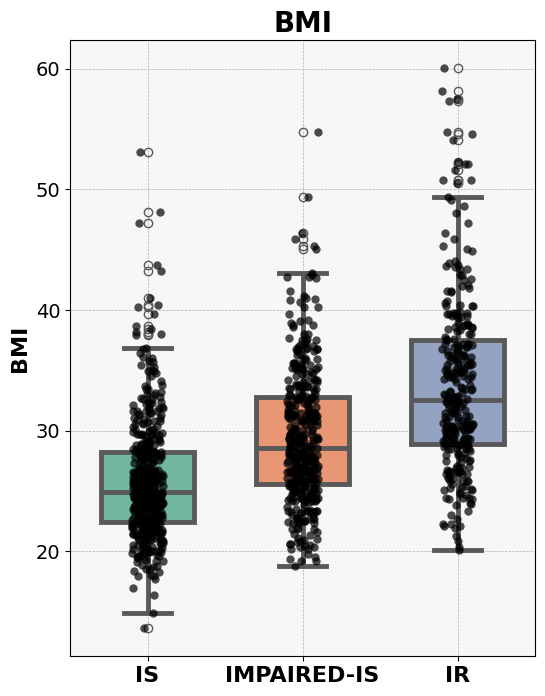

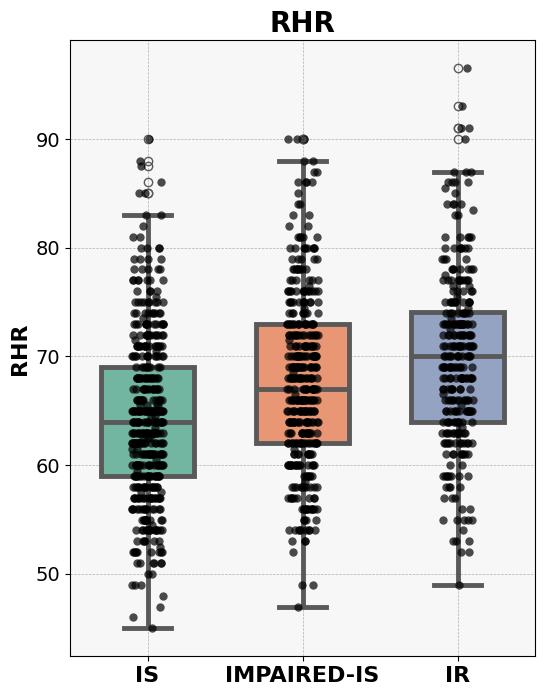

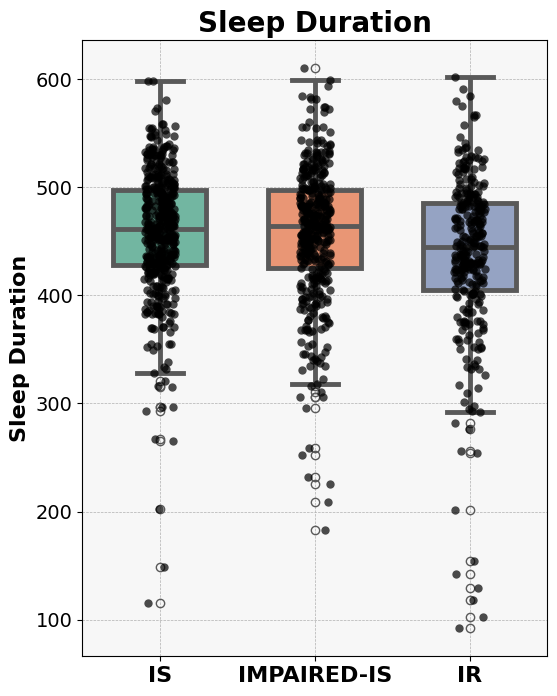

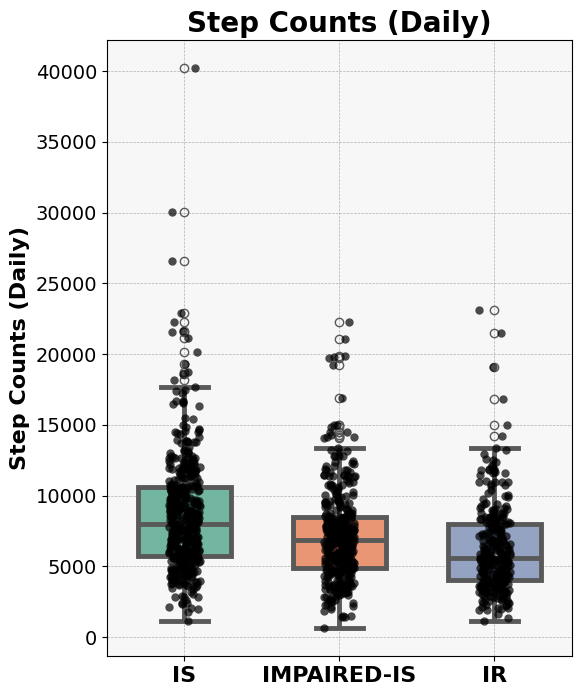

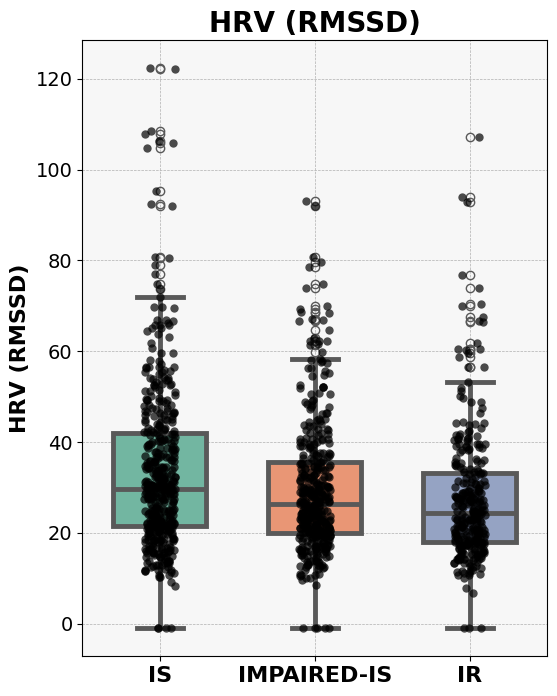

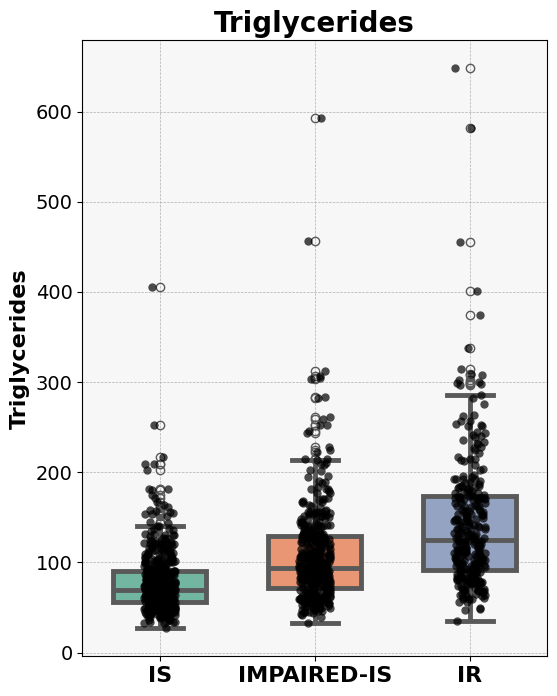

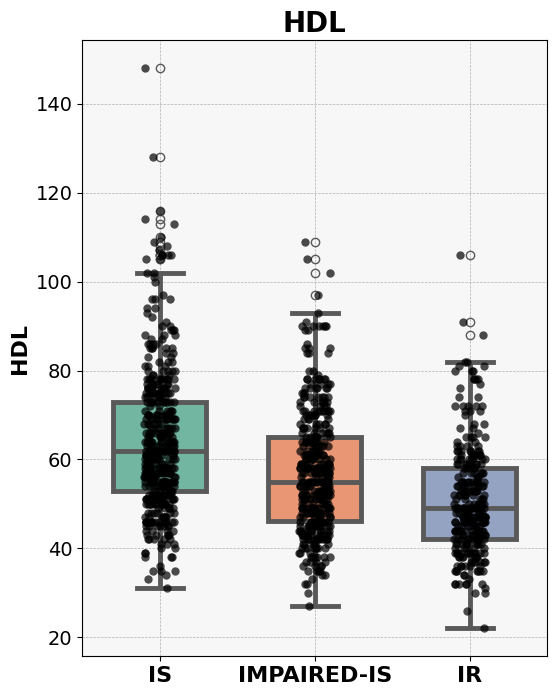

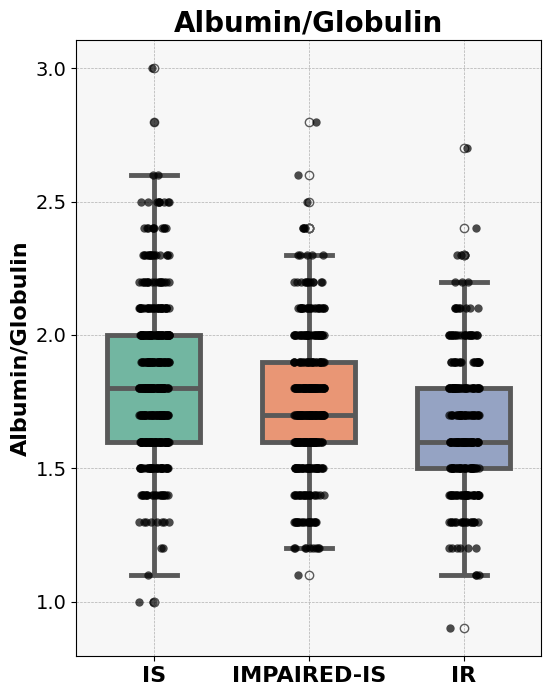

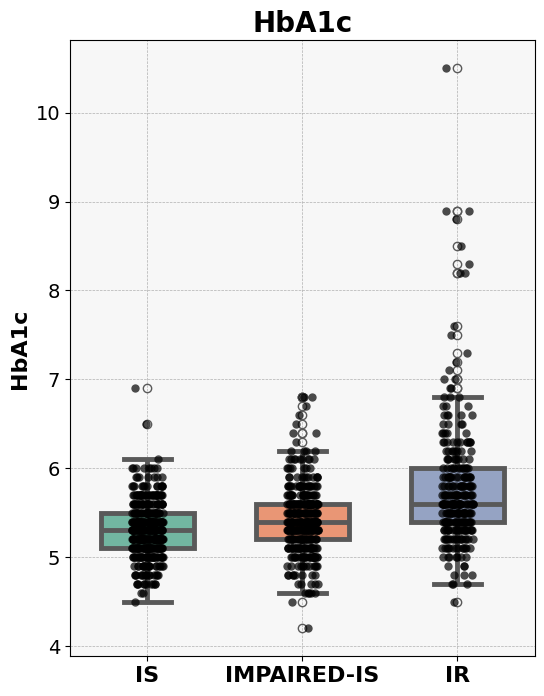

In [ ]:
#@title Create Box plot for Lifestyle and blood biomarkers
def plot_boxplot(filtered_df_for_plotting, y_axis, x_axis, y_axis_label, x_axis_label):
  # Create a figure and axis
  plt.figure(figsize=(6, 8))

  # Create a box plot with a custom color palette
  palette = sns.color_palette("Set2")

  sns.boxplot(x=x_axis, y=y_axis, data=filtered_df_for_plotting, palette=palette, order=["IS", "IMPAIRED-IS", "IR"], width=0.6, linewidth=3.5)

  # Overlay the strip plot (points)
  sns.stripplot(x=x_axis, y=y_axis, data=filtered_df_for_plotting, color='black', order=["IS", "IMPAIRED-IS", "IR"], size=6, jitter=True, alpha=0.7)

  # Customize the title and labels
  plt.title(y_axis_label, fontsize=20, weight='bold')
  plt.xlabel(x_axis_label, fontsize=16, weight='bold')
  plt.ylabel(y_axis_label, fontsize=16, weight='bold')

  # Customize the ticks on x and y axis
  plt.xticks(fontsize=16, weight='bold')
  plt.yticks(fontsize=14)

  # Add gridlines for better readability
  plt.grid(True, which='both', linestyle='--', linewidth=0.5)

  # Add a background color to the plot area
  plt.gca().set_facecolor('#f7f7f7')

  figure_name = y_axis + "_" + x_axis + "01212025_2"
  figure_name = figure_name.replace("/", "_")
  print(f'Saving figures with name: {figure_name}')

  png_figure_file_path = os.path.join(OUTPUTS_FOLDER, f'{figure_name}.png')
  with open(png_figure_file_path, 'wb') as f:
    plt.savefig(f, dpi=300, format="png", bbox_inches="tight")
    print(f'Saved figure to {png_figure_file_path}')

  pdf_figure_file_path = os.path.join(OUTPUTS_FOLDER, f'{figure_name}.pdf')
  with open(pdf_figure_file_path, 'wb') as f:
    plt.savefig(f, dpi=300, format="pdf", bbox_inches="tight")
    print(f'Saved figure to {pdf_figure_file_path}')

  svg_figure_file_path = os.path.join(OUTPUTS_FOLDER, f'{figure_name}.svg')
  with open(svg_figure_file_path, 'wb') as f:
    plt.savefig(f, dpi=300, format="svg", bbox_inches="tight")
    print(f'Saved figure to {svg_figure_file_path}')

  jpeg_figure_file_path = os.path.join(OUTPUTS_FOLDER, f'{figure_name}.jpeg')
  with open(jpeg_figure_file_path, 'wb') as f:
    plt.savefig(f, dpi=300, format="jpeg", bbox_inches="tight")
    print(f'Saved figure to {jpeg_figure_file_path}')

## BMI
test = labels_and_scores_digital_biomarkers_cleaned
plot_boxplot(filtered_df_for_plotting = test, y_axis = "bmi", x_axis = "homa_ir_status", y_axis_label = "BMI", x_axis_label = "")

## rhr
test = labels_and_scores_digital_biomarkers_cleaned
plot_boxplot(filtered_df_for_plotting = test, y_axis = "RHR_FreeLiving_median", x_axis = "homa_ir_status", y_axis_label = "RHR", x_axis_label = "")

## sleep
test = labels_and_scores_digital_biomarkers_cleaned
plot_boxplot(filtered_df_for_plotting = test, y_axis = "SLEEP_Duration_median", x_axis = "homa_ir_status", y_axis_label = "Sleep Duration", x_axis_label = "")

## Steps
test = labels_and_scores_digital_biomarkers_cleaned
plot_boxplot(filtered_df_for_plotting = test, y_axis = "STEPS_Daily_median", x_axis = "homa_ir_status", y_axis_label = "Step Counts (Daily)", x_axis_label = "")

## HRV
test = labels_and_scores_digital_biomarkers_cleaned
plot_boxplot(filtered_df_for_plotting = test, y_axis = "HRV_FreeLiving_median", x_axis = "homa_ir_status", y_axis_label = "HRV (RMSSD)", x_axis_label = "")

## triglycerides
test = labels_and_scores_digital_biomarkers_cleaned
plot_boxplot(filtered_df_for_plotting = test, y_axis = "triglycerides", x_axis = "homa_ir_status", y_axis_label = "Triglycerides", x_axis_label = "")

## hdl
test = labels_and_scores_digital_biomarkers_cleaned
plot_boxplot(filtered_df_for_plotting = test, y_axis = "hdl", x_axis = "homa_ir_status", y_axis_label = "HDL", x_axis_label = "")

## 'albumin/globulin'
test = labels_and_scores_digital_biomarkers_cleaned
plot_boxplot(filtered_df_for_plotting = test, y_axis = "albumin/globulin", x_axis = "homa_ir_status", y_axis_label = "Albumin/Globulin", x_axis_label = "")

## hba1c
test = labels_and_scores_digital_biomarkers_cleaned
plot_boxplot(filtered_df_for_plotting = test, y_axis = "hba1c", x_axis = "homa_ir_status", y_axis_label = "HbA1c", x_axis_label = "")


<Figure size 800x1000 with 0 Axes>

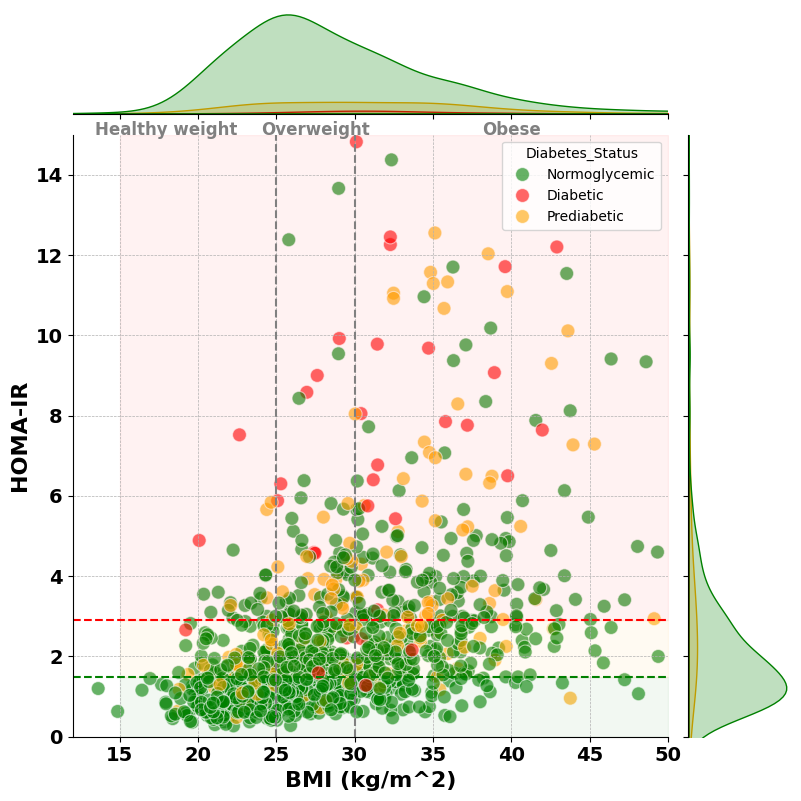

Saving figures with name: homa_ir_bmi_diabetes_status_01212025_2
Saved figure to /content/output_data/homa_ir_bmi_diabetes_status_01212025_2.png
Saved figure to /content/output_data/homa_ir_bmi_diabetes_status_01212025_2.pdf
Saved figure to /content/output_data/homa_ir_bmi_diabetes_status_01212025_2.svg
Saved figure to /content/output_data/homa_ir_bmi_diabetes_status_01212025_2.jpeg


<Figure size 640x480 with 0 Axes>

In [ ]:
#@title Highlight Diabates Status on the scatter plot
# Create a new column named 'Diabetes_Status'
def assign_status(row):
  if row['hba1c'] > 6.5:
    return 'Diabetic'
  elif row['hba1c'] >= 5.7 and row['hba1c'] <= 6.4:
    return 'Prediabetic'
  else:
    return 'Normoglycemic'

labels_and_scores_digital_biomarkers_cleaned['Diabetes_Status'] = labels_and_scores_digital_biomarkers_cleaned.apply(assign_status, axis=1)

# plt.figure(figsize=(8, 10))
plt.figure(figsize=(8, 10))

color_palette = {'Normoglycemic': 'green', 'Prediabetic': 'orange', 'Diabetic': 'red'}
marker_styles = {'Normoglycemic': 'o', 'Prediabetic': 's', 'Diabetic': '^'}
g = sns.jointplot(data=labels_and_scores_digital_biomarkers_cleaned, x="bmi",
              y="homa_ir", hue="Diabetes_Status", palette=color_palette, height=8,
              s=100, alpha = 0.6)

## Shade area between HOMA-IR classes
plt.fill_betweenx(y=[0, 1.5], x1 = 15, x2 = 50, color='green', alpha=0.05, label='Shaded Area')
plt.fill_betweenx(y=[1.5, 2.9], x1 = 15, x2 = 50, color='orange', alpha=0.05, label='Shaded Area')
plt.fill_betweenx(y=[2.9, 15], x1 = 15, x2 = 50, color='red', alpha=0.05, label='Shaded Area')


# Add horizontal lines
plt.axhline(y=1.5, color='green', linestyle='--', label='Line 1')
plt.axhline(y=2.9, color='red', linestyle='--', label='Line 2')

# Add vertical lines
plt.axvline(x=25, color='gray', linestyle='--', label='Line 1')
plt.axvline(x=30, color='gray', linestyle='--', label='Line 2')

# Add text annotations
x_axis_limit = 80

plt.text(18, 15, 'Healthy weight', color='gray', fontsize=12, ha='center',fontweight='bold')
plt.text(27.5, 15, 'Overweight', color='gray', fontsize=12, ha='center',fontweight='bold')
plt.text(40, 15, 'Obese', color='gray', fontsize=12, ha='center',fontweight='bold')



# # Set plot labels and title
plt.xlabel('BMI (kg/m^2)', fontsize=16, fontweight='bold')
plt.ylabel('HOMA-IR', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')


plt.xlim(left=12, right=50)
plt.ylim(bottom=0, top=15)


# Access the underlying Axes object
ax = g.ax_joint

# Set grid lines
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()


#Save figures
figure_name = "homa_ir_bmi_diabetes_status_" + "01212025_2"
figure_name = figure_name.replace("/", "_")
print(f'Saving figures with name: {figure_name}')

png_figure_file_path = os.path.join(OUTPUTS_FOLDER, f'{figure_name}.png')
with open(png_figure_file_path, 'wb') as f:
  plt.savefig(f, dpi=300, format="png", bbox_inches="tight")
  print(f'Saved figure to {png_figure_file_path}')

pdf_figure_file_path = os.path.join(OUTPUTS_FOLDER, f'{figure_name}.pdf')
with open(pdf_figure_file_path, 'wb') as f:
  plt.savefig(f, dpi=300, format="pdf", bbox_inches="tight")
  print(f'Saved figure to {pdf_figure_file_path}')

svg_figure_file_path = os.path.join(OUTPUTS_FOLDER, f'{figure_name}.svg')
with open(svg_figure_file_path, 'wb') as f:
  plt.savefig(f, dpi=300, format="svg", bbox_inches="tight")
  print(f'Saved figure to {svg_figure_file_path}')

jpeg_figure_file_path = os.path.join(OUTPUTS_FOLDER, f'{figure_name}.jpeg')
with open(jpeg_figure_file_path, 'wb') as f:
  plt.savefig(f, dpi=300, format="jpeg", bbox_inches="tight")
  print(f'Saved figure to {jpeg_figure_file_path}')


In [ ]:
#@title Correlation Figures

## Subset pvalue and correlations
features_of_interest = [
 'bmi',
 'age',
 'hypertension_binary',
 'RHR_FreeLiving_median',
 'RHR_FreeLiving_std',
 'HRV_FreeLiving_median',
 'HRV_FreeLiving_std',
 'STEPS_Daily_median',
 'STEPS_Daily_std',
 'SLEEP_Duration_median',
 'SLEEP_Duration_std',
 'total cholesterol',
 'hdl',
 'triglycerides',
 'ldl',
 'chol/hdl',
 'non hdl',
 'glucose',
 'bun',
 'creatinine',
 'egfr',
 'sodium',
 'potassium',
 'chloride',
 'co2',
 'calcium',
 'total protein',
 'albumin',
 'globulin',
 'albumin/globulin',
 'total bilirubin',
 'alp',
 'ast',
 'alt',
 'hba1c',
 'homa_ir',
 'insulin']

df_clean = labels_and_scores_digital_biomarkers_cleaned[features_of_interest].dropna()

# Get correlation matrix and p-value matrix
correlation_matrix, pvalue_matrix = corr_pval(df_clean)

print("Correlation Matrix:\n", correlation_matrix)
print("\nP-Value Matrix:\n", pvalue_matrix)


correlation_subset = correlation_matrix.loc[features_of_interest, features_of_interest]
pvalue_subset = pvalue_matrix.loc[features_of_interest, features_of_interest]
corr_sorted_row = correlation_subset["homa_ir"].sort_values(ascending=False)
pvalue_sorted_row = pvalue_subset["homa_ir"].sort_values(ascending=False)

index_to_remove = ["homa_ir", "insulin"]  # List of indices to remove

corr_sorted_row = corr_sorted_row.drop(index_to_remove)
pvalue_sorted_row = pvalue_sorted_row.drop(index_to_remove)

corr_pvalue_aggregate = corr_sorted_row.to_frame().merge(pvalue_sorted_row.to_frame(), left_index=True, right_index=True).reset_index(drop=False)

corr_pvalue_aggregate.columns = [['Feature', 'corr_coefficient_w_homa_ir', 'pvalue']]
corr_pvalue_aggregate.columns = corr_pvalue_aggregate.columns.get_level_values(0)
corr_pvalue_aggregate['adjusted_pvalue'] = smm.multipletests(corr_pvalue_aggregate['pvalue'], method='fdr_bh')[1]
corr_pvalue_aggregate


Correlation Matrix:
                             bmi       age  hypertension_binary  \
bmi                    1.000000 -0.047066             0.197521   
age                   -0.047066  1.000000             0.305188   
hypertension_binary    0.197521  0.305188             1.000000   
RHR_FreeLiving_median  0.251492 -0.181355             0.057962   
RHR_FreeLiving_std     0.098747 -0.181974             0.020991   
HRV_FreeLiving_median -0.064841 -0.373684            -0.213497   
HRV_FreeLiving_std    -0.010422 -0.166287            -0.106797   
STEPS_Daily_median    -0.280928  0.018876            -0.088399   
STEPS_Daily_std       -0.219200 -0.075594            -0.152611   
SLEEP_Duration_median -0.119198  0.016216            -0.020091   
SLEEP_Duration_std     0.146407 -0.116190             0.054843   
total cholesterol     -0.048183  0.067332            -0.105110   
hdl                   -0.279957  0.181219            -0.064607   
triglycerides          0.268544  0.041024             0

Feature  corr_coefficient_w_homa_ir        pvalue  \
0                 glucose                    0.566926  1.112810e-98   
1                   hba1c                    0.441148  6.605932e-56   
2                     bmi                    0.433588  7.313533e-54   
3           triglycerides                    0.412750  1.725422e-48   
4   RHR_FreeLiving_median                    0.274647  2.483131e-21   
5                chol/hdl                    0.248564  1.221022e-17   
6     hypertension_binary                    0.247408  1.741165e-17   
7                     alt                    0.194445  2.981873e-11   
8                     alp                    0.193580  3.657670e-11   
9                globulin                    0.184040  3.270849e-10   
10     SLEEP_Duration_std                    0.146366  6.266490e-07   
11          total protein                    0.102079  5.293429e-04   
12                calcium                    0.080533  6.309082e-03   
13                non hdl                    0.076096  9.870208e-03   
14     RHR_FreeLiving_std                    0.071210  1.576817e-02   
15                    age                    0.065463  2.648870e-02   
16             creatinine                    0.027633  3.493645e-01   
17              potassium                    0.020813  4.809237e-01   
18                    ldl                    0.006980  8.131631e-01   
19                    ast                    0.000787  9.787508e-01   
20                 sodium                   -0.015766  5.934233e-01   
21                    bun                   -0.026443  3.705049e-01   
22     HRV_FreeLiving_std                   -0.030659  2.990967e-01   
23                   egfr                   -0.034545  2.419870e-01   
24      total cholesterol                   -0.042003  1.547840e-01   
25               chloride                   -0.047890  1.046978e-01   
26                    co2                   -0.065847  2.561465e-02   
27                albumin                   -0.075926  1.003636e-02   
28        total bilirubin                   -0.123308  2.774827e-05   
29  HRV_FreeLiving_median                   -0.143933  9.628335e-07   
30  SLEEP_Duration_median                   -0.148807  4.044690e-07   
31        STEPS_Daily_std                   -0.181195  6.149820e-10   
32       albumin/globulin                   -0.197984  1.280142e-11   
33     STEPS_Daily_median                   -0.253416  2.698523e-18   
34                    hdl                   -0.295489  1.386965e-24   

    adjusted_pvalue  
0      3.894834e-97  
1      1.156038e-54  
2      8.532455e-53  
3      1.509744e-47  
4      1.448493e-20  
5      5.341973e-17  
6      6.771196e-17  
7      9.487779e-11  
8      1.066820e-10  
9      8.806133e-10  
10     1.370795e-06  
11     9.751054e-04  
12     1.104089e-02  
13     1.596694e-02  
14     2.399505e-02  
15     3.708418e-02  
16     4.075920e-01  
17     5.260103e-01  
18     8.370796e-01  
19     9.787508e-01  
20     6.293883e-01  
21     4.183119e-01  
22     3.609787e-01  
23     3.024837e-01  
24     2.006459e-01  
25     1.409393e-01  
26     3.708418e-02  
27     1.596694e-02  
28     5.395497e-05  
29     1.982304e-06  
30     9.437611e-07  
31     1.537455e-09  
32     4.480499e-11  
33     1.349261e-17  
34     9.708757e-24

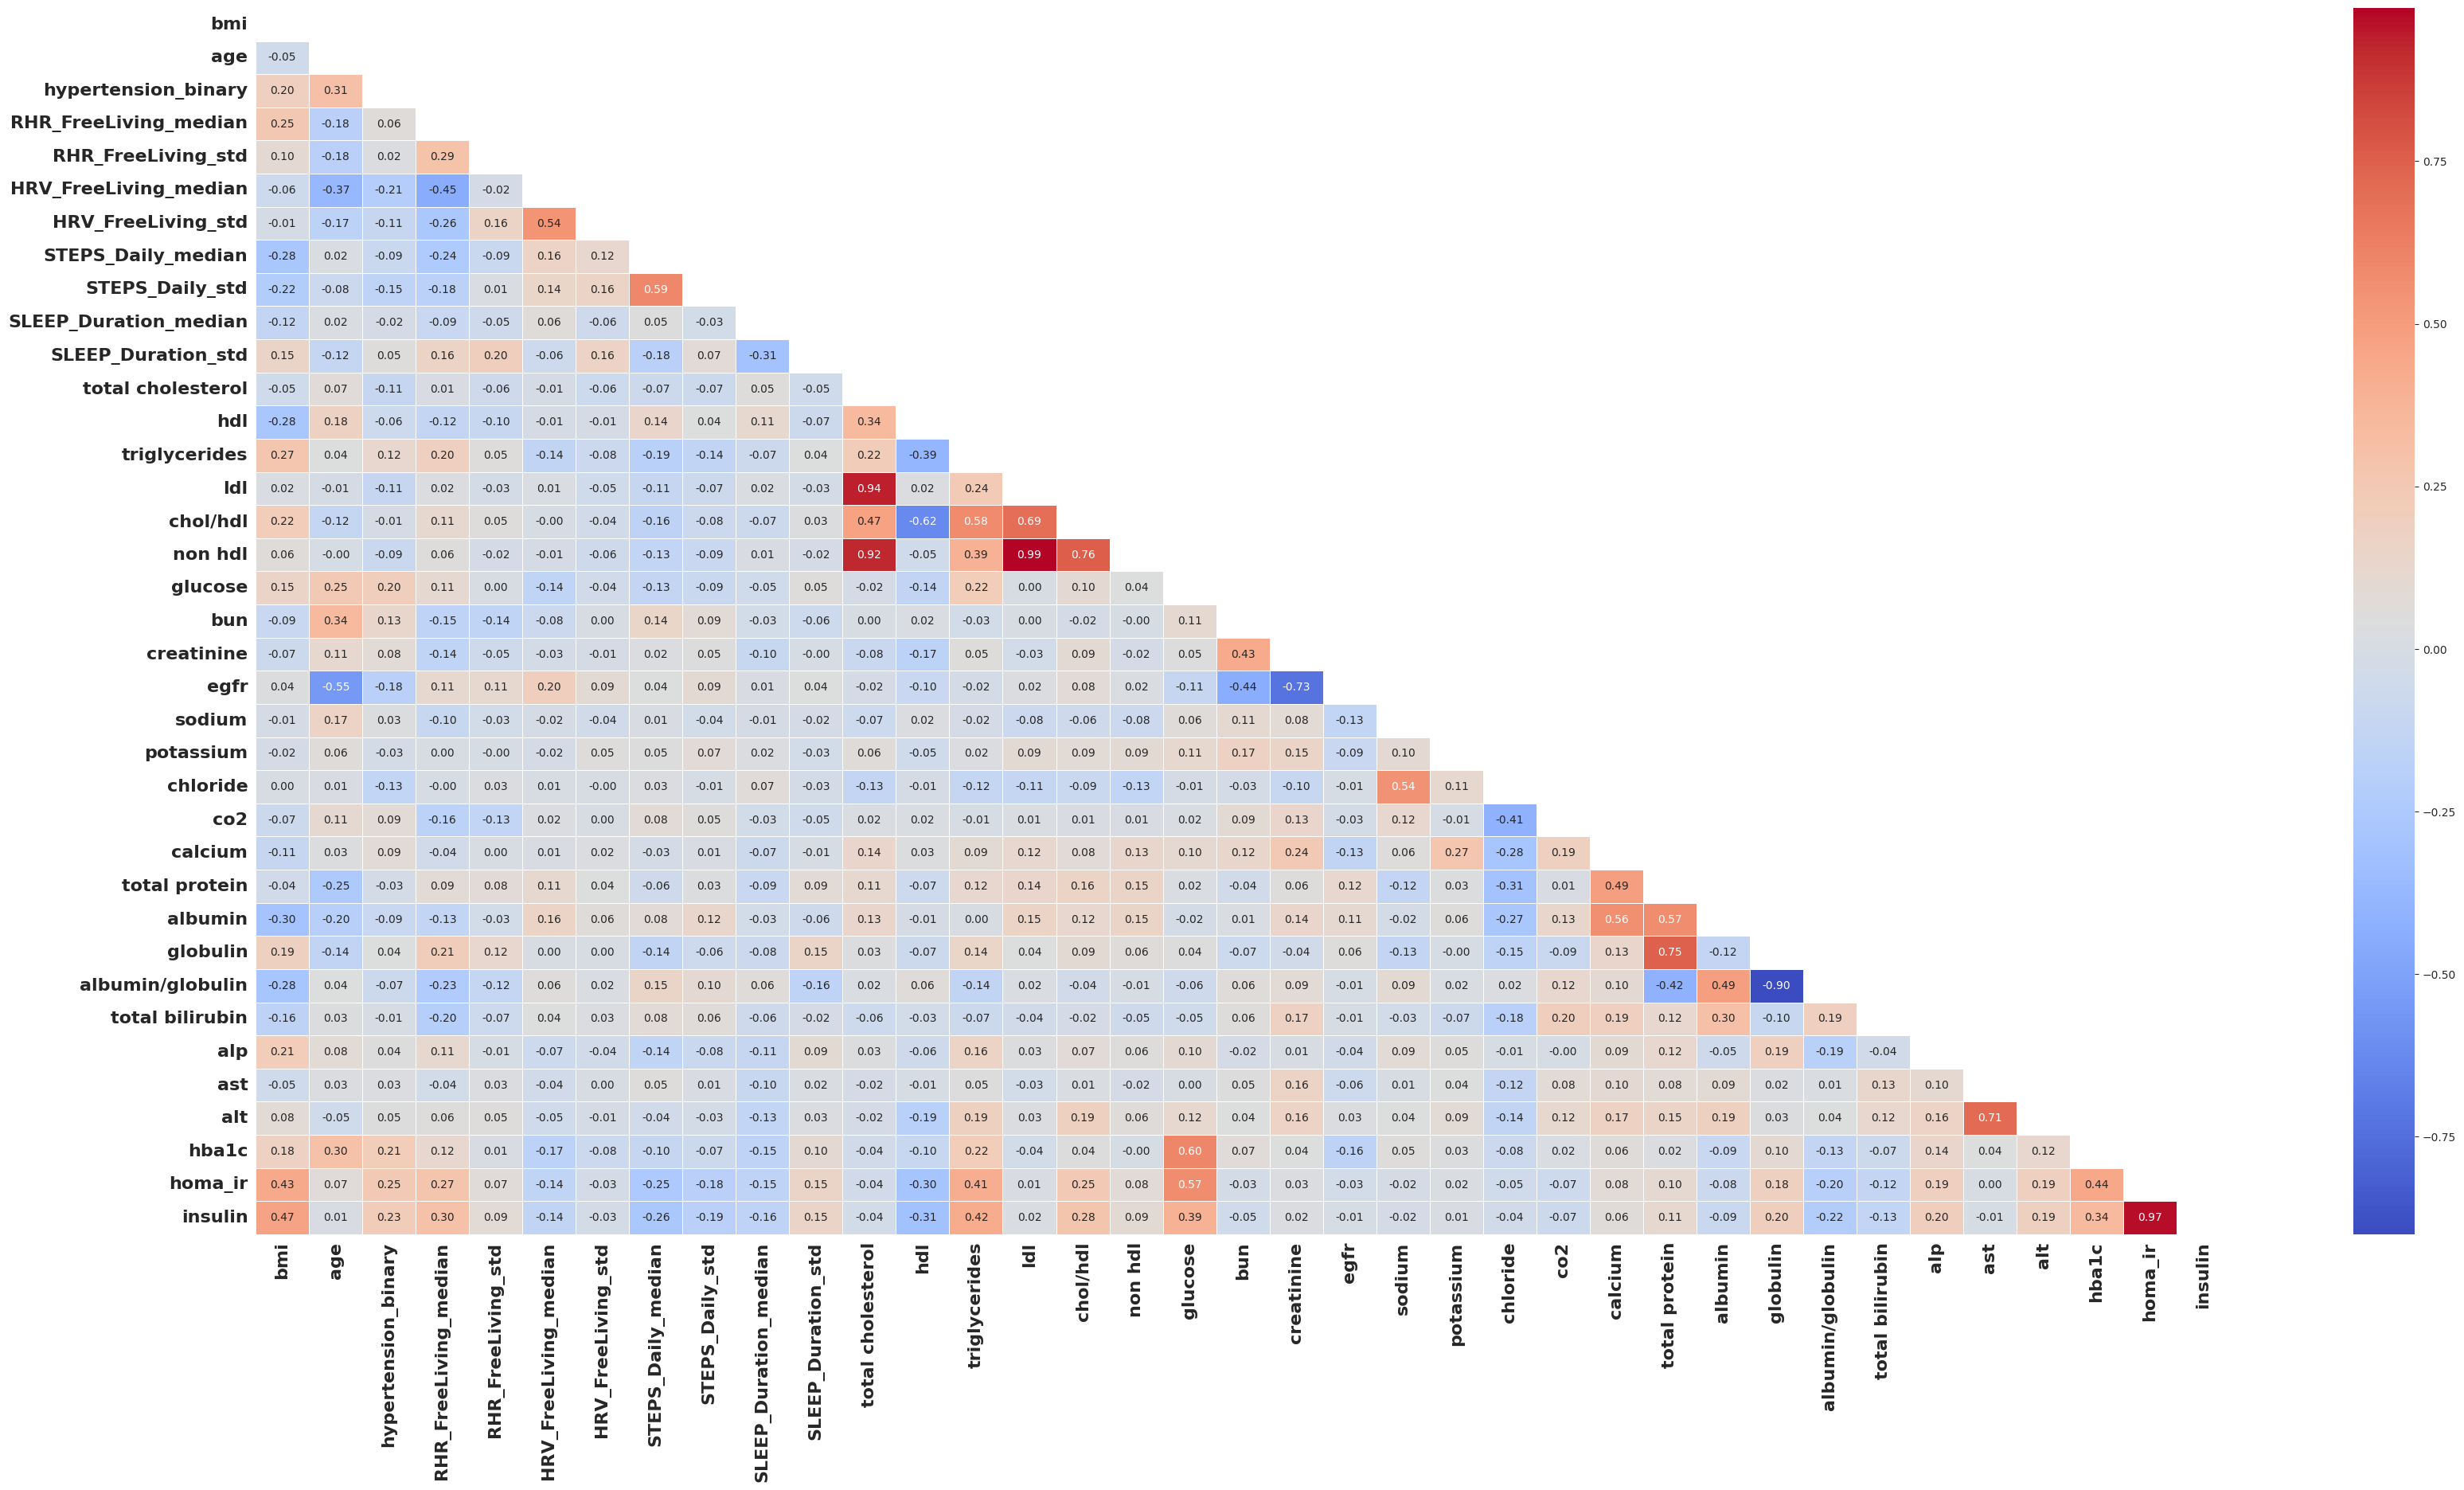

In [ ]:
# Create a heatmap
## Optimize Correlation Matrix

features_of_interest = ['bmi',
 'age',
 'hypertension_binary',
 'RHR_FreeLiving_median',
 'RHR_FreeLiving_std',
 'HRV_FreeLiving_median',
 'HRV_FreeLiving_std',
 'STEPS_Daily_median',
 'STEPS_Daily_std',
 'SLEEP_Duration_median',
 'SLEEP_Duration_std',
 'total cholesterol',
 'hdl',
 'triglycerides',
 'ldl',
 'chol/hdl',
 'non hdl',
 'glucose',
 'bun',
 'creatinine',
 'egfr',
 'sodium',
 'potassium',
 'chloride',
 'co2',
 'calcium',
 'total protein',
 'albumin',
 'globulin',
 'albumin/globulin',
 'total bilirubin',
 'alp',
 'ast',
 'alt',
 'hba1c',
 'homa_ir',
 'insulin']
correlation_subset = correlation_matrix.loc[features_of_interest, features_of_interest]

sns.set_style(style='white')
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_subset))
# Create a heatmap using Seaborn
plt.figure(figsize=(40, 20))

# heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, mask=mask)
heatmap = sns.heatmap(correlation_subset, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, mask=mask)

# # Increase font size of x-axis and y-axis labels
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=16)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=16)


plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

# Show the plot
plt.show()

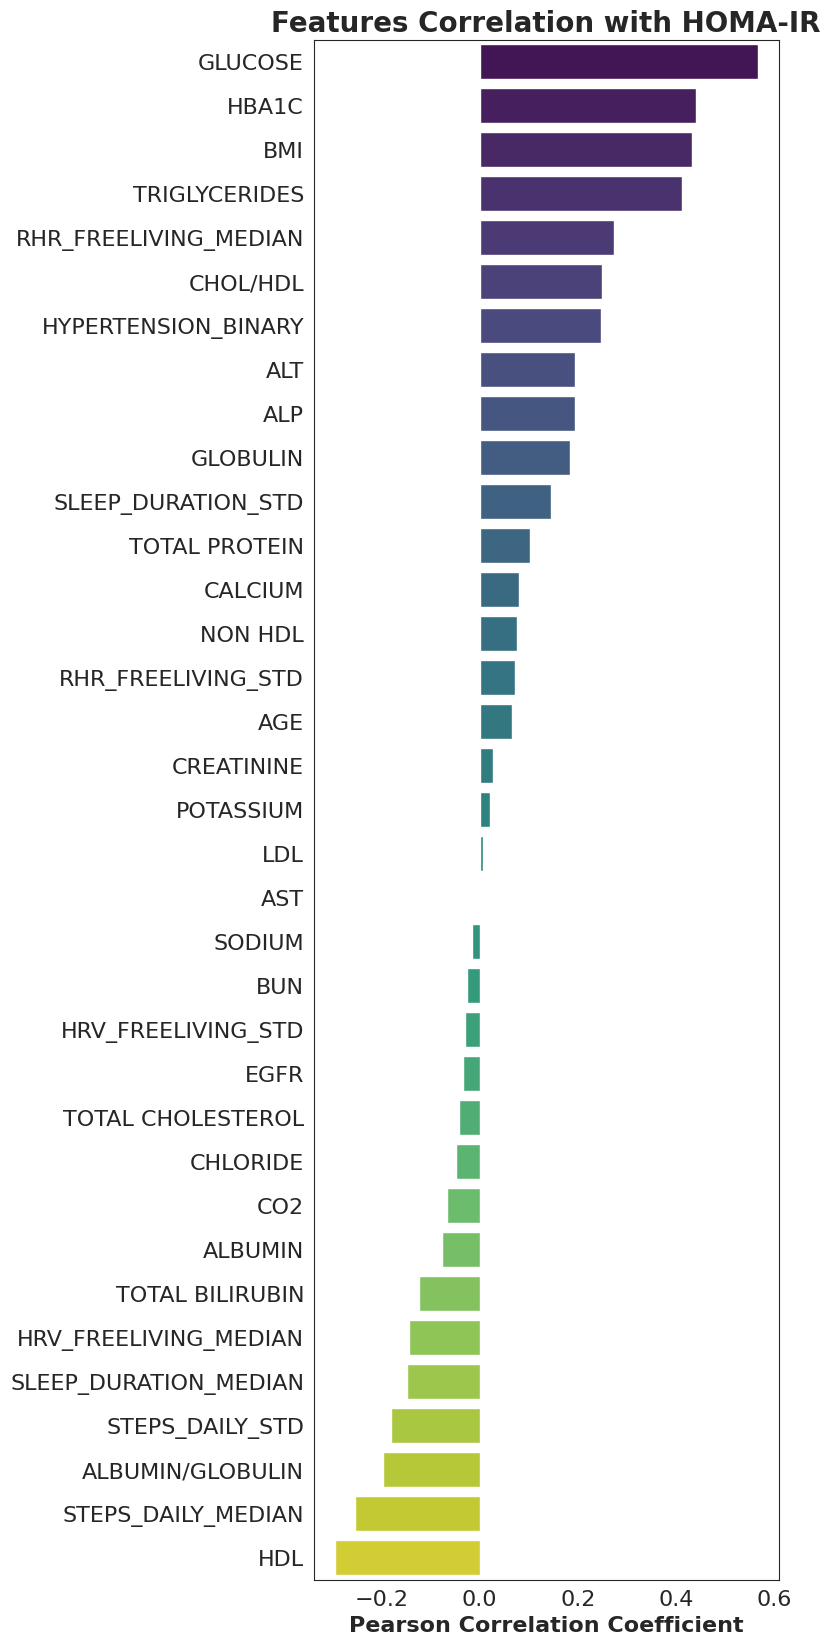

In [ ]:
# Sort DataFrame by 'Value' column (descending order)
sorted_row = correlation_subset["homa_ir"].sort_values(ascending=False)

index_to_remove = ["homa_ir", "insulin"]  # List of indices to remove
sorted_row = sorted_row.drop(index_to_remove)

# modified_indexes = [index.lower().capitalize() for index in sorted_row.index]
modified_indexes = [index.upper() for index in sorted_row.index]
sorted_row.index = modified_indexes

# Plotting
plt.figure(figsize=(6, 20))  # Adjust the figure size as needed
sns.barplot(x=sorted_row.values, y=sorted_row.index, palette="viridis")

# Adding labels and title
plt.title('Features Correlation with HOMA-IR', fontsize=20, weight='bold')
plt.xlabel('Pearson Correlation Coefficient', fontsize=16, weight='bold')
plt.ylabel('', fontsize=16, weight='bold')



# Customize the ticks on x and y axis
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


plt.show()

In [ ]:
corr_pvalue_aggregate['pvalue'].apply(lambda x: "{:.2e}".format(x))

0     1.11e-98
1     6.61e-56
2     7.31e-54
3     1.73e-48
4     2.48e-21
5     1.22e-17
6     1.74e-17
7     2.98e-11
8     3.66e-11
9     3.27e-10
10    6.27e-07
11    5.29e-04
12    6.31e-03
13    9.87e-03
14    1.58e-02
15    2.65e-02
16    3.49e-01
17    4.81e-01
18    8.13e-01
19    9.79e-01
20    5.93e-01
21    3.71e-01
22    2.99e-01
23    2.42e-01
24    1.55e-01
25    1.05e-01
26    2.56e-02
27    1.00e-02
28    2.77e-05
29    9.63e-07
30    4.04e-07
31    6.15e-10
32    1.28e-11
33    2.70e-18
34    1.39e-24
Name: pvalue, dtype: object

In [ ]:
print("Columns in the correlation subset:")
print(correlation_subset.columns)

Columns in the correlation subset:
Index(['bmi', 'age', 'hypertension_binary', 'RHR_FreeLiving_median',
       'RHR_FreeLiving_std', 'HRV_FreeLiving_median', 'HRV_FreeLiving_std',
       'STEPS_Daily_median', 'STEPS_Daily_std', 'SLEEP_Duration_median',
       'SLEEP_Duration_std', 'total cholesterol', 'hdl', 'triglycerides',
       'ldl', 'chol/hdl', 'non hdl', 'glucose', 'bun', 'creatinine', 'egfr',
       'sodium', 'potassium', 'chloride', 'co2', 'calcium', 'total protein',
       'albumin', 'globulin', 'albumin/globulin', 'total bilirubin', 'alp',
       'ast', 'alt', 'hba1c', 'homa_ir', 'insulin'],
      dtype='object')


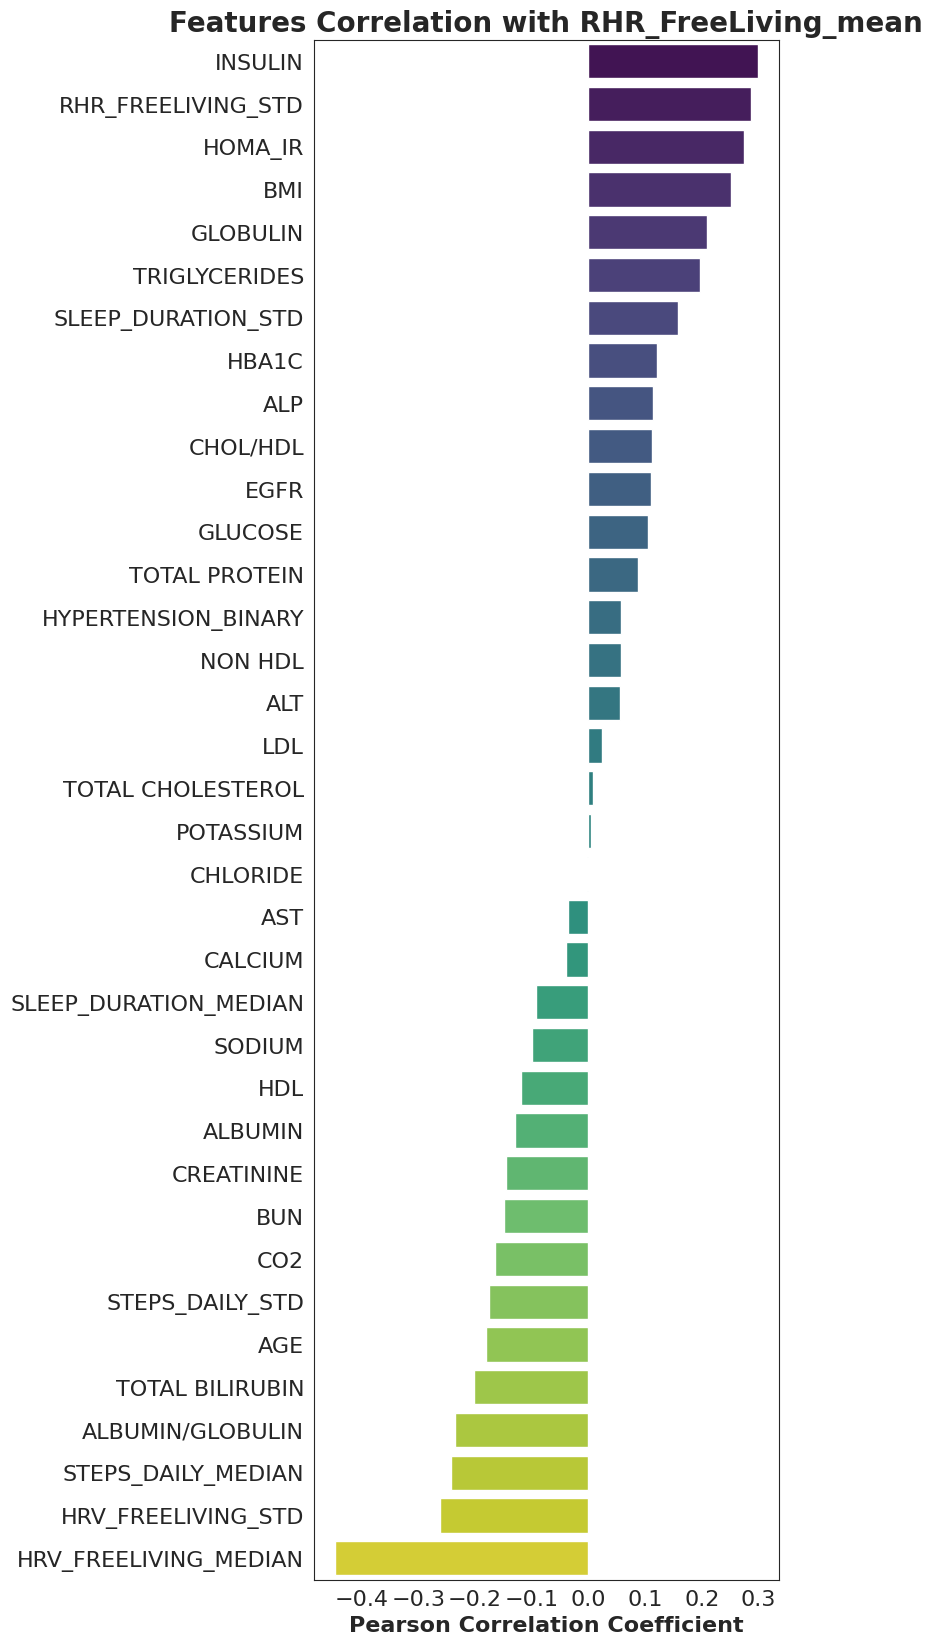

In [ ]:
sorted_row = correlation_subset["RHR_FreeLiving_median"].sort_values(ascending=False)

index_to_remove = ["RHR_FreeLiving_median"]  # List of indices to remove
sorted_row = sorted_row.drop(index_to_remove)

modified_indexes = [index.upper() for index in sorted_row.index]
sorted_row.index = modified_indexes

# Plotting
plt.figure(figsize=(6, 20))  # Adjust the figure size as needed
sns.barplot(x=sorted_row.values, y=sorted_row.index, palette="viridis")

# Adding labels and title
plt.title('Features Correlation with RHR_FreeLiving_mean', fontsize=20, weight='bold')
plt.xlabel('Pearson Correlation Coefficient', fontsize=16, weight='bold')
plt.ylabel('', fontsize=16, weight='bold')



# Customize the ticks on x and y axis
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


plt.show()

In [ ]:
#@title select subset for Supplementary Table
corr_pvalue_aggregate["Feature"] = corr_pvalue_aggregate["Feature"].str.upper()
corr_pvalue_aggregate["corr_coefficient_w_homa_ir"] = corr_pvalue_aggregate["corr_coefficient_w_homa_ir"].round(2)
corr_pvalue_aggregate['pvalue'] = corr_pvalue_aggregate['pvalue'].apply(lambda x: "{:.2e}".format(x))
corr_pvalue_aggregate['adjusted_pvalue'] = corr_pvalue_aggregate['adjusted_pvalue'].apply(lambda x: "{:.2e}".format(x))

corr_pvalue_aggregate

Feature  corr_coefficient_w_homa_ir    pvalue  \
0                 GLUCOSE                        0.57  1.11e-98   
1                   HBA1C                        0.44  6.61e-56   
2                     BMI                        0.43  7.31e-54   
3           TRIGLYCERIDES                        0.41  1.73e-48   
4   RHR_FREELIVING_MEDIAN                        0.27  2.48e-21   
5                CHOL/HDL                        0.25  1.22e-17   
6     HYPERTENSION_BINARY                        0.25  1.74e-17   
7                     ALT                        0.19  2.98e-11   
8                     ALP                        0.19  3.66e-11   
9                GLOBULIN                        0.18  3.27e-10   
10     SLEEP_DURATION_STD                        0.15  6.27e-07   
11          TOTAL PROTEIN                        0.10  5.29e-04   
12                CALCIUM                        0.08  6.31e-03   
13                NON HDL                        0.08  9.87e-03   
14     RHR_FREELIVING_STD                        0.07  1.58e-02   
15                    AGE                        0.07  2.65e-02   
16             CREATININE                        0.03  3.49e-01   
17              POTASSIUM                        0.02  4.81e-01   
18                    LDL                        0.01  8.13e-01   
19                    AST                        0.00  9.79e-01   
20                 SODIUM                       -0.02  5.93e-01   
21                    BUN                       -0.03  3.71e-01   
22     HRV_FREELIVING_STD                       -0.03  2.99e-01   
23                   EGFR                       -0.03  2.42e-01   
24      TOTAL CHOLESTEROL                       -0.04  1.55e-01   
25               CHLORIDE                       -0.05  1.05e-01   
26                    CO2                       -0.07  2.56e-02   
27                ALBUMIN                       -0.08  1.00e-02   
28        TOTAL BILIRUBIN                       -0.12  2.77e-05   
29  HRV_FREELIVING_MEDIAN                       -0.14  9.63e-07   
30  SLEEP_DURATION_MEDIAN                       -0.15  4.04e-07   
31        STEPS_DAILY_STD                       -0.18  6.15e-10   
32       ALBUMIN/GLOBULIN                       -0.20  1.28e-11   
33     STEPS_DAILY_MEDIAN                       -0.25  2.70e-18   
34                    HDL                       -0.30  1.39e-24   

   adjusted_pvalue  
0         3.89e-97  
1         1.16e-54  
2         8.53e-53  
3         1.51e-47  
4         1.45e-20  
5         5.34e-17  
6         6.77e-17  
7         9.49e-11  
8         1.07e-10  
9         8.81e-10  
10        1.37e-06  
11        9.75e-04  
12        1.10e-02  
13        1.60e-02  
14        2.40e-02  
15        3.71e-02  
16        4.08e-01  
17        5.26e-01  
18        8.37e-01  
19        9.79e-01  
20        6.29e-01  
21        4.18e-01  
22        3.61e-01  
23        3.02e-01  
24        2.01e-01  
25        1.41e-01  
26        3.71e-02  
27        1.60e-02  
28        5.40e-05  
29        1.98e-06  
30        9.44e-07  
31        1.54e-09  
32        4.48e-11  
33        1.35e-17  
34        9.71e-24

### Startify subjects based on Physical activity and BMI

In [ ]:
# @title Upload `experiment_id_to_full_prediction_df_mapping` file from your filesystem.
uploaded = files.upload(target_dir=INPUTS_FOLDER)

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes to folder {folder}'.format(
      name=fn, length=len(uploaded[fn]), folder=INPUTS_FOLDER))

if len(uploaded) == 1:
  EXP_DATA_SOURCE_PATH = fn
  print('Using file: ', EXP_DATA_SOURCE_PATH)
else:
  print('Only one file supported, try again.')

Saving experiment_id_to_full_prediction_df_mapping.pkl to /content/input_data/experiment_id_to_full_prediction_df_mapping (2).pkl
User uploaded file "/content/input_data/experiment_id_to_full_prediction_df_mapping (2).pkl" with length 817859 bytes to folder /content/input_data
Using file:  /content/input_data/experiment_id_to_full_prediction_df_mapping (2).pkl


In [ ]:
#@title Load experiment to dataframe mapping
with open(EXP_DATA_SOURCE_PATH, 'rb') as f:
    dfs = pickle.load(f)

In [ ]:
#@title Assign a group based on BMI and PA

# Define category for HOMA-IR
def categorize_homa_ir(homa_ir):
    if homa_ir > 2.9:
        return 1 #'IR'
    elif homa_ir <= 2.9:
        return 0 #'Non-IR'
    else:
        return 'Unknown'

# Define a function to categorize BMI
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 24.9:
        return 'Normal weight'
    elif 25 <= bmi < 29.9:
        return 'Overweight'
    else:
        return 'Obesity'


# Define a function to categorize physical activity based on step count
def categorize_activity(steps):
    if steps < 5000:
        return 'Sedentary'
    elif 5000 <= steps < 7500:
        return 'Low active'
    elif 7500 <= steps < 10000:
        return 'Somewhat active'
    elif 10000 <= steps < 12500:
        return 'Active'
    else:
        return 'Highly active'


# Define a function to categorize physical activity based on weekly AZM
def categorize_azm(azm):
    if azm < 150:
        return 'Sedentary'
    elif 150 <= azm < 300:
        return 'Low active'
    elif 300 <= azm < 450:
        return 'Active'
    else:
        return 'Highly active'



def categorize_diabetes(hb1c):
  if hb1c > 6.5:
    return 'Diabetic'
  elif hb1c >= 5.7 and hb1c <= 6.4:
    return 'Prediabetic'
  else:
    return 'Normoglycemic'

In [ ]:
#@title Calculate performance per class
def calculate_performance(df, subgroup = "Test"):
  # Calculate confusion matrix
  tn, fp, fn, tp = confusion_matrix(df['homa_ir_class_true'],
                        df['homa_ir_class_predicted'] ).ravel()

  # Calculate sensitivity and specificity
  sensitivity = round(tp / (tp + fn),3)
  specificity = round(tn / (tn + fp),3)


  ## Calculate adjusted specificty
  impaired_predicted_as_ir = df[(df["true_values"]<=2.9) & (df["true_values"]>=1.5) & (df["predicted_values"]>2.9)]
  num_impaired_predicted_as_ir = impaired_predicted_as_ir.shape[0]
  fp_adjusted = fp - num_impaired_predicted_as_ir
  adjusted_specificity = round(tn / (tn + fp_adjusted),3)

  print(f"subgroup: {subgroup}", f"Sensitivity: {sensitivity}", f"Specificity: {specificity}", f"AdjustedSpecificity: {adjusted_specificity}", f"tn: {tn}", f"fp: {fp}", f"fp_adjusted: {fp_adjusted}")
  print("Dimension = ", df.shape)
  display(df[(df["true_values"]<1.5) & (df["predicted_values"]>2.9)])

  columns = ['Subgroup', 'Sensitivity', 'Specificity', 'AdjustedSpecificity']
  perf_df = pd.DataFrame([[subgroup, round(sensitivity,2), round(specificity,2), round(adjusted_specificity,2)]], columns=columns)

  return perf_df


(1173, 4)
(1165, 159)
subgroup: All cohort Sensitivity: 0.76 Specificity: 0.84 AdjustedSpecificity: 0.971 tn: 727 fp: 138 fp_adjusted: 22
Dimension =  (1165, 164)


participant_id  predicted_values  true_values Experiment_ID  \
131            13699          3.346045         1.22        EXP_11   
152            13819          2.921984         0.72        EXP_11   
191            55870          2.952543         0.66        EXP_11   
328            56418          3.009351         0.77        EXP_11   
377            56883          3.488820         1.18        EXP_11   
384            56921          3.275285         1.35        EXP_11   
494            57609          3.029352         1.46        EXP_11   
497            57628          3.020782         1.17        EXP_11   
510            57672          3.234647         1.13        EXP_11   
536            57853          3.461545         1.34        EXP_11   
657            70306          3.980558         1.19        EXP_11   
666            70323          3.366820         1.21        EXP_11   
678            70355          3.664602         1.23        EXP_11   
793            70938          3.278019         1.15        EXP_11   
835            71323          3.108355         1.26        EXP_11   
937            72103          3.314164         1.00        EXP_11   
943            72123          4.663598         1.12        EXP_11   
951            72151          6.946205         1.07        EXP_11   
1057           72772          3.709178         1.42        EXP_11   
1063           72816          2.950277         1.22        EXP_11   
1066           72832          4.442048         1.28        EXP_11   
1089           73107          3.348786         1.45        EXP_11   

      RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
131             77.881720                   77.0            3.277604   
152             57.797980                   58.0            2.146795   
191             71.257143                   71.0            4.159565   
328             61.970297                   62.0            2.192050   
377             71.947368                   72.0            6.800652   
384             71.563636                   72.0            2.168800   
494             63.689320                   64.0            1.848027   
497             64.427350                   65.0            2.601803   
510             61.552381                   62.0            2.573256   
536             75.474747                   75.0            4.244658   
657             66.294118                   66.0            2.788393   
666             59.652174                   59.0            2.702234   
678             52.941606                   52.0            3.448770   
793             80.289157                   80.0            3.884796   
835             76.775510                   75.5            4.507613   
937             75.333333                   76.0            2.229817   
943             87.588889                   87.5            2.236790   
951             79.828571                   79.0            3.869788   
1057            77.415842                   77.0            2.563686   
1063            68.165217                   68.0            1.596560   
1066            73.170543                   73.0            2.623225   
1089            70.386667                   70.0            3.615379   

      HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
131             19.084679                18.7695            6.289622  ...   
152             16.404041                16.1420            4.429918  ...   
191             62.205130                63.7720           15.867430  ...   
328             29.781350                30.0265            6.525426  ...   
377             46.354786                36.1585           47.186600  ...   
384             17.900327                18.0995            3.762211  ...   
494             80.528835                80.7250           10.486620  ...   
497             54.463519                52.7555           14.056547  ...   
510             46.233162                49.0370           14.473240

subgroup: Obesity Sensitivity: 0.863 Specificity: 0.676 AdjustedSpecificity: 0.934 tn: 171 fp: 82 fp_adjusted: 12
Dimension =  (458, 164)


participant_id  predicted_values  true_values Experiment_ID  \
131            13699          3.346045         1.22        EXP_11   
191            55870          2.952543         0.66        EXP_11   
328            56418          3.009351         0.77        EXP_11   
384            56921          3.275285         1.35        EXP_11   
497            57628          3.020782         1.17        EXP_11   
536            57853          3.461545         1.34        EXP_11   
678            70355          3.664602         1.23        EXP_11   
951            72151          6.946205         1.07        EXP_11   
1057           72772          3.709178         1.42        EXP_11   
1063           72816          2.950277         1.22        EXP_11   
1066           72832          4.442048         1.28        EXP_11   
1089           73107          3.348786         1.45        EXP_11   

      RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
131             77.881720                   77.0            3.277604   
191             71.257143                   71.0            4.159565   
328             61.970297                   62.0            2.192050   
384             71.563636                   72.0            2.168800   
497             64.427350                   65.0            2.601803   
536             75.474747                   75.0            4.244658   
678             52.941606                   52.0            3.448770   
951             79.828571                   79.0            3.869788   
1057            77.415842                   77.0            2.563686   
1063            68.165217                   68.0            1.596560   
1066            73.170543                   73.0            2.623225   
1089            70.386667                   70.0            3.615379   

      HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
131             19.084679                18.7695            6.289622  ...   
191             62.205130                63.7720           15.867430  ...   
328             29.781350                30.0265            6.525426  ...   
384             17.900327                18.0995            3.762211  ...   
497             54.463519                52.7555           14.056547  ...   
536             34.240717                34.9030           10.327120  ...   
678             34.864829                34.6030            7.471314  ...   
951             23.468922                27.0155           11.959427  ...   
1057            19.213984                18.5970            4.285859  ...   
1063            29.555606                28.7260            9.637907  ...   
1066            12.802034                12.6280            2.826280  ...   
1089            36.990241                37.0445           11.965214  ...   

      ascvd_risk_category  optimal_ascvd_risk      apri  hypertension_binary  \
131                  None                 NaN  0.094271                    0   
191                  None                 NaN  0.158290                    0   
328                  None                 NaN  0.204082                    1   
384                  None                 NaN  0.267417                    1   
497                  None                 NaN  0.091185                    0   
536                  None                 NaN  0.239144                    0   
678                  None                 NaN  0.714286                    1   
951                  None                 NaN  0.551378                    0   
1057                 None                 NaN  0.147917                    0   
1063                 None                 NaN  0.185387                    0   
1066                 None                 NaN  0.170213                    0   
1089                 None                 NaN  0.178571                    0   

      Diabetes_Status  homa_ir_class_true  homa_ir_class_predicted  bmi_class  \
131     Normoglycemic                   0      

subgroup: Overweight Sensitivity: 0.63 Specificity: 0.875 AdjustedSpecificity: 0.978 tn: 267 fp: 38 fp_adjusted: 6
Dimension =  (378, 164)


participant_id  predicted_values  true_values Experiment_ID  \
152           13819          2.921984         0.72        EXP_11   
510           57672          3.234647         1.13        EXP_11   
793           70938          3.278019         1.15        EXP_11   
835           71323          3.108355         1.26        EXP_11   
937           72103          3.314164         1.00        EXP_11   
943           72123          4.663598         1.12        EXP_11   

     RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
152            57.797980                   58.0            2.146795   
510            61.552381                   62.0            2.573256   
793            80.289157                   80.0            3.884796   
835            76.775510                   75.5            4.507613   
937            75.333333                   76.0            2.229817   
943            87.588889                   87.5            2.236790   

     HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
152            16.404041                16.1420            4.429918  ...   
510            46.233162                49.0370           14.473240  ...   
793            27.444590                23.9840           14.531359  ...   
835            18.873694                19.4565            4.145776  ...   
937            15.605337                15.0920            3.413675  ...   
943            12.009691                12.1110            4.779979  ...   

     ascvd_risk_category  optimal_ascvd_risk      apri  hypertension_binary  \
152                 None                 NaN  0.242692                    1   
510                 None                 NaN  0.209314                    0   
793                 None                 NaN  0.456554                    0   
835                 None                 NaN  0.136054                    0   
937                 None                 NaN  0.211640                    0   
943                 None                 NaN  0.228137                    0   

     Diabetes_Status  homa_ir_class_true  homa_ir_class_predicted   bmi_class  \
152    Normoglycemic                   0                        1  Overweight   
510    Normoglycemic                   0                        1  Overweight   
793    Normoglycemic                   0                        1  Overweight   
835    Normoglycemic                   0                        1  Overweight   
937    Normoglycemic                   0                        1  Overweight   
943    Normoglycemic                   0                        1  Overweight   

     physical_activity_class_steps  diabetes_class  
152                     Low active   Normoglycemic  
510                Somewhat active   Normoglycemic  
793                     Low active   Normoglycemic  
835                Somewhat active   Normoglycemic  
937                Somewhat active   Normoglycemic  
943                Somewhat active   Normoglycemic  

[6 rows x 164 columns]

subgroup: Normal weight Sensitivity: 0.227 Specificity: 0.939 AdjustedSpecificity: 0.986 tn: 279 fp: 18 fp_adjusted: 4
Dimension =  (319, 164)


participant_id  predicted_values  true_values Experiment_ID  \
377           56883          3.488820         1.18        EXP_11   
494           57609          3.029352         1.46        EXP_11   
657           70306          3.980558         1.19        EXP_11   
666           70323          3.366820         1.21        EXP_11   

     RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
377            71.947368                   72.0            6.800652   
494            63.689320                   64.0            1.848027   
657            66.294118                   66.0            2.788393   
666            59.652174                   59.0            2.702234   

     HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
377            46.354786                36.1585           47.186600  ...   
494            80.528835                80.7250           10.486620  ...   
657            29.771059                30.0390           10.385523  ...   
666            36.528487                36.7570            6.097105  ...   

     ascvd_risk_category  optimal_ascvd_risk      apri  hypertension_binary  \
377                 None                 NaN  0.502092                    0   
494                 None                 NaN  0.128968                    0   
657                 None                 NaN  0.510204                    1   
666                 None                 NaN  0.156318                    1   

     Diabetes_Status  homa_ir_class_true  homa_ir_class_predicted  \
377    Normoglycemic                   0                        1   
494    Normoglycemic                   0                        1   
657    Normoglycemic                   0                        1   
666      Prediabetic                   0                        1   

         bmi_class  physical_activity_class_steps  diabetes_class  
377  Normal weight                     Low active   Normoglycemic  
494  Normal weight                Somewhat active   Normoglycemic  
657  Normal weight                     Low active   Normoglycemic  
666  Normal weight                      Sedentary     Prediabetic  

[4 rows x 164 columns]

subgroup: Sedentary Sensitivity: 0.885 Specificity: 0.703 AdjustedSpecificity: 0.968 tn: 90 fp: 38 fp_adjusted: 3
Dimension =  (232, 164)


participant_id  predicted_values  true_values Experiment_ID  \
131            13699          3.346045         1.22        EXP_11   
666            70323          3.366820         1.21        EXP_11   
1089           73107          3.348786         1.45        EXP_11   

      RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
131             77.881720                   77.0            3.277604   
666             59.652174                   59.0            2.702234   
1089            70.386667                   70.0            3.615379   

      HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
131             19.084679                18.7695            6.289622  ...   
666             36.528487                36.7570            6.097105  ...   
1089            36.990241                37.0445           11.965214  ...   

      ascvd_risk_category  optimal_ascvd_risk      apri  hypertension_binary  \
131                  None                 NaN  0.094271                    0   
666                  None                 NaN  0.156318                    1   
1089                 None                 NaN  0.178571                    0   

      Diabetes_Status  homa_ir_class_true  homa_ir_class_predicted  \
131     Normoglycemic                   0                        1   
666       Prediabetic                   0                        1   
1089    Normoglycemic                   0                        1   

          bmi_class  physical_activity_class_steps  diabetes_class  
131         Obesity                      Sedentary   Normoglycemic  
666   Normal weight                      Sedentary     Prediabetic  
1089        Obesity                      Sedentary   Normoglycemic  

[3 rows x 164 columns]

subgroup: Low active Sensitivity: 0.762 Specificity: 0.829 AdjustedSpecificity: 0.958 tn: 228 fp: 47 fp_adjusted: 10
Dimension =  (376, 164)


participant_id  predicted_values  true_values Experiment_ID  \
152            13819          2.921984         0.72        EXP_11   
191            55870          2.952543         0.66        EXP_11   
328            56418          3.009351         0.77        EXP_11   
377            56883          3.488820         1.18        EXP_11   
384            56921          3.275285         1.35        EXP_11   
497            57628          3.020782         1.17        EXP_11   
536            57853          3.461545         1.34        EXP_11   
657            70306          3.980558         1.19        EXP_11   
793            70938          3.278019         1.15        EXP_11   
1057           72772          3.709178         1.42        EXP_11   

      RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
152             57.797980                   58.0            2.146795   
191             71.257143                   71.0            4.159565   
328             61.970297                   62.0            2.192050   
377             71.947368                   72.0            6.800652   
384             71.563636                   72.0            2.168800   
497             64.427350                   65.0            2.601803   
536             75.474747                   75.0            4.244658   
657             66.294118                   66.0            2.788393   
793             80.289157                   80.0            3.884796   
1057            77.415842                   77.0            2.563686   

      HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
152             16.404041                16.1420            4.429918  ...   
191             62.205130                63.7720           15.867430  ...   
328             29.781350                30.0265            6.525426  ...   
377             46.354786                36.1585           47.186600  ...   
384             17.900327                18.0995            3.762211  ...   
497             54.463519                52.7555           14.056547  ...   
536             34.240717                34.9030           10.327120  ...   
657             29.771059                30.0390           10.385523  ...   
793             27.444590                23.9840           14.531359  ...   
1057            19.213984                18.5970            4.285859  ...   

      ascvd_risk_category  optimal_ascvd_risk      apri  hypertension_binary  \
152                  None                 NaN  0.242692                    1   
191                  None                 NaN  0.158290                    0   
328                  None                 NaN  0.204082                    1   
377                  None                 NaN  0.502092                    0   
384                  None                 NaN  0.267417                    1   
497                  None                 NaN  0.091185                    0   
536                  None                 NaN  0.239144                    0   
657                  None                 NaN  0.510204                    1   
793                  None                 NaN  0.456554                    0   
1057                 None                 NaN  0.147917                    0   

      Diabetes_Status  homa_ir_class_true  homa_ir_class_predicted  \
152     Normoglycemic                   0                        1   
191     Normoglycemic                   0                        1   
328     Normoglycemic                   0                        1   
377     Normoglycemic                   0                        1   
384     Normoglycemic                   0                        1   
497       Prediabetic                   0                        1   
536     Normoglycemic                   0                        1   
657     Normoglycemic                   0                        1   
793     Normoglycemic                   0                        1   
1057    Normoglycemic   

subgroup: Somewhat active Sensitivity: 0.636 Specificity: 0.85 AdjustedSpecificity: 0.963 tn: 210 fp: 37 fp_adjusted: 8
Dimension =  (313, 164)


participant_id  predicted_values  true_values Experiment_ID  \
494            57609          3.029352         1.46        EXP_11   
510            57672          3.234647         1.13        EXP_11   
678            70355          3.664602         1.23        EXP_11   
835            71323          3.108355         1.26        EXP_11   
937            72103          3.314164         1.00        EXP_11   
943            72123          4.663598         1.12        EXP_11   
951            72151          6.946205         1.07        EXP_11   
1063           72816          2.950277         1.22        EXP_11   

      RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
494             63.689320                   64.0            1.848027   
510             61.552381                   62.0            2.573256   
678             52.941606                   52.0            3.448770   
835             76.775510                   75.5            4.507613   
937             75.333333                   76.0            2.229817   
943             87.588889                   87.5            2.236790   
951             79.828571                   79.0            3.869788   
1063            68.165217                   68.0            1.596560   

      HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
494             80.528835                80.7250           10.486620  ...   
510             46.233162                49.0370           14.473240  ...   
678             34.864829                34.6030            7.471314  ...   
835             18.873694                19.4565            4.145776  ...   
937             15.605337                15.0920            3.413675  ...   
943             12.009691                12.1110            4.779979  ...   
951             23.468922                27.0155           11.959427  ...   
1063            29.555606                28.7260            9.637907  ...   

      ascvd_risk_category  optimal_ascvd_risk      apri  hypertension_binary  \
494                  None                 NaN  0.128968                    0   
510                  None                 NaN  0.209314                    0   
678                  None                 NaN  0.714286                    1   
835                  None                 NaN  0.136054                    0   
937                  None                 NaN  0.211640                    0   
943                  None                 NaN  0.228137                    0   
951                  None                 NaN  0.551378                    0   
1063                 None                 NaN  0.185387                    0   

      Diabetes_Status  homa_ir_class_true  homa_ir_class_predicted  \
494     Normoglycemic                   0                        1   
510     Normoglycemic                   0                        1   
678     Normoglycemic                   0                        1   
835     Normoglycemic                   0                        1   
937     Normoglycemic                   0                        1   
943     Normoglycemic                   0                        1   
951     Normoglycemic                   0                        1   
1063    Normoglycemic                   0                        1   

          bmi_class  physical_activity_class_steps  diabetes_class  
494   Normal weight                Somewhat active   Normoglycemic  
510      Overweight                Somewhat active   Normoglycemic  
678         Obesity                Somewhat active   Normoglycemic  
835      Overweight                Somewhat active   Normoglycemic  
937      Overweight                Somewhat active   Normoglycemic  
943      Overweight                Somewhat active   Normoglycemic  
951         Obesity                Somewhat active   Normoglycemic  
1063        Obesity                Somewhat active   Normoglycemic  

[8 rows x 164 columns]

subgroup: Active Sensitivity: 0.588 Specificity: 0.898 AdjustedSpecificity: 0.991 tn: 114 fp: 13 fp_adjusted: 1
Dimension =  (144, 164)


participant_id  predicted_values  true_values Experiment_ID  \
1066           72832          4.442048         1.28        EXP_11   

      RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
1066            73.170543                   73.0            2.623225   

      HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
1066            12.802034                 12.628             2.82628  ...   

      ascvd_risk_category  optimal_ascvd_risk      apri  hypertension_binary  \
1066                 None                 NaN  0.170213                    0   

      Diabetes_Status  homa_ir_class_true  homa_ir_class_predicted  bmi_class  \
1066         Diabetic                   0                        1    Obesity   

      physical_activity_class_steps  diabetes_class  
1066                         Active        Diabetic  

[1 rows x 164 columns]

subgroup: Highly active Sensitivity: 0.583 Specificity: 0.966 AdjustedSpecificity: 1.0 tn: 85 fp: 3 fp_adjusted: 0
Dimension =  (100, 164)


Empty DataFrame
Columns: [participant_id, predicted_values, true_values, Experiment_ID, RHR_FreeLiving_mean, RHR_FreeLiving_median, RHR_FreeLiving_std, HRV_FreeLiving_mean, HRV_FreeLiving_median, HRV_FreeLiving_std, STEPS_Daily_mean, STEPS_Daily_median, STEPS_Daily_std, SLEEP_Duration_mean, SLEEP_Duration_median, SLEEP_Duration_std, total cholesterol, hdl, triglycerides, ldl, chol/hdl, non hdl, glucose, bun, creatinine, egfr, sodium, potassium, chloride, co2, calcium, total protein, albumin, globulin, albumin/globulin, total bilirubin, alp, ast, alt, hba1c, insulin, crp, white_blood_cell, red_blood_cell, hb, hematocrit, mcv, mch, mchc, rdw, platelet, mpv, absolute_neutrophils, absolute_lymphocytes, absolute_monocytes, absolute_eosinophils, absolute_basophils, neutrophils, lymphocytes, monocytes, eosinophils, basophils, ggt, total testosterone, time, bun/creatinine, HEMOGLOBIN A1c, ALT, collection_hour_UTC, hdl_reported, a1c_date, a1c_reported, age, anxiety_or_depression_date, blood_pressure_date, cardiovascular_disease_date, cholesterol_date, contraceptives, diabetes_date, diabetes_medications, diabetes_type, diastolic_bp, employment_status, fasting_glucose_date, glucose_reported, sex, height, high_cholesterol_date, highest_education, household_income, hypertension_date, kidney_condition_date, marital_status, medications, menstruation, other_diagnosed_conditions, ethnicity, regular_periods, respiratory_condition_date, systolic_bp, ...]
Index: []

[0 rows x 164 columns]

subgroup: Sedentary & Obesity Sensitivity: 0.928 Specificity: 0.578 AdjustedSpecificity: 0.949 tn: 37 fp: 27 fp_adjusted: 2
Dimension =  (147, 164)


participant_id  predicted_values  true_values Experiment_ID  \
131            13699          3.346045         1.22        EXP_11   
1089           73107          3.348786         1.45        EXP_11   

      RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
131             77.881720                   77.0            3.277604   
1089            70.386667                   70.0            3.615379   

      HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
131             19.084679                18.7695            6.289622  ...   
1089            36.990241                37.0445           11.965214  ...   

      ascvd_risk_category  optimal_ascvd_risk      apri  hypertension_binary  \
131                  None                 NaN  0.094271                    0   
1089                 None                 NaN  0.178571                    0   

      Diabetes_Status  homa_ir_class_true  homa_ir_class_predicted  bmi_class  \
131     Normoglycemic                   0                        1    Obesity   
1089    Normoglycemic                   0                        1    Obesity   

      physical_activity_class_steps  diabetes_class  
131                       Sedentary   Normoglycemic  
1089                      Sedentary   Normoglycemic  

[2 rows x 164 columns]

subgroup: Diabetic Sensitivity: 0.857 Specificity: 0.167 AdjustedSpecificity: 0.5 tn: 1 fp: 5 fp_adjusted: 1
Dimension =  (34, 164)


participant_id  predicted_values  true_values Experiment_ID  \
1066           72832          4.442048         1.28        EXP_11   

      RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
1066            73.170543                   73.0            2.623225   

      HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
1066            12.802034                 12.628             2.82628  ...   

      ascvd_risk_category  optimal_ascvd_risk      apri  hypertension_binary  \
1066                 None                 NaN  0.170213                    0   

      Diabetes_Status  homa_ir_class_true  homa_ir_class_predicted  bmi_class  \
1066         Diabetic                   0                        1    Obesity   

      physical_activity_class_steps  diabetes_class  
1066                         Active        Diabetic  

[1 rows x 164 columns]

subgroup: Prediabetic Sensitivity: 0.842 Specificity: 0.699 AdjustedSpecificity: 0.967 tn: 58 fp: 25 fp_adjusted: 2
Dimension =  (159, 164)


participant_id  predicted_values  true_values Experiment_ID  \
497           57628          3.020782         1.17        EXP_11   
666           70323          3.366820         1.21        EXP_11   

     RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
497            64.427350                   65.0            2.601803   
666            59.652174                   59.0            2.702234   

     HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
497            54.463519                52.7555           14.056547  ...   
666            36.528487                36.7570            6.097105  ...   

     ascvd_risk_category  optimal_ascvd_risk      apri  hypertension_binary  \
497                 None                 NaN  0.091185                    0   
666                 None                 NaN  0.156318                    1   

     Diabetes_Status  homa_ir_class_true  homa_ir_class_predicted  \
497      Prediabetic                   0                        1   
666      Prediabetic                   0                        1   

         bmi_class  physical_activity_class_steps  diabetes_class  
497        Obesity                     Low active     Prediabetic  
666  Normal weight                      Sedentary     Prediabetic  

[2 rows x 164 columns]

subgroup: Normoglycemic Sensitivity: 0.714 Specificity: 0.861 AdjustedSpecificity: 0.972 tn: 668 fp: 108 fp_adjusted: 19
Dimension =  (972, 164)


participant_id  predicted_values  true_values Experiment_ID  \
131            13699          3.346045         1.22        EXP_11   
152            13819          2.921984         0.72        EXP_11   
191            55870          2.952543         0.66        EXP_11   
328            56418          3.009351         0.77        EXP_11   
377            56883          3.488820         1.18        EXP_11   
384            56921          3.275285         1.35        EXP_11   
494            57609          3.029352         1.46        EXP_11   
510            57672          3.234647         1.13        EXP_11   
536            57853          3.461545         1.34        EXP_11   
657            70306          3.980558         1.19        EXP_11   
678            70355          3.664602         1.23        EXP_11   
793            70938          3.278019         1.15        EXP_11   
835            71323          3.108355         1.26        EXP_11   
937            72103          3.314164         1.00        EXP_11   
943            72123          4.663598         1.12        EXP_11   
951            72151          6.946205         1.07        EXP_11   
1057           72772          3.709178         1.42        EXP_11   
1063           72816          2.950277         1.22        EXP_11   
1089           73107          3.348786         1.45        EXP_11   

      RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
131             77.881720                   77.0            3.277604   
152             57.797980                   58.0            2.146795   
191             71.257143                   71.0            4.159565   
328             61.970297                   62.0            2.192050   
377             71.947368                   72.0            6.800652   
384             71.563636                   72.0            2.168800   
494             63.689320                   64.0            1.848027   
510             61.552381                   62.0            2.573256   
536             75.474747                   75.0            4.244658   
657             66.294118                   66.0            2.788393   
678             52.941606                   52.0            3.448770   
793             80.289157                   80.0            3.884796   
835             76.775510                   75.5            4.507613   
937             75.333333                   76.0            2.229817   
943             87.588889                   87.5            2.236790   
951             79.828571                   79.0            3.869788   
1057            77.415842                   77.0            2.563686   
1063            68.165217                   68.0            1.596560   
1089            70.386667                   70.0            3.615379   

      HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
131             19.084679                18.7695            6.289622  ...   
152             16.404041                16.1420            4.429918  ...   
191             62.205130                63.7720           15.867430  ...   
328             29.781350                30.0265            6.525426  ...   
377             46.354786                36.1585           47.186600  ...   
384             17.900327                18.0995            3.762211  ...   
494             80.528835                80.7250           10.486620  ...   
510             46.233162                49.0370           14.473240  ...   
536             34.240717                34.9030           10.327120  ...   
657             29.771059                30.0390           10.385523  ...   
678             34.864829                34.6030            7.471314  ...   
793             27.444590                23.9840           14.531359  ...   
835             18.873694                19.4565            4.145776  ...   
937             15.605337                15.0920            3.413675  ...   
943             12.009691    

Subgroup  Sensitivity  Specificity  AdjustedSpecificity
0            All cohort         0.76         0.84                 0.97
1               Obesity         0.86         0.68                 0.93
2            Overweight         0.63         0.88                 0.98
3         Normal weight         0.23         0.94                 0.99
4             Sedentary         0.88         0.70                 0.97
5            Low active         0.76         0.83                 0.96
6       Somewhat active         0.64         0.85                 0.96
7                Active         0.59         0.90                 0.99
8         Highly active         0.58         0.97                 1.00
9   Sedentary & Obesity         0.93         0.58                 0.95
10             Diabetic         0.86         0.17                 0.50
11          Prediabetic         0.84         0.70                 0.97
12        Normoglycemic         0.71         0.86                 0.97

Subgroup               Metric  Score
0            All cohort          Sensitivity   0.76
1               Obesity          Sensitivity   0.86
2            Overweight          Sensitivity   0.63
3         Normal weight          Sensitivity   0.23
4             Sedentary          Sensitivity   0.88
5            Low active          Sensitivity   0.76
6       Somewhat active          Sensitivity   0.64
7                Active          Sensitivity   0.59
8         Highly active          Sensitivity   0.58
9   Sedentary & Obesity          Sensitivity   0.93
10             Diabetic          Sensitivity   0.86
11          Prediabetic          Sensitivity   0.84
12        Normoglycemic          Sensitivity   0.71
13           All cohort          Specificity   0.84
14              Obesity          Specificity   0.68
15           Overweight          Specificity   0.88
16        Normal weight          Specificity   0.94
17            Sedentary          Specificity   0.70
18           Low active          Specificity   0.83
19      Somewhat active          Specificity   0.85
20               Active          Specificity   0.90
21        Highly active          Specificity   0.97
22  Sedentary & Obesity          Specificity   0.58
23             Diabetic          Specificity   0.17
24          Prediabetic          Specificity   0.70
25        Normoglycemic          Specificity   0.86
26           All cohort  AdjustedSpecificity   0.97
27              Obesity  AdjustedSpecificity   0.93
28           Overweight  AdjustedSpecificity   0.98
29        Normal weight  AdjustedSpecificity   0.99
30            Sedentary  AdjustedSpecificity   0.97
31           Low active  AdjustedSpecificity   0.96
32      Somewhat active  AdjustedSpecificity   0.96
33               Active  AdjustedSpecificity   0.99
34        Highly active  AdjustedSpecificity   1.00
35  Sedentary & Obesity  AdjustedSpecificity   0.95
36             Diabetic  AdjustedSpecificity   0.50
37          Prediabetic  AdjustedSpecificity   0.97
38        Normoglycemic  AdjustedSpecificity   0.97

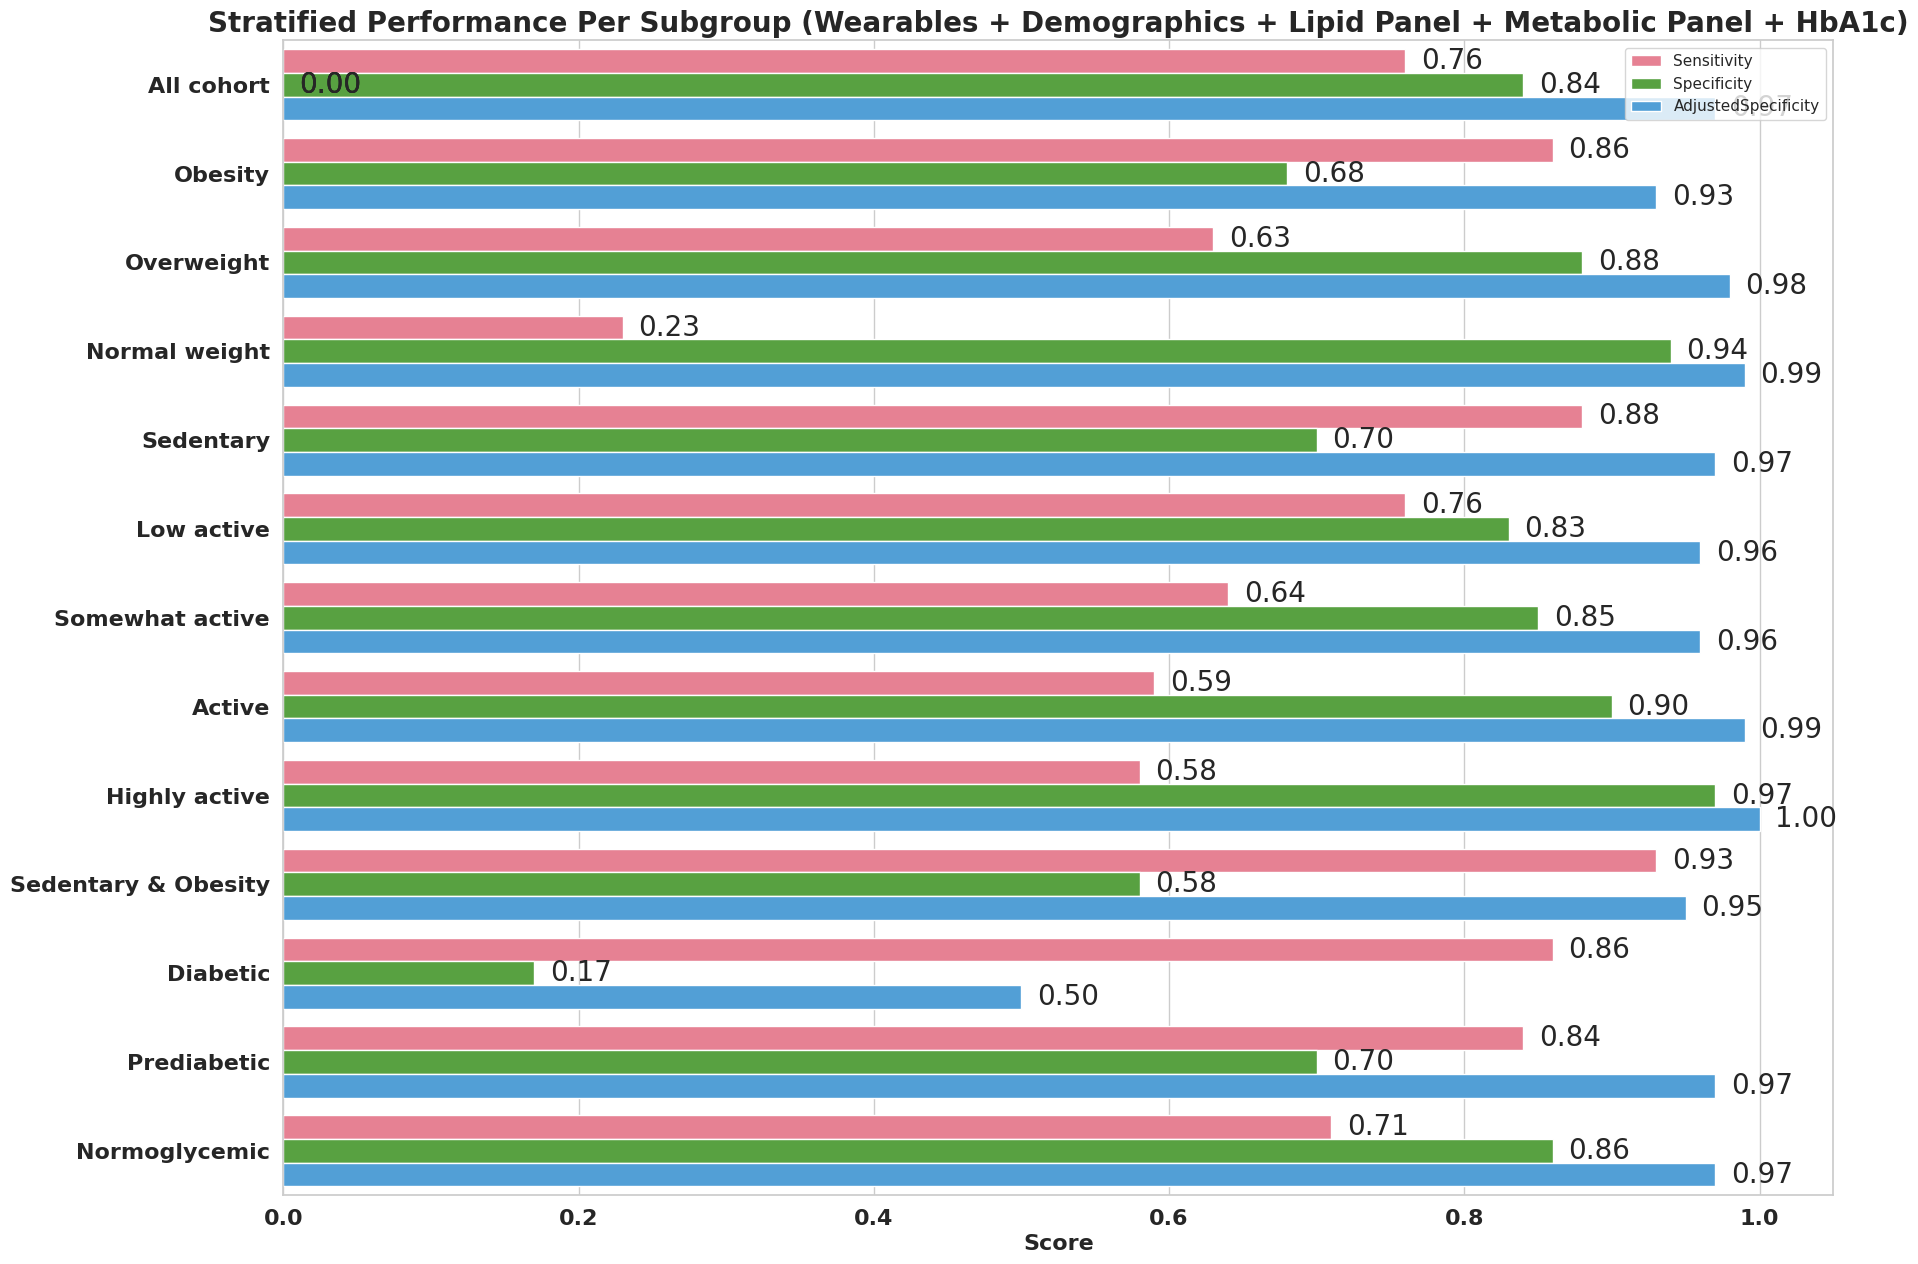

In [ ]:
#@title Do stratification for one experiment


# Concatenate all dataframes in the dictionary
homa_ir_prediction = dfs["EXP_11"]
# homa_ir_prediction = pd.concat(dfs.values(), ignore_index=True).reset_index(drop=True)
print(homa_ir_prediction.shape)

# Merge with labels, scores, and digital biomarkers
homa_ir_prediction_score_labels = homa_ir_prediction.merge(labels_and_scores_digital_biomarkers_cleaned, on='participant_id')
print(homa_ir_prediction_score_labels.shape)
homa_ir_prediction_score_labels.head()
# homa_ir_prediction_score_labels


# Apply Categorize based on HOMA-IR
homa_ir_prediction_score_labels['homa_ir_class_true'] = homa_ir_prediction_score_labels['true_values'].apply(categorize_homa_ir)
homa_ir_prediction_score_labels['homa_ir_class_predicted'] = homa_ir_prediction_score_labels['predicted_values'].apply(categorize_homa_ir)

# Apply the function to the BMI column to create a new column
homa_ir_prediction_score_labels['bmi_class'] = homa_ir_prediction_score_labels['bmi'].apply(categorize_bmi)

# Apply the function to the Step_Count column to create a new column
homa_ir_prediction_score_labels['physical_activity_class_steps'] = homa_ir_prediction_score_labels['STEPS_Daily_mean'].apply(categorize_activity)

# Aplpy Diabetes classification
homa_ir_prediction_score_labels['diabetes_class'] = homa_ir_prediction_score_labels['hba1c'].apply(categorize_diabetes)

stratified_perf_df = pd.DataFrame()

# print("All cohort")
subgroup_perf = calculate_performance(homa_ir_prediction_score_labels, subgroup="All cohort")
stratified_perf_df = pd.concat([stratified_perf_df, subgroup_perf], ignore_index=True)

# print("\n Obese")
subgroup_perf = calculate_performance(homa_ir_prediction_score_labels[homa_ir_prediction_score_labels["bmi_class"] == "Obesity"], subgroup="Obesity")
stratified_perf_df = pd.concat([stratified_perf_df, subgroup_perf], ignore_index=True)

# print("\n Overweight")
subgroup_perf = calculate_performance(homa_ir_prediction_score_labels[homa_ir_prediction_score_labels["bmi_class"] == "Overweight"], subgroup="Overweight")
stratified_perf_df = pd.concat([stratified_perf_df, subgroup_perf], ignore_index=True)

# print("\n Normal weight")
subgroup_perf = calculate_performance(homa_ir_prediction_score_labels[homa_ir_prediction_score_labels["bmi_class"] == "Normal weight"], subgroup="Normal weight")
stratified_perf_df = pd.concat([stratified_perf_df, subgroup_perf], ignore_index=True)

# print("\n Sedentary")
subgroup_perf = calculate_performance(homa_ir_prediction_score_labels[homa_ir_prediction_score_labels["physical_activity_class_steps"] == "Sedentary"], subgroup="Sedentary")
stratified_perf_df = pd.concat([stratified_perf_df, subgroup_perf], ignore_index=True)

# print("\n Low active")
subgroup_perf = calculate_performance(homa_ir_prediction_score_labels[homa_ir_prediction_score_labels["physical_activity_class_steps"] == "Low active"], subgroup="Low active")
stratified_perf_df = pd.concat([stratified_perf_df, subgroup_perf], ignore_index=True)


# print("\n Somewhat active")
subgroup_perf = calculate_performance(homa_ir_prediction_score_labels[homa_ir_prediction_score_labels["physical_activity_class_steps"] == "Somewhat active"], subgroup="Somewhat active")
stratified_perf_df = pd.concat([stratified_perf_df, subgroup_perf], ignore_index=True)


# print("\n Active")
subgroup_perf = calculate_performance(homa_ir_prediction_score_labels[homa_ir_prediction_score_labels["physical_activity_class_steps"] == "Active"],  subgroup="Active")
stratified_perf_df = pd.concat([stratified_perf_df, subgroup_perf], ignore_index=True)

# print("\n Highly active")
subgroup_perf = calculate_performance(homa_ir_prediction_score_labels[homa_ir_prediction_score_labels["physical_activity_class_steps"] == "Highly active"], subgroup="Highly active")
stratified_perf_df = pd.concat([stratified_perf_df, subgroup_perf], ignore_index=True)



## Do joint group
# print("\n Sedentary & Obese")
subgroup_perf = calculate_performance(homa_ir_prediction_score_labels[
    (homa_ir_prediction_score_labels["physical_activity_class_steps"] == "Sedentary")
    &
    (homa_ir_prediction_score_labels["bmi_class"] == "Obesity")
    ], subgroup="Sedentary & Obesity")
stratified_perf_df = pd.concat([stratified_perf_df, subgroup_perf], ignore_index=True)

# # Diabetes_Status
subgroup_perf = calculate_performance(homa_ir_prediction_score_labels[homa_ir_prediction_score_labels["diabetes_class"] == "Diabetic"], subgroup="Diabetic")
stratified_perf_df = pd.concat([stratified_perf_df, subgroup_perf], ignore_index=True)

# print("\n Prediabetic")
subgroup_perf = calculate_performance(homa_ir_prediction_score_labels[homa_ir_prediction_score_labels["diabetes_class"] == "Prediabetic"], subgroup="Prediabetic")
stratified_perf_df = pd.concat([stratified_perf_df, subgroup_perf], ignore_index=True)

# print("\n Normoglycemic")
subgroup_perf = calculate_performance(homa_ir_prediction_score_labels[homa_ir_prediction_score_labels["diabetes_class"] == "Normoglycemic"], subgroup="Normoglycemic")
stratified_perf_df = pd.concat([stratified_perf_df, subgroup_perf], ignore_index=True)

display(stratified_perf_df)

# Melt the DataFrame to a long format
df_melted = stratified_perf_df.melt(id_vars='Subgroup', value_vars=['Sensitivity', 'Specificity', 'AdjustedSpecificity'],
                    var_name='Metric', value_name='Score')

display(df_melted)

# Set the style of the visualization
sns.set(style="whitegrid")

# Create a figure and axis
fig, ax = plt.subplots(figsize=(20, 15))

# Define a custom color palette
palette = sns.color_palette("husl", n_colors=df_melted['Metric'].nunique())


# Create a bar plot
bar_plot = sns.barplot(x='Score', y='Subgroup', hue='Metric', data=df_melted, ax=ax, palette=palette)


# Add values to each bar
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_width(), '.2f'),
                      (p.get_width() + 0.02, p.get_y() + p.get_height() / 2),
                      ha='left', va='center',
                      xytext=(-10, 0), textcoords='offset points', fontsize=20)

# Adjust legend title
plt.legend(title='')


plt.title('Stratified Performance Per Subgroup (Wearables + Demographics + Lipid Panel + Metabolic Panel + HbA1c)', fontsize=20, weight='bold')
plt.xlabel('Score', fontsize=16, weight='bold')
plt.ylabel('', fontsize=16, weight='bold')



# Customize the ticks on x and y axis
plt.xticks(fontsize=16, weight='bold')
plt.yticks(fontsize=16, weight='bold')
plt.show()


EXP_1
(1173, 4)
(1165, 159)
subgroup: All cohort Sensitivity: 0.603 Specificity: 0.809 AdjustedSpecificity: 0.936 tn: 700 fp: 165 fp_adjusted: 48
Dimension =  (1165, 163)


participant_id  predicted_values  true_values Experiment_ID  \
89             13416          3.888096         0.53         EXP_1   
107            13533          3.553702         1.39         EXP_1   
126            13682          3.216861         0.62         EXP_1   
127            13684          3.293139         1.12         EXP_1   
131            13699          4.149108         1.22         EXP_1   
148            13790          3.899633         1.08         EXP_1   
149            13798          3.709531         1.46         EXP_1   
191            55870          2.909530         0.66         EXP_1   
245            56040          2.937281         0.83         EXP_1   
329            56423          3.723235         1.26         EXP_1   
347            56611          4.566972         1.31         EXP_1   
360            56691          2.966853         0.95         EXP_1   
365            56770          4.040501         1.20         EXP_1   
368            56821          3.576749         1.49         EXP_1   
377            56883          2.982001         1.18         EXP_1   
384            56921          4.010516         1.35         EXP_1   
405            57095          3.572981         1.32         EXP_1   
433            57276          3.381184         1.15         EXP_1   
455            57427          2.912212         0.86         EXP_1   
459            57470          3.357673         1.34         EXP_1   
461            57472          3.187740         1.13         EXP_1   
472            57531          3.280306         1.49         EXP_1   
474            57535          2.955417         0.73         EXP_1   
480            57568          4.031232         1.49         EXP_1   
497            57628          3.529645         1.17         EXP_1   
536            57853          4.217758         1.34         EXP_1   
556            58001          4.208014         1.27         EXP_1   
567            58094          2.971366         1.17         EXP_1   
810            71086          4.334139         0.96         EXP_1   
851            71553          3.024653         1.03         EXP_1   
927            72035          3.644340         0.94         EXP_1   
931            72049          2.968658         0.94         EXP_1   
942            72122          3.431630         1.26         EXP_1   
943            72123          3.539639         1.12         EXP_1   
951            72151          5.453225         1.07         EXP_1   
985            72346          2.956894         0.74         EXP_1   
992            72373          2.952999         0.92         EXP_1   
999            72393          3.357141         0.87         EXP_1   
1035           72623          3.094681         1.42         EXP_1   
1050           72721          2.986472         1.01         EXP_1   
1054           72753          3.077624         1.33         EXP_1   
1057           72772          5.213183         1.42         EXP_1   
1063           72816          3.286524         1.22         EXP_1   
1066           72832          3.326099         1.28         EXP_1   
1071           72913          3.791376         1.20         EXP_1   
1089           73107          3.294594         1.45         EXP_1   
1113           73242          3.086603         0.99         EXP_1   
1134          186174          3.268850         1.25         EXP_1   

      RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
89              77.402878                   77.0            2.875816   
107             65.360000                   65.0            2.374572   
126             75.814433                   76.0            2.993360   
127             67.201835                   68.0            2.814642   
131             77.881720                   77.0            3.277604   
148             78.827586                   79.0            2.779878   
149             71.153846                   71.0            1.333718   
191             71.257143                   71.0

subgroup: Obesity Sensitivity: 0.761 Specificity: 0.482 AdjustedSpecificity: 0.787 tn: 122 fp: 131 fp_adjusted: 33
Dimension =  (458, 163)


participant_id  predicted_values  true_values Experiment_ID  \
89             13416          3.888096         0.53         EXP_1   
107            13533          3.553702         1.39         EXP_1   
126            13682          3.216861         0.62         EXP_1   
127            13684          3.293139         1.12         EXP_1   
131            13699          4.149108         1.22         EXP_1   
148            13790          3.899633         1.08         EXP_1   
149            13798          3.709531         1.46         EXP_1   
191            55870          2.909530         0.66         EXP_1   
347            56611          4.566972         1.31         EXP_1   
360            56691          2.966853         0.95         EXP_1   
368            56821          3.576749         1.49         EXP_1   
384            56921          4.010516         1.35         EXP_1   
433            57276          3.381184         1.15         EXP_1   
461            57472          3.187740         1.13         EXP_1   
472            57531          3.280306         1.49         EXP_1   
480            57568          4.031232         1.49         EXP_1   
497            57628          3.529645         1.17         EXP_1   
536            57853          4.217758         1.34         EXP_1   
556            58001          4.208014         1.27         EXP_1   
810            71086          4.334139         0.96         EXP_1   
927            72035          3.644340         0.94         EXP_1   
942            72122          3.431630         1.26         EXP_1   
951            72151          5.453225         1.07         EXP_1   
992            72373          2.952999         0.92         EXP_1   
999            72393          3.357141         0.87         EXP_1   
1054           72753          3.077624         1.33         EXP_1   
1057           72772          5.213183         1.42         EXP_1   
1063           72816          3.286524         1.22         EXP_1   
1066           72832          3.326099         1.28         EXP_1   
1071           72913          3.791376         1.20         EXP_1   
1089           73107          3.294594         1.45         EXP_1   
1113           73242          3.086603         0.99         EXP_1   
1134          186174          3.268850         1.25         EXP_1   

      RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
89              77.402878                   77.0            2.875816   
107             65.360000                   65.0            2.374572   
126             75.814433                   76.0            2.993360   
127             67.201835                   68.0            2.814642   
131             77.881720                   77.0            3.277604   
148             78.827586                   79.0            2.779878   
149             71.153846                   71.0            1.333718   
191             71.257143                   71.0            4.159565   
347             62.203704                   62.5            2.198347   
360             70.692308                   71.0            1.911455   
368             85.080000                   85.0            2.862616   
384             71.563636                   72.0            2.168800   
433             74.676259                   74.0            3.674904   
461             73.363636                   74.0            3.800760   
472             62.979592                   63.0            2.754873   
480             82.628866                   82.0            2.503136   
497             64.427350                   65.0            2.601803   
536             75.474747                   75.0            4.244658   
556             76.830508                   77.0            2.257112   
810             64.117647                   65.0            3.584252   
927             68.049020                   68.0            1.732776   
942             75.435644                   75.0            1.701131   
951

subgroup: Overweight Sensitivity: 0.315 Specificity: 0.911 AdjustedSpecificity: 0.965 tn: 278 fp: 27 fp_adjusted: 10
Dimension =  (378, 163)


participant_id  predicted_values  true_values Experiment_ID  \
245            56040          2.937281         0.83         EXP_1   
365            56770          4.040501         1.20         EXP_1   
459            57470          3.357673         1.34         EXP_1   
474            57535          2.955417         0.73         EXP_1   
567            58094          2.971366         1.17         EXP_1   
851            71553          3.024653         1.03         EXP_1   
931            72049          2.968658         0.94         EXP_1   
943            72123          3.539639         1.12         EXP_1   
985            72346          2.956894         0.74         EXP_1   
1035           72623          3.094681         1.42         EXP_1   

      RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
245             58.833333                   59.0            2.959513   
365             64.361446                   64.0            2.603393   
459             67.400000                   68.0            3.674821   
474             53.891304                   54.0            1.946857   
567             72.410256                   73.0            2.627533   
851             72.118182                   72.0            1.801733   
931             73.699029                   74.0            2.446839   
943             87.588889                   87.5            2.236790   
985             74.936170                   76.0            2.850306   
1035            69.895652                   70.0            3.930341   

      HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
245             21.238897                20.8670            4.079245  ...   
365             44.979500                44.9795            0.189948  ...   
459              7.300823                 8.3020            9.755408  ...   
474             29.699310                37.4060           28.327224  ...   
567             13.801207                13.6180            2.943417  ...   
851             21.177291                21.5170            3.042877  ...   
931             56.869029                55.4320           10.780135  ...   
943             12.009691                12.1110            4.779979  ...   
985             20.498358                21.0700            5.003998  ...   
1035            12.013918                11.6650            1.972425  ...   

      ascvd_risk  ascvd_risk_category  optimal_ascvd_risk      apri  \
245          NaN                 None                 NaN  0.263331   
365          NaN                 None                 NaN  0.183150   
459          NaN                 None                 NaN  0.301860   
474          NaN                 None                 NaN  0.207792   
567          NaN                 None                 NaN  0.159172   
851          NaN                 None                 NaN  0.198251   
931          NaN                 None                 NaN  0.158213   
943          NaN                 None                 NaN  0.228137   
985          NaN                 None                 NaN  0.110957   
1035         NaN                 None                 NaN  0.353982   

      hypertension_binary  Diabetes_Status  homa_ir_class_true  \
245                     1    Normoglycemic                   0   
365                     0    Normoglycemic                   0   
459                     0    Normoglycemic                   0   
474                     0    Normoglycemic                   0   
567                     0    Normoglycemic                   0   
851                     1    Normoglycemic                   0   
931                     0    Normoglycemic                   0   
943                     0    Normoglycemic                   0   
985                     0    Normoglycemic                   0   
1035                    1    Normoglycemic                   0   

      homa_ir_class_predicted   bmi_class  physical_activity_class_steps  
245                  

subgroup: Normal weight Sensitivity: 0.091 Specificity: 0.98 AdjustedSpecificity: 0.986 tn: 291 fp: 6 fp_adjusted: 4
Dimension =  (319, 163)


participant_id  predicted_values  true_values Experiment_ID  \
329            56423          3.723235         1.26         EXP_1   
377            56883          2.982001         1.18         EXP_1   
405            57095          3.572981         1.32         EXP_1   
1050           72721          2.986472         1.01         EXP_1   

      RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
329             60.723404                   61.0            1.996812   
377             71.947368                   72.0            6.800652   
405             88.716216                   86.0            6.697589   
1050            82.342857                   83.0            3.267437   

      HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
329             31.760750                31.5340            4.281818  ...   
377             46.354786                36.1585           47.186600  ...   
405             20.549528                22.4910            5.755420  ...   
1050            10.112648                 9.1615            2.545401  ...   

      ascvd_risk  ascvd_risk_category  optimal_ascvd_risk      apri  \
329          NaN                 None                 NaN  0.380952   
377          NaN                 None                 NaN  0.502092   
405          NaN                 None                 NaN  0.786997   
1050         NaN                 None                 NaN  0.150905   

      hypertension_binary  Diabetes_Status  homa_ir_class_true  \
329                     0    Normoglycemic                   0   
377                     0    Normoglycemic                   0   
405                     0    Normoglycemic                   0   
1050                    0    Normoglycemic                   0   

      homa_ir_class_predicted      bmi_class  physical_activity_class_steps  
329                         1  Normal weight                         Active  
377                         1  Normal weight                     Low active  
405                         1  Normal weight                     Low active  
1050                        1  Normal weight                     Low active  

[4 rows x 163 columns]

subgroup: Sedentary Sensitivity: 0.894 Specificity: 0.469 AdjustedSpecificity: 0.822 tn: 60 fp: 68 fp_adjusted: 13
Dimension =  (232, 163)


participant_id  predicted_values  true_values Experiment_ID  \
107            13533          3.553702         1.39         EXP_1   
131            13699          4.149108         1.22         EXP_1   
148            13790          3.899633         1.08         EXP_1   
433            57276          3.381184         1.15         EXP_1   
455            57427          2.912212         0.86         EXP_1   
461            57472          3.187740         1.13         EXP_1   
474            57535          2.955417         0.73         EXP_1   
556            58001          4.208014         1.27         EXP_1   
810            71086          4.334139         0.96         EXP_1   
927            72035          3.644340         0.94         EXP_1   
942            72122          3.431630         1.26         EXP_1   
1071           72913          3.791376         1.20         EXP_1   
1089           73107          3.294594         1.45         EXP_1   

      RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
107             65.360000                   65.0            2.374572   
131             77.881720                   77.0            3.277604   
148             78.827586                   79.0            2.779878   
433             74.676259                   74.0            3.674904   
455             63.010417                   63.0            0.101795   
461             73.363636                   74.0            3.800760   
474             53.891304                   54.0            1.946857   
556             76.830508                   77.0            2.257112   
810             64.117647                   65.0            3.584252   
927             68.049020                   68.0            1.732776   
942             75.435644                   75.0            1.701131   
1071            69.540000                   70.0            3.038844   
1089            70.386667                   70.0            3.615379   

      HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
107             33.529189                33.7865            5.763363  ...   
131             19.084679                18.7695            6.289622  ...   
148             15.268419                14.8550            2.773114  ...   
433             23.734794                21.9465            8.130723  ...   
455             11.534516                11.2110            2.976247  ...   
461             22.949364                23.5020            6.938473  ...   
474             29.699310                37.4060           28.327224  ...   
556             12.007664                11.5580            1.960277  ...   
810             36.291261                35.8070            7.278590  ...   
927             20.387867                21.7910            6.079120  ...   
942             13.147250                12.8785            1.882081  ...   
1071            30.251689                29.8250           22.836625  ...   
1089            36.990241                37.0445           11.965214  ...   

      ascvd_risk  ascvd_risk_category  optimal_ascvd_risk      apri  \
107          NaN                 None                 NaN  0.185830   
131          NaN                 None                 NaN  0.094271   
148          NaN                 None                 NaN  0.233463   
433          NaN                 None                 NaN  0.168729   
455          NaN                 None                 NaN  0.300752   
461          NaN                 None                 NaN  0.128051   
474          NaN                 None                 NaN  0.207792   
556          NaN                 None                 NaN  0.118636   
810          NaN                 None                 NaN  0.183288   
927          NaN                 None                 NaN  0.139112   
942          NaN                 None                 NaN  0.174717   
1071         NaN                 None                 NaN  0.205714   
1089         NaN            

subgroup: Low active Sensitivity: 0.604 Specificity: 0.767 AdjustedSpecificity: 0.909 tn: 211 fp: 64 fp_adjusted: 21
Dimension =  (376, 163)


participant_id  predicted_values  true_values Experiment_ID  \
89             13416          3.888096         0.53         EXP_1   
126            13682          3.216861         0.62         EXP_1   
127            13684          3.293139         1.12         EXP_1   
191            55870          2.909530         0.66         EXP_1   
245            56040          2.937281         0.83         EXP_1   
347            56611          4.566972         1.31         EXP_1   
360            56691          2.966853         0.95         EXP_1   
377            56883          2.982001         1.18         EXP_1   
384            56921          4.010516         1.35         EXP_1   
405            57095          3.572981         1.32         EXP_1   
472            57531          3.280306         1.49         EXP_1   
497            57628          3.529645         1.17         EXP_1   
536            57853          4.217758         1.34         EXP_1   
851            71553          3.024653         1.03         EXP_1   
931            72049          2.968658         0.94         EXP_1   
992            72373          2.952999         0.92         EXP_1   
1035           72623          3.094681         1.42         EXP_1   
1050           72721          2.986472         1.01         EXP_1   
1054           72753          3.077624         1.33         EXP_1   
1057           72772          5.213183         1.42         EXP_1   
1134          186174          3.268850         1.25         EXP_1   

      RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
89              77.402878                   77.0            2.875816   
126             75.814433                   76.0            2.993360   
127             67.201835                   68.0            2.814642   
191             71.257143                   71.0            4.159565   
245             58.833333                   59.0            2.959513   
347             62.203704                   62.5            2.198347   
360             70.692308                   71.0            1.911455   
377             71.947368                   72.0            6.800652   
384             71.563636                   72.0            2.168800   
405             88.716216                   86.0            6.697589   
472             62.979592                   63.0            2.754873   
497             64.427350                   65.0            2.601803   
536             75.474747                   75.0            4.244658   
851             72.118182                   72.0            1.801733   
931             73.699029                   74.0            2.446839   
992             56.474026                   56.0            2.660357   
1035            69.895652                   70.0            3.930341   
1050            82.342857                   83.0            3.267437   
1054            56.755556                   57.0            2.012870   
1057            77.415842                   77.0            2.563686   
1134            60.568421                   60.0            1.838176   

      HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
89              14.678854                13.7330            4.083493  ...   
126             16.265194                15.7760            3.644277  ...   
127             21.716717                21.6640            4.170199  ...   
191             62.205130                63.7720           15.867430  ...   
245             21.238897                20.8670            4.079245  ...   
347             28.585029                28.5300            6.527487  ...   
360             23.704694                24.2550            6.534843  ...   
377             46.354786                36.1585           47.186600  ...   
384             17.900327                18.0995            3.762211  ...   
405             20.549528                22.4910            5.755420  ...   
472             53.220957                53.8650       

subgroup: Somewhat active Sensitivity: 0.333 Specificity: 0.915 AdjustedSpecificity: 0.966 tn: 226 fp: 21 fp_adjusted: 8
Dimension =  (313, 163)


participant_id  predicted_values  true_values Experiment_ID  \
149            13798          3.709531         1.46         EXP_1   
365            56770          4.040501         1.20         EXP_1   
480            57568          4.031232         1.49         EXP_1   
567            58094          2.971366         1.17         EXP_1   
943            72123          3.539639         1.12         EXP_1   
951            72151          5.453225         1.07         EXP_1   
985            72346          2.956894         0.74         EXP_1   
1063           72816          3.286524         1.22         EXP_1   

      RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
149             71.153846                   71.0            1.333718   
365             64.361446                   64.0            2.603393   
480             82.628866                   82.0            2.503136   
567             72.410256                   73.0            2.627533   
943             87.588889                   87.5            2.236790   
951             79.828571                   79.0            3.869788   
985             74.936170                   76.0            2.850306   
1063            68.165217                   68.0            1.596560   

      HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
149             15.987187                15.4875            3.364514  ...   
365             44.979500                44.9795            0.189948  ...   
480             19.980969                20.0855            4.612247  ...   
567             13.801207                13.6180            2.943417  ...   
943             12.009691                12.1110            4.779979  ...   
951             23.468922                27.0155           11.959427  ...   
985             20.498358                21.0700            5.003998  ...   
1063            29.555606                28.7260            9.637907  ...   

      ascvd_risk  ascvd_risk_category  optimal_ascvd_risk      apri  \
149          NaN                 None                 NaN  0.223048   
365          NaN                 None                 NaN  0.183150   
480          NaN                 None                 NaN  0.150376   
567          NaN                 None                 NaN  0.159172   
943          NaN                 None                 NaN  0.228137   
951          NaN                 None                 NaN  0.551378   
985          NaN                 None                 NaN  0.110957   
1063         NaN                 None                 NaN  0.185387   

      hypertension_binary  Diabetes_Status  homa_ir_class_true  \
149                     0    Normoglycemic                   0   
365                     0    Normoglycemic                   0   
480                     0    Normoglycemic                   0   
567                     0    Normoglycemic                   0   
943                     0    Normoglycemic                   0   
951                     0    Normoglycemic                   0   
985                     0    Normoglycemic                   0   
1063                    0    Normoglycemic                   0   

      homa_ir_class_predicted   bmi_class  physical_activity_class_steps  
149                         1     Obesity                Somewhat active  
365                         1  Overweight                Somewhat active  
480                         1     Obesity                Somewhat active  
567                         1  Overweight                Somewhat active  
943                         1  Overweight                Somewhat active  
951                         1     Obesity                Somewhat active  
985                         1  Overweight                Somewhat active  
1063                        1     Obesity                Somewhat active  

[8 rows x 163 columns]

subgroup: Active Sensitivity: 0.294 Specificity: 0.929 AdjustedSpecificity: 0.967 tn: 118 fp: 9 fp_adjusted: 4
Dimension =  (144, 163)


participant_id  predicted_values  true_values Experiment_ID  \
329            56423          3.723235         1.26         EXP_1   
368            56821          3.576749         1.49         EXP_1   
999            72393          3.357141         0.87         EXP_1   
1066           72832          3.326099         1.28         EXP_1   

      RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
329             60.723404                   61.0            1.996812   
368             85.080000                   85.0            2.862616   
999             52.191919                   52.0            1.519262   
1066            73.170543                   73.0            2.623225   

      HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
329             31.760750                 31.534            4.281818  ...   
368             16.940062                 13.458           12.915372  ...   
999            103.814337                122.244           49.835497  ...   
1066            12.802034                 12.628            2.826280  ...   

      ascvd_risk  ascvd_risk_category  optimal_ascvd_risk      apri  \
329          NaN                 None                 NaN  0.380952   
368          NaN                 None                 NaN  0.213971   
999          NaN                 None                 NaN  0.203046   
1066         NaN                 None                 NaN  0.170213   

      hypertension_binary  Diabetes_Status  homa_ir_class_true  \
329                     0    Normoglycemic                   0   
368                     0    Normoglycemic                   0   
999                     0    Normoglycemic                   0   
1066                    0         Diabetic                   0   

      homa_ir_class_predicted      bmi_class  physical_activity_class_steps  
329                         1  Normal weight                         Active  
368                         1        Obesity                         Active  
999                         1        Obesity                         Active  
1066                        1        Obesity                         Active  

[4 rows x 163 columns]

subgroup: Highly active Sensitivity: 0.0 Specificity: 0.966 AdjustedSpecificity: 0.977 tn: 85 fp: 3 fp_adjusted: 2
Dimension =  (100, 163)


participant_id  predicted_values  true_values Experiment_ID  \
459            57470          3.357673         1.34         EXP_1   
1113           73242          3.086603         0.99         EXP_1   

      RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
459             67.400000                   68.0            3.674821   
1113            80.813084                   81.0            3.005881   

      HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
459              7.300823                  8.302            9.755408  ...   
1113            27.150825                 26.189            6.596052  ...   

      ascvd_risk  ascvd_risk_category  optimal_ascvd_risk      apri  \
459          NaN                 None                 NaN  0.301860   
1113         NaN                 None                 NaN  0.181087   

      hypertension_binary  Diabetes_Status  homa_ir_class_true  \
459                     0    Normoglycemic                   0   
1113                    0    Normoglycemic                   0   

      homa_ir_class_predicted   bmi_class  physical_activity_class_steps  
459                         1  Overweight                  Highly active  
1113                        1     Obesity                  Highly active  

[2 rows x 163 columns]

subgroup: Sedentary & Obesity Sensitivity: 0.94 Specificity: 0.141 AdjustedSpecificity: 0.45 tn: 9 fp: 55 fp_adjusted: 11
Dimension =  (147, 163)


participant_id  predicted_values  true_values Experiment_ID  \
107            13533          3.553702         1.39         EXP_1   
131            13699          4.149108         1.22         EXP_1   
148            13790          3.899633         1.08         EXP_1   
433            57276          3.381184         1.15         EXP_1   
461            57472          3.187740         1.13         EXP_1   
556            58001          4.208014         1.27         EXP_1   
810            71086          4.334139         0.96         EXP_1   
927            72035          3.644340         0.94         EXP_1   
942            72122          3.431630         1.26         EXP_1   
1071           72913          3.791376         1.20         EXP_1   
1089           73107          3.294594         1.45         EXP_1   

      RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
107             65.360000                   65.0            2.374572   
131             77.881720                   77.0            3.277604   
148             78.827586                   79.0            2.779878   
433             74.676259                   74.0            3.674904   
461             73.363636                   74.0            3.800760   
556             76.830508                   77.0            2.257112   
810             64.117647                   65.0            3.584252   
927             68.049020                   68.0            1.732776   
942             75.435644                   75.0            1.701131   
1071            69.540000                   70.0            3.038844   
1089            70.386667                   70.0            3.615379   

      HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
107             33.529189                33.7865            5.763363  ...   
131             19.084679                18.7695            6.289622  ...   
148             15.268419                14.8550            2.773114  ...   
433             23.734794                21.9465            8.130723  ...   
461             22.949364                23.5020            6.938473  ...   
556             12.007664                11.5580            1.960277  ...   
810             36.291261                35.8070            7.278590  ...   
927             20.387867                21.7910            6.079120  ...   
942             13.147250                12.8785            1.882081  ...   
1071            30.251689                29.8250           22.836625  ...   
1089            36.990241                37.0445           11.965214  ...   

      ascvd_risk  ascvd_risk_category  optimal_ascvd_risk      apri  \
107          NaN                 None                 NaN  0.185830   
131          NaN                 None                 NaN  0.094271   
148          NaN                 None                 NaN  0.233463   
433          NaN                 None                 NaN  0.168729   
461          NaN                 None                 NaN  0.128051   
556          NaN                 None                 NaN  0.118636   
810          NaN                 None                 NaN  0.183288   
927          NaN                 None                 NaN  0.139112   
942          NaN                 None                 NaN  0.174717   
1071         NaN                 None                 NaN  0.205714   
1089         NaN                 None                 NaN  0.178571   

      hypertension_binary  Diabetes_Status  homa_ir_class_true  \
107                     1    Normoglycemic                   0   
131                     0    Normoglycemic                   0   
148                     0    Normoglycemic                   0   
433                     0    Normoglycemic                   0   
461                     0    Normoglycemic                   0   
556                     1    Normoglycemic                   0   
810                     0      Prediabetic                   0   
927   

Subgroup  Sensitivity  Specificity  AdjustedSpecificity
0           All cohort         0.60         0.81                 0.94
1              Obesity         0.76         0.48                 0.79
2           Overweight         0.32         0.91                 0.96
3        Normal weight         0.09         0.98                 0.99
4            Sedentary         0.89         0.47                 0.82
5           Low active         0.60         0.77                 0.91
6      Somewhat active         0.33         0.92                 0.97
7               Active         0.29         0.93                 0.97
8        Highly active         0.00         0.97                 0.98
9  Sedentary & Obesity         0.94         0.14                 0.45

Subgroup               Metric  Score
0            All cohort          Sensitivity   0.60
1               Obesity          Sensitivity   0.76
2            Overweight          Sensitivity   0.32
3         Normal weight          Sensitivity   0.09
4             Sedentary          Sensitivity   0.89
5            Low active          Sensitivity   0.60
6       Somewhat active          Sensitivity   0.33
7                Active          Sensitivity   0.29
8         Highly active          Sensitivity   0.00
9   Sedentary & Obesity          Sensitivity   0.94
10           All cohort          Specificity   0.81
11              Obesity          Specificity   0.48
12           Overweight          Specificity   0.91
13        Normal weight          Specificity   0.98
14            Sedentary          Specificity   0.47
15           Low active          Specificity   0.77
16      Somewhat active          Specificity   0.92
17               Active          Specificity   0.93
18        Highly active          Specificity   0.97
19  Sedentary & Obesity          Specificity   0.14
20           All cohort  AdjustedSpecificity   0.94
21              Obesity  AdjustedSpecificity   0.79
22           Overweight  AdjustedSpecificity   0.96
23        Normal weight  AdjustedSpecificity   0.99
24            Sedentary  AdjustedSpecificity   0.82
25           Low active  AdjustedSpecificity   0.91
26      Somewhat active  AdjustedSpecificity   0.97
27               Active  AdjustedSpecificity   0.97
28        Highly active  AdjustedSpecificity   0.98
29  Sedentary & Obesity  AdjustedSpecificity   0.45

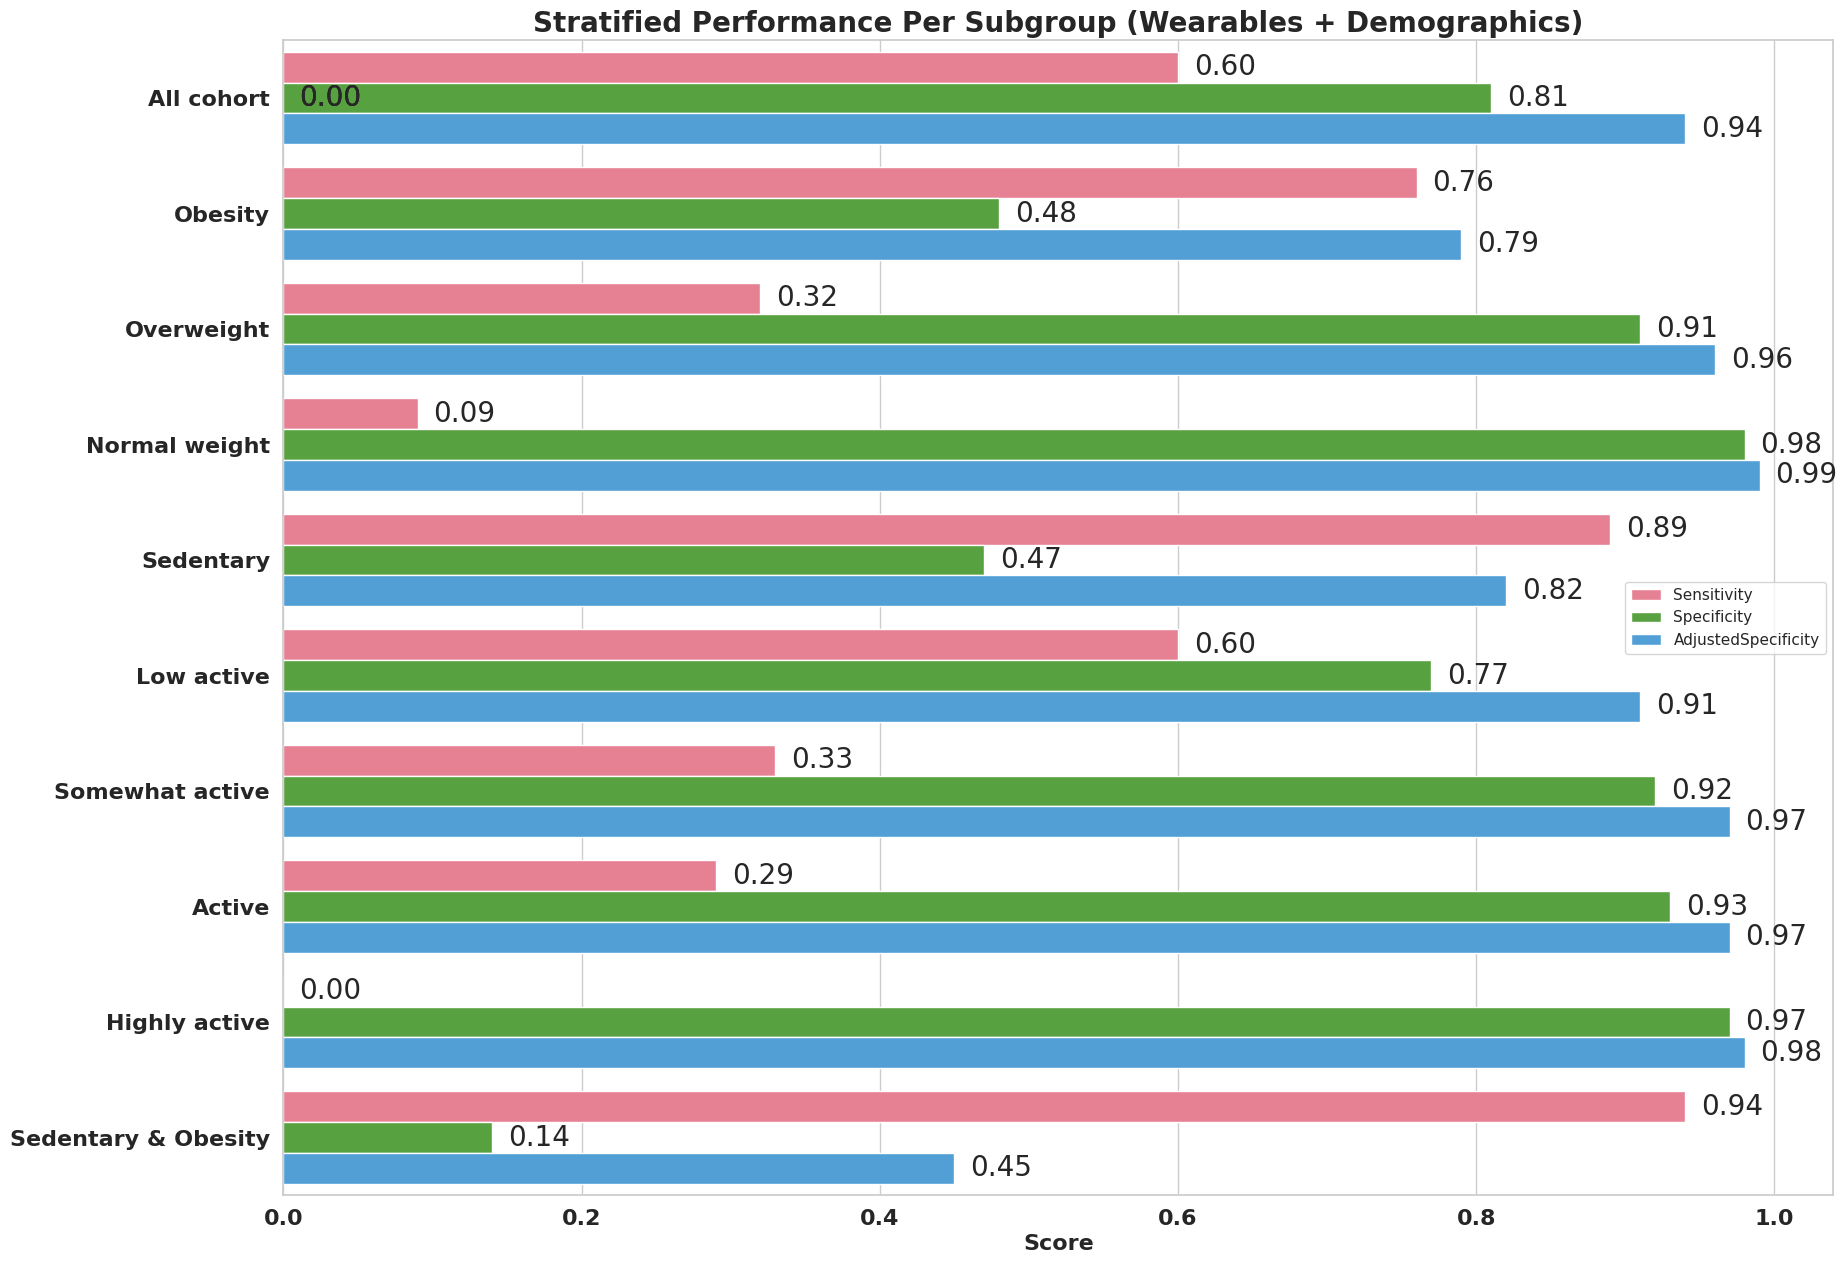

EXP_4
(1173, 4)
(1165, 159)
subgroup: All cohort Sensitivity: 0.65 Specificity: 0.762 AdjustedSpecificity: 0.909 tn: 659 fp: 206 fp_adjusted: 66
Dimension =  (1165, 163)


participant_id  predicted_values  true_values Experiment_ID  \
2              12599          2.974366         0.67         EXP_4   
10             12695          2.910835         1.11         EXP_4   
41             13086          2.938788         0.82         EXP_4   
89             13416          2.987699         0.53         EXP_4   
107            13533          2.996971         1.39         EXP_4   
...              ...               ...          ...           ...   
1063           72816          3.317642         1.22         EXP_4   
1071           72913          3.127784         1.20         EXP_4   
1089           73107          3.341362         1.45         EXP_4   
1113           73242          3.252289         0.99         EXP_4   
1134          186174          3.558940         1.25         EXP_4   

      RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
2               65.168421                   64.0            4.636302   
10              65.194690                   66.0            2.783630   
41              67.875000                   68.0            2.167103   
89              77.402878                   77.0            2.875816   
107             65.360000                   65.0            2.374572   
...                   ...                    ...                 ...   
1063            68.165217                   68.0            1.596560   
1071            69.540000                   70.0            3.038844   
1089            70.386667                   70.0            3.615379   
1113            80.813084                   81.0            3.005881   
1134            60.568421                   60.0            1.838176   

      HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
2               42.677238                43.4890           10.082448  ...   
10              28.858954                28.8125            6.840024  ...   
41              24.713469                25.2560            5.156692  ...   
89              14.678854                13.7330            4.083493  ...   
107             33.529189                33.7865            5.763363  ...   
...                   ...                    ...                 ...  ...   
1063            29.555606                28.7260            9.637907  ...   
1071            30.251689                29.8250           22.836625  ...   
1089            36.990241                37.0445           11.965214  ...   
1113            27.150825                26.1890            6.596052  ...   
1134            44.367074                44.3680            7.626330  ...   

      ascvd_risk  ascvd_risk_category  optimal_ascvd_risk      apri  \
2            NaN                 None                 NaN  0.214918   
10           NaN                 None                 NaN  0.107239   
41           NaN                 None                 NaN  0.204082   
89           NaN                 None                 NaN  0.207039   
107          NaN                 None                 NaN  0.185830   
...          ...                  ...                 ...       ...   
1063         NaN                 None                 NaN  0.185387   
1071         NaN                 None                 NaN  0.205714   
1089         NaN                 None                 NaN  0.178571   
1113         NaN                 None                 NaN  0.181087   
1134         NaN                 None                 NaN  0.432331   

      hypertension_binary  Diabetes_Status  homa_ir_class_true  \
2                       0    Normoglycemic                   0   
10                      1    Normoglycemic                   0   
41                      1    Normoglycemic                   0   
89                      0    Normoglycemic                   0   
107                     1    Normoglycemic                   0   
...                   ...              ...                 ...   
1063                    0    Normoglycemic                   0   
1071  

subgroup: Obesity Sensitivity: 0.883 Specificity: 0.237 AdjustedSpecificity: 0.5 tn: 60 fp: 193 fp_adjusted: 60
Dimension =  (458, 163)


participant_id  predicted_values  true_values Experiment_ID  \
2              12599          2.974366         0.67         EXP_4   
10             12695          2.910835         1.11         EXP_4   
41             13086          2.938788         0.82         EXP_4   
89             13416          2.987699         0.53         EXP_4   
107            13533          2.996971         1.39         EXP_4   
110            13559          3.094372         1.43         EXP_4   
126            13682          2.940636         0.62         EXP_4   
127            13684          3.091521         1.12         EXP_4   
148            13790          3.064629         1.08         EXP_4   
149            13798          3.136844         1.46         EXP_4   
151            13818          2.915968         1.37         EXP_4   
191            55870          2.934171         0.66         EXP_4   
328            56418          3.200050         0.77         EXP_4   
343            56570          2.975732         0.74         EXP_4   
347            56611          4.551072         1.31         EXP_4   
353            56655          2.991112         0.71         EXP_4   
360            56691          2.908656         0.95         EXP_4   
368            56821          3.264070         1.49         EXP_4   
384            56921          3.379392         1.35         EXP_4   
421            57219          2.980550         0.75         EXP_4   
433            57276          2.949641         1.15         EXP_4   
444            57331          3.432307         1.37         EXP_4   
472            57531          3.222393         1.49         EXP_4   
480            57568          3.472682         1.49         EXP_4   
497            57628          3.152043         1.17         EXP_4   
517            57689          3.006855         1.13         EXP_4   
525            57813          2.933876         0.96         EXP_4   
536            57853          3.691986         1.34         EXP_4   
537            57855          3.316049         1.41         EXP_4   
550            57972          2.970387         0.47         EXP_4   
556            58001          3.347174         1.27         EXP_4   
590            58344          3.177608         0.74         EXP_4   
654            70299          3.016744         1.06         EXP_4   
658            70307          3.160740         1.11         EXP_4   
678            70355          2.922882         1.23         EXP_4   
684            70374          2.960975         0.86         EXP_4   
698            70413          2.953789         1.37         EXP_4   
705            70433          2.976104         1.43         EXP_4   
721            70480          3.113921         1.12         EXP_4   
731            70519          3.151160         1.48         EXP_4   
755            70584          2.903715         1.18         EXP_4   
810            71086          3.579058         0.96         EXP_4   
888            71744          3.233765         1.41         EXP_4   
903            71839          2.982627         0.95         EXP_4   
927            72035          3.181338         0.94         EXP_4   
929            72046          2.968411         1.23         EXP_4   
942            72122          3.223053         1.26         EXP_4   
951            72151          4.123099         1.07         EXP_4   
954            72163          3.268718         0.50         EXP_4   
992            72373          3.306892         0.92         EXP_4   
999            72393          3.351953         0.87         EXP_4   
1016           72480          3.353763         1.02         EXP_4   
1036           72625          2.968824         1.46         EXP_4   
1054           72753          3.466329         1.33         EXP_4   
1057           72772          4.047731         1.42         EXP_4   
1063           72816          3.317642         1.22         EXP_4   
1071           72913          3.127784         1.20         EXP_4   
1089

subgroup: Overweight Sensitivity: 0.192 Specificity: 0.957 AdjustedSpecificity: 0.98 tn: 292 fp: 13 fp_adjusted: 6
Dimension =  (378, 163)


participant_id  predicted_values  true_values Experiment_ID  \
152            13819          2.942750         0.72         EXP_4   
299            56203          3.057026         1.15         EXP_4   
382            56918          2.999326         1.38         EXP_4   
851            71553          2.969235         1.03         EXP_4   
1001           72399          3.079623         0.91         EXP_4   
1010           72450          2.978788         1.34         EXP_4   

      RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
152             57.797980                   58.0            2.146795   
299             71.382353                   71.0            2.378243   
382             63.020619                   63.0            2.168925   
851             72.118182                   72.0            1.801733   
1001            59.495050                   59.0            1.574825   
1010            59.290598                   59.0            2.959120   

      HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
152             16.404041                16.1420            4.429918  ...   
299             18.483122                18.7355            3.172258  ...   
382             37.319521                36.9485            8.762630  ...   
851             21.177291                21.5170            3.042877  ...   
1001            15.750675                15.5065            4.003791  ...   
1010            40.592556                38.4170            9.744337  ...   

      ascvd_risk  ascvd_risk_category  optimal_ascvd_risk      apri  \
152          NaN                 None                 NaN  0.242692   
299          NaN                 None                 NaN  0.213358   
382          NaN                 None                 NaN  0.338983   
851          NaN                 None                 NaN  0.198251   
1001         NaN                 None                 NaN  0.188994   
1010         NaN                 None                 NaN  0.192400   

      hypertension_binary  Diabetes_Status  homa_ir_class_true  \
152                     1    Normoglycemic                   0   
299                     0    Normoglycemic                   0   
382                     0    Normoglycemic                   0   
851                     1    Normoglycemic                   0   
1001                    0      Prediabetic                   0   
1010                    0      Prediabetic                   0   

      homa_ir_class_predicted   bmi_class  physical_activity_class_steps  
152                         1  Overweight                     Low active  
299                         1  Overweight                Somewhat active  
382                         1  Overweight                Somewhat active  
851                         1  Overweight                     Low active  
1001                        1  Overweight                      Sedentary  
1010                        1  Overweight                Somewhat active  

[6 rows x 163 columns]

subgroup: Normal weight Sensitivity: 0.0 Specificity: 1.0 AdjustedSpecificity: 1.0 tn: 297 fp: 0 fp_adjusted: 0
Dimension =  (319, 163)


Empty DataFrame
Columns: [participant_id, predicted_values, true_values, Experiment_ID, RHR_FreeLiving_mean, RHR_FreeLiving_median, RHR_FreeLiving_std, HRV_FreeLiving_mean, HRV_FreeLiving_median, HRV_FreeLiving_std, STEPS_Daily_mean, STEPS_Daily_median, STEPS_Daily_std, SLEEP_Duration_mean, SLEEP_Duration_median, SLEEP_Duration_std, total cholesterol, hdl, triglycerides, ldl, chol/hdl, non hdl, glucose, bun, creatinine, egfr, sodium, potassium, chloride, co2, calcium, total protein, albumin, globulin, albumin/globulin, total bilirubin, alp, ast, alt, hba1c, insulin, crp, white_blood_cell, red_blood_cell, hb, hematocrit, mcv, mch, mchc, rdw, platelet, mpv, absolute_neutrophils, absolute_lymphocytes, absolute_monocytes, absolute_eosinophils, absolute_basophils, neutrophils, lymphocytes, monocytes, eosinophils, basophils, ggt, total testosterone, time, bun/creatinine, HEMOGLOBIN A1c, ALT, collection_hour_UTC, hdl_reported, a1c_date, a1c_reported, age, anxiety_or_depression_date, blood_pressure_date, cardiovascular_disease_date, cholesterol_date, contraceptives, diabetes_date, diabetes_medications, diabetes_type, diastolic_bp, employment_status, fasting_glucose_date, glucose_reported, sex, height, high_cholesterol_date, highest_education, household_income, hypertension_date, kidney_condition_date, marital_status, medications, menstruation, other_diagnosed_conditions, ethnicity, regular_periods, respiratory_condition_date, systolic_bp, ...]
Index: []

[0 rows x 163 columns]

subgroup: Sedentary Sensitivity: 0.798 Specificity: 0.602 AdjustedSpecificity: 0.856 tn: 77 fp: 51 fp_adjusted: 13
Dimension =  (232, 163)


participant_id  predicted_values  true_values Experiment_ID  \
107            13533          2.996971         1.39         EXP_4   
148            13790          3.064629         1.08         EXP_4   
421            57219          2.980550         0.75         EXP_4   
433            57276          2.949641         1.15         EXP_4   
517            57689          3.006855         1.13         EXP_4   
556            58001          3.347174         1.27         EXP_4   
731            70519          3.151160         1.48         EXP_4   
810            71086          3.579058         0.96         EXP_4   
927            72035          3.181338         0.94         EXP_4   
942            72122          3.223053         1.26         EXP_4   
1001           72399          3.079623         0.91         EXP_4   
1071           72913          3.127784         1.20         EXP_4   
1089           73107          3.341362         1.45         EXP_4   

      RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
107             65.360000                   65.0            2.374572   
148             78.827586                   79.0            2.779878   
421             60.040816                   60.0            1.747780   
433             74.676259                   74.0            3.674904   
517             60.254717                   60.0            1.533582   
556             76.830508                   77.0            2.257112   
731             63.157895                   60.0            6.041912   
810             64.117647                   65.0            3.584252   
927             68.049020                   68.0            1.732776   
942             75.435644                   75.0            1.701131   
1001            59.495050                   59.0            1.574825   
1071            69.540000                   70.0            3.038844   
1089            70.386667                   70.0            3.615379   

      HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
107             33.529189                33.7865            5.763363  ...   
148             15.268419                14.8550            2.773114  ...   
421             66.261167                65.8545            8.116927  ...   
433             23.734794                21.9465            8.130723  ...   
517             19.015606                18.3590            3.165432  ...   
556             12.007664                11.5580            1.960277  ...   
731                   NaN                    NaN                 NaN  ...   
810             36.291261                35.8070            7.278590  ...   
927             20.387867                21.7910            6.079120  ...   
942             13.147250                12.8785            1.882081  ...   
1001            15.750675                15.5065            4.003791  ...   
1071            30.251689                29.8250           22.836625  ...   
1089            36.990241                37.0445           11.965214  ...   

      ascvd_risk  ascvd_risk_category  optimal_ascvd_risk      apri  \
107          NaN                 None                 NaN  0.185830   
148          NaN                 None                 NaN  0.233463   
421          NaN                 None                 NaN  0.174308   
433          NaN                 None                 NaN  0.168729   
517          NaN                 None                 NaN  0.193512   
556          NaN                 None                 NaN  0.118636   
731          NaN                 None                 NaN  0.280899   
810          NaN                 None                 NaN  0.183288   
927          NaN                 None                 NaN  0.139112   
942          NaN                 None                 NaN  0.174717   
1001         NaN                 None                 NaN  0.188994   
1071         NaN                 None                 NaN  0.205714   
1089         NaN            

subgroup: Low active Sensitivity: 0.624 Specificity: 0.76 AdjustedSpecificity: 0.909 tn: 209 fp: 66 fp_adjusted: 21
Dimension =  (376, 163)


participant_id  predicted_values  true_values Experiment_ID  \
10             12695          2.910835         1.11         EXP_4   
89             13416          2.987699         0.53         EXP_4   
110            13559          3.094372         1.43         EXP_4   
126            13682          2.940636         0.62         EXP_4   
127            13684          3.091521         1.12         EXP_4   
152            13819          2.942750         0.72         EXP_4   
191            55870          2.934171         0.66         EXP_4   
328            56418          3.200050         0.77         EXP_4   
347            56611          4.551072         1.31         EXP_4   
360            56691          2.908656         0.95         EXP_4   
384            56921          3.379392         1.35         EXP_4   
444            57331          3.432307         1.37         EXP_4   
472            57531          3.222393         1.49         EXP_4   
497            57628          3.152043         1.17         EXP_4   
536            57853          3.691986         1.34         EXP_4   
590            58344          3.177608         0.74         EXP_4   
851            71553          2.969235         1.03         EXP_4   
992            72373          3.306892         0.92         EXP_4   
1054           72753          3.466329         1.33         EXP_4   
1057           72772          4.047731         1.42         EXP_4   
1134          186174          3.558940         1.25         EXP_4   

      RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
10              65.194690                   66.0            2.783630   
89              77.402878                   77.0            2.875816   
110             63.627273                   63.0            3.474260   
126             75.814433                   76.0            2.993360   
127             67.201835                   68.0            2.814642   
152             57.797980                   58.0            2.146795   
191             71.257143                   71.0            4.159565   
328             61.970297                   62.0            2.192050   
347             62.203704                   62.5            2.198347   
360             70.692308                   71.0            1.911455   
384             71.563636                   72.0            2.168800   
444             55.336364                   56.0            1.419224   
472             62.979592                   63.0            2.754873   
497             64.427350                   65.0            2.601803   
536             75.474747                   75.0            4.244658   
590             53.819820                   54.0            2.093723   
851             72.118182                   72.0            1.801733   
992             56.474026                   56.0            2.660357   
1054            56.755556                   57.0            2.012870   
1057            77.415842                   77.0            2.563686   
1134            60.568421                   60.0            1.838176   

      HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
10              28.858954                28.8125            6.840024  ...   
89              14.678854                13.7330            4.083493  ...   
110             21.767624                21.4990            3.249787  ...   
126             16.265194                15.7760            3.644277  ...   
127             21.716717                21.6640            4.170199  ...   
152             16.404041                16.1420            4.429918  ...   
191             62.205130                63.7720           15.867430  ...   
328             29.781350                30.0265            6.525426  ...   
347             28.585029                28.5300            6.527487  ...   
360             23.704694                24.2550            6.534843  ...   
384             17.900327                18.0995       

subgroup: Somewhat active Sensitivity: 0.53 Specificity: 0.765 AdjustedSpecificity: 0.909 tn: 189 fp: 58 fp_adjusted: 19
Dimension =  (313, 163)


participant_id  predicted_values  true_values Experiment_ID  \
2              12599          2.974366         0.67         EXP_4   
41             13086          2.938788         0.82         EXP_4   
149            13798          3.136844         1.46         EXP_4   
299            56203          3.057026         1.15         EXP_4   
382            56918          2.999326         1.38         EXP_4   
480            57568          3.472682         1.49         EXP_4   
525            57813          2.933876         0.96         EXP_4   
654            70299          3.016744         1.06         EXP_4   
678            70355          2.922882         1.23         EXP_4   
721            70480          3.113921         1.12         EXP_4   
755            70584          2.903715         1.18         EXP_4   
888            71744          3.233765         1.41         EXP_4   
903            71839          2.982627         0.95         EXP_4   
951            72151          4.123099         1.07         EXP_4   
954            72163          3.268718         0.50         EXP_4   
1010           72450          2.978788         1.34         EXP_4   
1016           72480          3.353763         1.02         EXP_4   
1036           72625          2.968824         1.46         EXP_4   
1063           72816          3.317642         1.22         EXP_4   

      RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
2               65.168421                   64.0            4.636302   
41              67.875000                   68.0            2.167103   
149             71.153846                   71.0            1.333718   
299             71.382353                   71.0            2.378243   
382             63.020619                   63.0            2.168925   
480             82.628866                   82.0            2.503136   
525             58.822727                   59.0            1.238806   
654             53.864078                   54.0            1.985550   
678             52.941606                   52.0            3.448770   
721             73.380952                   73.0            1.028565   
755             57.408602                   57.0            1.169306   
888             64.899083                   65.0            1.717060   
903             69.990099                   70.0            2.307224   
951             79.828571                   79.0            3.869788   
954             65.925532                   65.5            2.681844   
1010            59.290598                   59.0            2.959120   
1016            54.990385                   55.0            1.815101   
1036            59.453846                   60.0            2.618944   
1063            68.165217                   68.0            1.596560   

      HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
2               42.677238                43.4890           10.082448  ...   
41              24.713469                25.2560            5.156692  ...   
149             15.987187                15.4875            3.364514  ...   
299             18.483122                18.7355            3.172258  ...   
382             37.319521                36.9485            8.762630  ...   
480             19.980969                20.0855            4.612247  ...   
525             42.857564                42.9780            4.981397  ...   
654             16.557535                16.2730            2.646104  ...   
678             34.864829                34.6030            7.471314  ...   
721             18.090143                18.1360            1.978290  ...   
755             46.123500                47.2465           15.781524  ...   
888             25.407481                25.4090            3.836941  ...   
903             41.980960                40.1930           10.146198  ...   
951             23.468922                27.0155           11.959427  ...   
954             35.109170    

subgroup: Active Sensitivity: 0.588 Specificity: 0.827 AdjustedSpecificity: 0.929 tn: 105 fp: 22 fp_adjusted: 8
Dimension =  (144, 163)


participant_id  predicted_values  true_values Experiment_ID  \
151           13818          2.915968         1.37         EXP_4   
353           56655          2.991112         0.71         EXP_4   
368           56821          3.264070         1.49         EXP_4   
550           57972          2.970387         0.47         EXP_4   
658           70307          3.160740         1.11         EXP_4   
684           70374          2.960975         0.86         EXP_4   
929           72046          2.968411         1.23         EXP_4   
999           72393          3.351953         0.87         EXP_4   

     RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
151            77.882353                   78.0            3.072505   
353            63.019231                   63.0            1.340422   
368            85.080000                   85.0            2.862616   
550            60.125000                   60.0            2.163070   
658            68.096491                   68.0            3.433366   
684            65.787234                   65.5            2.652301   
929            73.243243                   74.0            2.759330   
999            52.191919                   52.0            1.519262   

     HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
151            31.423375                32.9155            5.631189  ...   
353            34.649692                33.1570            8.534856  ...   
368            16.940062                13.4580           12.915372  ...   
550            38.546938                39.6840            6.362597  ...   
658            50.135139                52.6855           19.393283  ...   
684            29.047880                29.6520            6.842412  ...   
929            31.353490                31.9260            5.073925  ...   
999           103.814337               122.2440           49.835497  ...   

     ascvd_risk  ascvd_risk_category  optimal_ascvd_risk      apri  \
151         NaN                 None                 NaN  0.116460   
353         NaN                 None                 NaN  0.340136   
368         NaN                 None                 NaN  0.213971   
550         NaN                 None                 NaN  0.225564   
658         NaN                 None                 NaN  0.325203   
684         NaN                 None                 NaN  0.617373   
929         NaN                 None                 NaN  0.364742   
999         NaN                 None                 NaN  0.203046   

     hypertension_binary  Diabetes_Status  homa_ir_class_true  \
151                    0    Normoglycemic                   0   
353                    0    Normoglycemic                   0   
368                    0    Normoglycemic                   0   
550                    0    Normoglycemic                   0   
658                    0    Normoglycemic                   0   
684                    0    Normoglycemic                   0   
929                    1      Prediabetic                   0   
999                    0    Normoglycemic                   0   

     homa_ir_class_predicted  bmi_class  physical_activity_class_steps  
151                        1    Obesity                         Active  
353                        1    Obesity                         Active  
368                        1    Obesity                         Active  
550                        1    Obesity                         Active  
658                        1    Obesity                         Active  
684                        1    Obesity                         Active  
929                        1    Obesity                         Active  
999                        1    Obesity                         Active  

[8 rows x 163 columns]

subgroup: Highly active Sensitivity: 0.333 Specificity: 0.898 AdjustedSpecificity: 0.94 tn: 79 fp: 9 fp_adjusted: 5
Dimension =  (100, 163)


participant_id  predicted_values  true_values Experiment_ID  \
343            56570          2.975732         0.74         EXP_4   
537            57855          3.316049         1.41         EXP_4   
698            70413          2.953789         1.37         EXP_4   
705            70433          2.976104         1.43         EXP_4   
1113           73242          3.252289         0.99         EXP_4   

      RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
343             52.442105                   52.0            1.719578   
537             64.670000                   65.0            2.368364   
698             73.030303                   73.0            3.318781   
705             54.256198                   54.0            1.934740   
1113            80.813084                   81.0            3.005881   

      HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
343             38.895649                35.7760           10.736114  ...   
537             46.635850                46.7025            6.561954  ...   
698             21.298928                20.5930            5.248963  ...   
705             67.485050                65.1995           15.398912  ...   
1113            27.150825                26.1890            6.596052  ...   

      ascvd_risk  ascvd_risk_category  optimal_ascvd_risk      apri  \
343          NaN                 None                 NaN  0.345472   
537          NaN                 None                 NaN  0.201578   
698          NaN                 None                 NaN  0.280760   
705          NaN                 None                 NaN  0.319613   
1113         NaN                 None                 NaN  0.181087   

      hypertension_binary  Diabetes_Status  homa_ir_class_true  \
343                     0    Normoglycemic                   0   
537                     0    Normoglycemic                   0   
698                     0    Normoglycemic                   0   
705                     0    Normoglycemic                   0   
1113                    0    Normoglycemic                   0   

      homa_ir_class_predicted  bmi_class  physical_activity_class_steps  
343                         1    Obesity                  Highly active  
537                         1    Obesity                  Highly active  
698                         1    Obesity                  Highly active  
705                         1    Obesity                  Highly active  
1113                        1    Obesity                  Highly active  

[5 rows x 163 columns]

subgroup: Sedentary & Obesity Sensitivity: 0.928 Specificity: 0.219 AdjustedSpecificity: 0.538 tn: 14 fp: 50 fp_adjusted: 12
Dimension =  (147, 163)


participant_id  predicted_values  true_values Experiment_ID  \
107            13533          2.996971         1.39         EXP_4   
148            13790          3.064629         1.08         EXP_4   
421            57219          2.980550         0.75         EXP_4   
433            57276          2.949641         1.15         EXP_4   
517            57689          3.006855         1.13         EXP_4   
556            58001          3.347174         1.27         EXP_4   
731            70519          3.151160         1.48         EXP_4   
810            71086          3.579058         0.96         EXP_4   
927            72035          3.181338         0.94         EXP_4   
942            72122          3.223053         1.26         EXP_4   
1071           72913          3.127784         1.20         EXP_4   
1089           73107          3.341362         1.45         EXP_4   

      RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
107             65.360000                   65.0            2.374572   
148             78.827586                   79.0            2.779878   
421             60.040816                   60.0            1.747780   
433             74.676259                   74.0            3.674904   
517             60.254717                   60.0            1.533582   
556             76.830508                   77.0            2.257112   
731             63.157895                   60.0            6.041912   
810             64.117647                   65.0            3.584252   
927             68.049020                   68.0            1.732776   
942             75.435644                   75.0            1.701131   
1071            69.540000                   70.0            3.038844   
1089            70.386667                   70.0            3.615379   

      HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
107             33.529189                33.7865            5.763363  ...   
148             15.268419                14.8550            2.773114  ...   
421             66.261167                65.8545            8.116927  ...   
433             23.734794                21.9465            8.130723  ...   
517             19.015606                18.3590            3.165432  ...   
556             12.007664                11.5580            1.960277  ...   
731                   NaN                    NaN                 NaN  ...   
810             36.291261                35.8070            7.278590  ...   
927             20.387867                21.7910            6.079120  ...   
942             13.147250                12.8785            1.882081  ...   
1071            30.251689                29.8250           22.836625  ...   
1089            36.990241                37.0445           11.965214  ...   

      ascvd_risk  ascvd_risk_category  optimal_ascvd_risk      apri  \
107          NaN                 None                 NaN  0.185830   
148          NaN                 None                 NaN  0.233463   
421          NaN                 None                 NaN  0.174308   
433          NaN                 None                 NaN  0.168729   
517          NaN                 None                 NaN  0.193512   
556          NaN                 None                 NaN  0.118636   
731          NaN                 None                 NaN  0.280899   
810          NaN                 None                 NaN  0.183288   
927          NaN                 None                 NaN  0.139112   
942          NaN                 None                 NaN  0.174717   
1071         NaN                 None                 NaN  0.205714   
1089         NaN                 None                 NaN  0.178571   

      hypertension_binary  Diabetes_Status  homa_ir_class_true  \
107                     1    Normoglycemic                   0   
148                     0    Normoglycemic                   0   
421                     0    Normoglycemic     

Subgroup  Sensitivity  Specificity  AdjustedSpecificity
0           All cohort         0.65         0.76                 0.91
1              Obesity         0.88         0.24                 0.50
2           Overweight         0.19         0.96                 0.98
3        Normal weight         0.00         1.00                 1.00
4            Sedentary         0.80         0.60                 0.86
5           Low active         0.62         0.76                 0.91
6      Somewhat active         0.53         0.76                 0.91
7               Active         0.59         0.83                 0.93
8        Highly active         0.33         0.90                 0.94
9  Sedentary & Obesity         0.93         0.22                 0.54

Subgroup               Metric  Score
0            All cohort          Sensitivity   0.65
1               Obesity          Sensitivity   0.88
2            Overweight          Sensitivity   0.19
3         Normal weight          Sensitivity   0.00
4             Sedentary          Sensitivity   0.80
5            Low active          Sensitivity   0.62
6       Somewhat active          Sensitivity   0.53
7                Active          Sensitivity   0.59
8         Highly active          Sensitivity   0.33
9   Sedentary & Obesity          Sensitivity   0.93
10           All cohort          Specificity   0.76
11              Obesity          Specificity   0.24
12           Overweight          Specificity   0.96
13        Normal weight          Specificity   1.00
14            Sedentary          Specificity   0.60
15           Low active          Specificity   0.76
16      Somewhat active          Specificity   0.76
17               Active          Specificity   0.83
18        Highly active          Specificity   0.90
19  Sedentary & Obesity          Specificity   0.22
20           All cohort  AdjustedSpecificity   0.91
21              Obesity  AdjustedSpecificity   0.50
22           Overweight  AdjustedSpecificity   0.98
23        Normal weight  AdjustedSpecificity   1.00
24            Sedentary  AdjustedSpecificity   0.86
25           Low active  AdjustedSpecificity   0.91
26      Somewhat active  AdjustedSpecificity   0.91
27               Active  AdjustedSpecificity   0.93
28        Highly active  AdjustedSpecificity   0.94
29  Sedentary & Obesity  AdjustedSpecificity   0.54

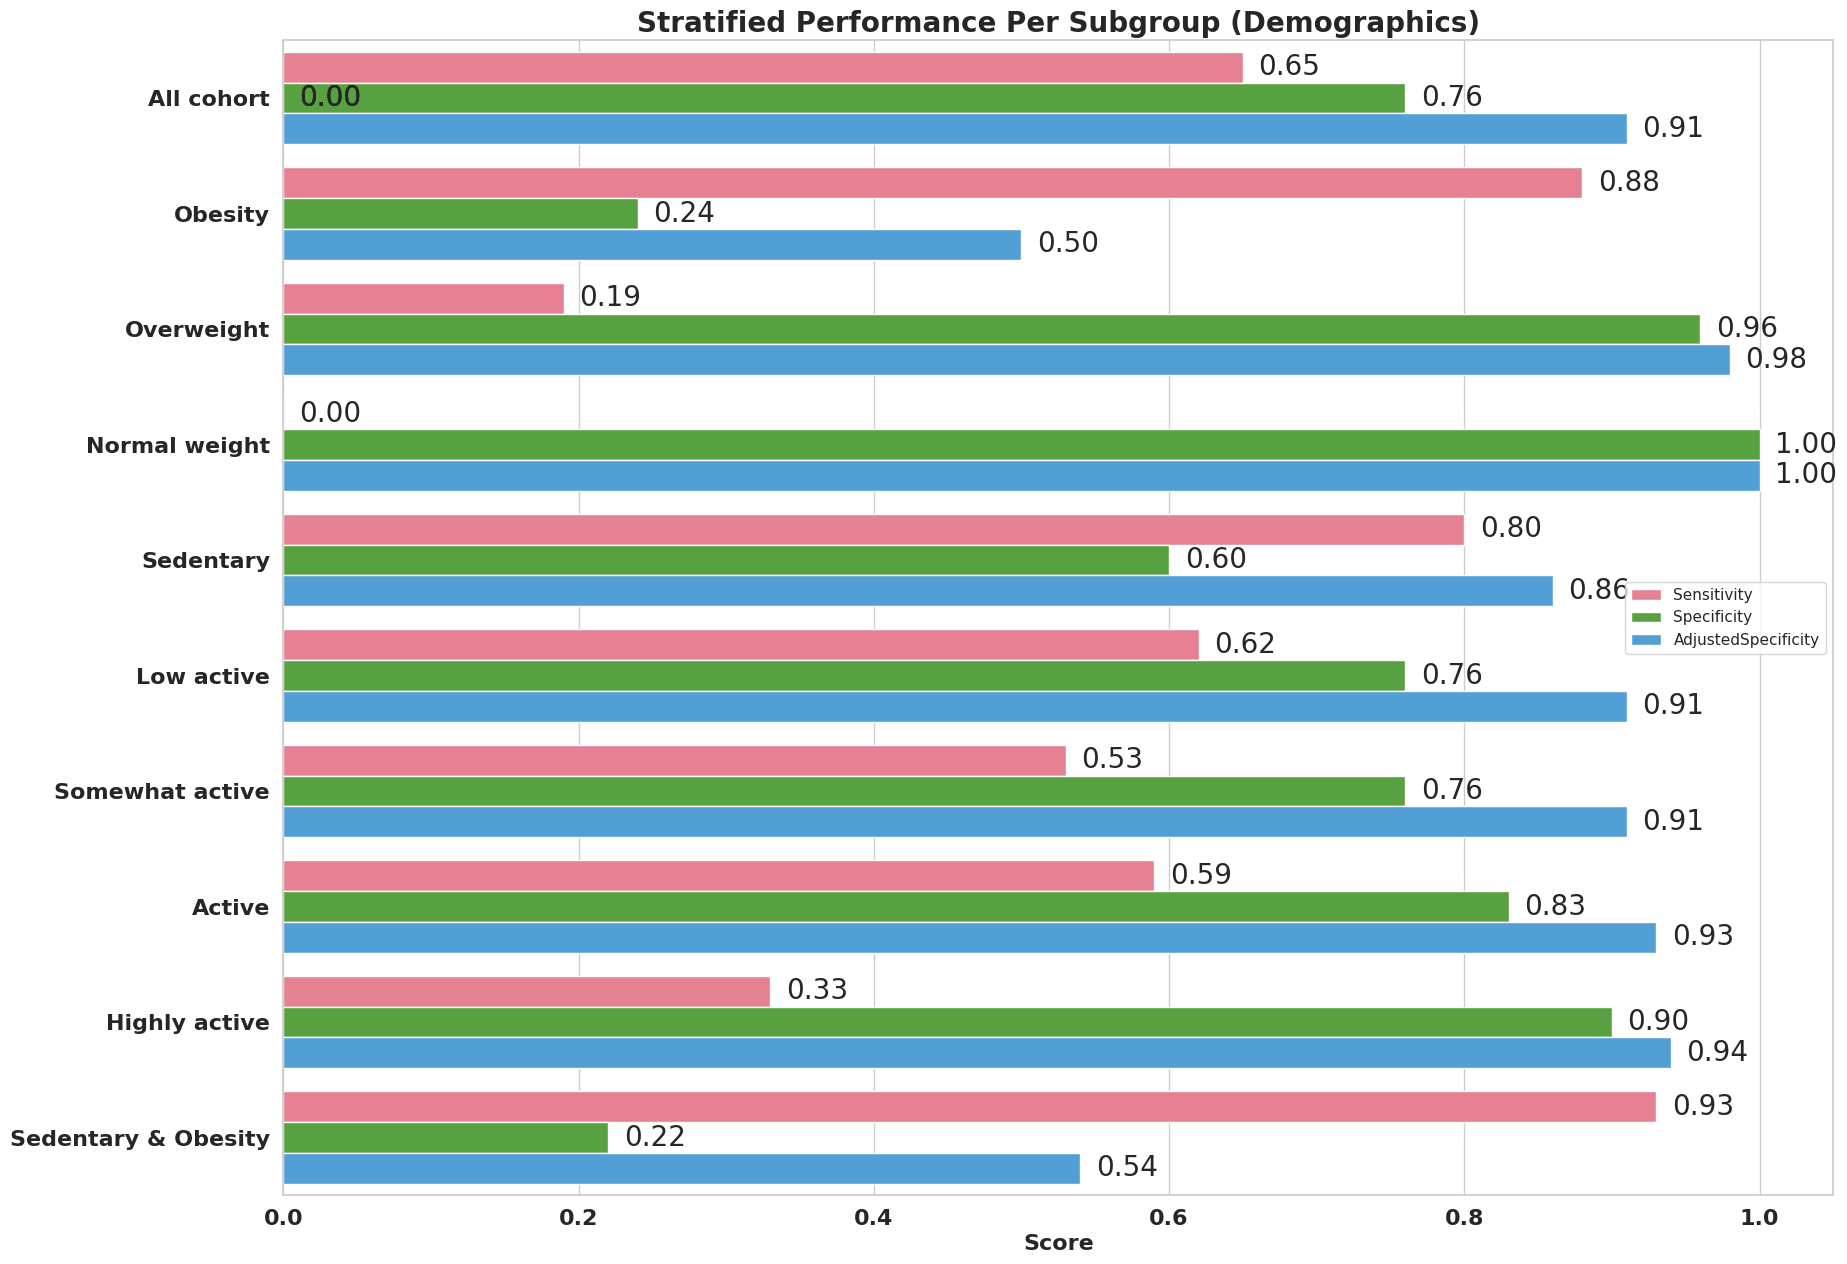

EXP_10
(1173, 4)
(1165, 159)
subgroup: All cohort Sensitivity: 0.71 Specificity: 0.832 AdjustedSpecificity: 0.965 tn: 720 fp: 145 fp_adjusted: 26
Dimension =  (1165, 163)


participant_id  predicted_values  true_values Experiment_ID  \
131            13699          4.320502         1.22        EXP_10   
148            13790          3.798302         1.08        EXP_10   
149            13798          3.240050         1.46        EXP_10   
347            56611          2.902563         1.31        EXP_10   
365            56770          3.292197         1.20        EXP_10   
377            56883          3.136884         1.18        EXP_10   
384            56921          3.878679         1.35        EXP_10   
408            57170          3.326247         1.44        EXP_10   
459            57470          3.182319         1.34        EXP_10   
480            57568          3.637474         1.49        EXP_10   
510            57672          2.928226         1.13        EXP_10   
536            57853          3.218373         1.34        EXP_10   
556            58001          3.229618         1.27        EXP_10   
666            70323          3.488229         1.21        EXP_10   
835            71323          3.013565         1.26        EXP_10   
851            71553          3.250865         1.03        EXP_10   
937            72103          3.551853         1.00        EXP_10   
942            72122          3.149027         1.26        EXP_10   
943            72123          3.271986         1.12        EXP_10   
951            72151          7.099334         1.07        EXP_10   
999            72393          3.285138         0.87        EXP_10   
1054           72753          3.415592         1.33        EXP_10   
1057           72772          4.743112         1.42        EXP_10   
1066           72832          5.055085         1.28        EXP_10   
1071           72913          2.973864         1.20        EXP_10   
1089           73107          2.965507         1.45        EXP_10   

      RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
131             77.881720                   77.0            3.277604   
148             78.827586                   79.0            2.779878   
149             71.153846                   71.0            1.333718   
347             62.203704                   62.5            2.198347   
365             64.361446                   64.0            2.603393   
377             71.947368                   72.0            6.800652   
384             71.563636                   72.0            2.168800   
408             67.330189                   67.0            1.906446   
459             67.400000                   68.0            3.674821   
480             82.628866                   82.0            2.503136   
510             61.552381                   62.0            2.573256   
536             75.474747                   75.0            4.244658   
556             76.830508                   77.0            2.257112   
666             59.652174                   59.0            2.702234   
835             76.775510                   75.5            4.507613   
851             72.118182                   72.0            1.801733   
937             75.333333                   76.0            2.229817   
942             75.435644                   75.0            1.701131   
943             87.588889                   87.5            2.236790   
951             79.828571                   79.0            3.869788   
999             52.191919                   52.0            1.519262   
1054            56.755556                   57.0            2.012870   
1057            77.415842                   77.0            2.563686   
1066            73.170543                   73.0            2.623225   
1071            69.540000                   70.0            3.038844   
1089            70.386667                   70.0            3.615379   

      HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
131             19.084679                18.7695            6.289622  ...   
148             15.268419                14

subgroup: Obesity Sensitivity: 0.824 Specificity: 0.648 AdjustedSpecificity: 0.911 tn: 164 fp: 89 fp_adjusted: 16
Dimension =  (458, 163)


participant_id  predicted_values  true_values Experiment_ID  \
131            13699          4.320502         1.22        EXP_10   
148            13790          3.798302         1.08        EXP_10   
149            13798          3.240050         1.46        EXP_10   
347            56611          2.902563         1.31        EXP_10   
384            56921          3.878679         1.35        EXP_10   
480            57568          3.637474         1.49        EXP_10   
536            57853          3.218373         1.34        EXP_10   
556            58001          3.229618         1.27        EXP_10   
942            72122          3.149027         1.26        EXP_10   
951            72151          7.099334         1.07        EXP_10   
999            72393          3.285138         0.87        EXP_10   
1054           72753          3.415592         1.33        EXP_10   
1057           72772          4.743112         1.42        EXP_10   
1066           72832          5.055085         1.28        EXP_10   
1071           72913          2.973864         1.20        EXP_10   
1089           73107          2.965507         1.45        EXP_10   

      RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
131             77.881720                   77.0            3.277604   
148             78.827586                   79.0            2.779878   
149             71.153846                   71.0            1.333718   
347             62.203704                   62.5            2.198347   
384             71.563636                   72.0            2.168800   
480             82.628866                   82.0            2.503136   
536             75.474747                   75.0            4.244658   
556             76.830508                   77.0            2.257112   
942             75.435644                   75.0            1.701131   
951             79.828571                   79.0            3.869788   
999             52.191919                   52.0            1.519262   
1054            56.755556                   57.0            2.012870   
1057            77.415842                   77.0            2.563686   
1066            73.170543                   73.0            2.623225   
1071            69.540000                   70.0            3.038844   
1089            70.386667                   70.0            3.615379   

      HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
131             19.084679                18.7695            6.289622  ...   
148             15.268419                14.8550            2.773114  ...   
149             15.987187                15.4875            3.364514  ...   
347             28.585029                28.5300            6.527487  ...   
384             17.900327                18.0995            3.762211  ...   
480             19.980969                20.0855            4.612247  ...   
536             34.240717                34.9030           10.327120  ...   
556             12.007664                11.5580            1.960277  ...   
942             13.147250                12.8785            1.882081  ...   
951             23.468922                27.0155           11.959427  ...   
999            103.814337               122.2440           49.835497  ...   
1054            50.168872                49.2260           11.411917  ...   
1057            19.213984                18.5970            4.285859  ...   
1066            12.802034                12.6280            2.826280  ...   
1071            30.251689                29.8250           22.836625  ...   
1089            36.990241                37.0445           11.965214  ...   

      ascvd_risk  ascvd_risk_category  optimal_ascvd_risk      apri  \
131          NaN                 None                 NaN  0.094271   
148          NaN                 None                 NaN  0.233463   
149          NaN                 None                 NaN  0.223048   
347          

subgroup: Overweight Sensitivity: 0.548 Specificity: 0.872 AdjustedSpecificity: 0.974 tn: 266 fp: 39 fp_adjusted: 7
Dimension =  (378, 163)


participant_id  predicted_values  true_values Experiment_ID  \
365           56770          3.292197         1.20        EXP_10   
459           57470          3.182319         1.34        EXP_10   
510           57672          2.928226         1.13        EXP_10   
835           71323          3.013565         1.26        EXP_10   
851           71553          3.250865         1.03        EXP_10   
937           72103          3.551853         1.00        EXP_10   
943           72123          3.271986         1.12        EXP_10   

     RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
365            64.361446                   64.0            2.603393   
459            67.400000                   68.0            3.674821   
510            61.552381                   62.0            2.573256   
835            76.775510                   75.5            4.507613   
851            72.118182                   72.0            1.801733   
937            75.333333                   76.0            2.229817   
943            87.588889                   87.5            2.236790   

     HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
365            44.979500                44.9795            0.189948  ...   
459             7.300823                 8.3020            9.755408  ...   
510            46.233162                49.0370           14.473240  ...   
835            18.873694                19.4565            4.145776  ...   
851            21.177291                21.5170            3.042877  ...   
937            15.605337                15.0920            3.413675  ...   
943            12.009691                12.1110            4.779979  ...   

     ascvd_risk  ascvd_risk_category  optimal_ascvd_risk      apri  \
365         NaN                 None                 NaN  0.183150   
459         NaN                 None                 NaN  0.301860   
510         NaN                 None                 NaN  0.209314   
835         NaN                 None                 NaN  0.136054   
851         NaN                 None                 NaN  0.198251   
937         NaN                 None                 NaN  0.211640   
943         NaN                 None                 NaN  0.228137   

     hypertension_binary  Diabetes_Status  homa_ir_class_true  \
365                    0    Normoglycemic                   0   
459                    0    Normoglycemic                   0   
510                    0    Normoglycemic                   0   
835                    0    Normoglycemic                   0   
851                    1    Normoglycemic                   0   
937                    0    Normoglycemic                   0   
943                    0    Normoglycemic                   0   

     homa_ir_class_predicted   bmi_class  physical_activity_class_steps  
365                        1  Overweight                Somewhat active  
459                        1  Overweight                  Highly active  
510                        1  Overweight                Somewhat active  
835                        1  Overweight                Somewhat active  
851                        1  Overweight                     Low active  
937                        1  Overweight                Somewhat active  
943                        1  Overweight                Somewhat active  

[7 rows x 163 columns]

subgroup: Normal weight Sensitivity: 0.182 Specificity: 0.943 AdjustedSpecificity: 0.989 tn: 280 fp: 17 fp_adjusted: 3
Dimension =  (319, 163)


participant_id  predicted_values  true_values Experiment_ID  \
377           56883          3.136884         1.18        EXP_10   
408           57170          3.326247         1.44        EXP_10   
666           70323          3.488229         1.21        EXP_10   

     RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
377            71.947368                   72.0            6.800652   
408            67.330189                   67.0            1.906446   
666            59.652174                   59.0            2.702234   

     HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
377            46.354786                36.1585           47.186600  ...   
408            27.489632                27.7990            6.866464  ...   
666            36.528487                36.7570            6.097105  ...   

     ascvd_risk  ascvd_risk_category  optimal_ascvd_risk      apri  \
377         NaN                 None                 NaN  0.502092   
408         NaN                 None                 NaN  0.141228   
666         NaN                 None                 NaN  0.156318   

     hypertension_binary  Diabetes_Status  homa_ir_class_true  \
377                    0    Normoglycemic                   0   
408                    0    Normoglycemic                   0   
666                    1      Prediabetic                   0   

     homa_ir_class_predicted      bmi_class  physical_activity_class_steps  
377                        1  Normal weight                     Low active  
408                        1  Normal weight                      Sedentary  
666                        1  Normal weight                      Sedentary  

[3 rows x 163 columns]

subgroup: Sedentary Sensitivity: 0.885 Specificity: 0.578 AdjustedSpecificity: 0.902 tn: 74 fp: 54 fp_adjusted: 8
Dimension =  (232, 163)


participant_id  predicted_values  true_values Experiment_ID  \
131            13699          4.320502         1.22        EXP_10   
148            13790          3.798302         1.08        EXP_10   
408            57170          3.326247         1.44        EXP_10   
556            58001          3.229618         1.27        EXP_10   
666            70323          3.488229         1.21        EXP_10   
942            72122          3.149027         1.26        EXP_10   
1071           72913          2.973864         1.20        EXP_10   
1089           73107          2.965507         1.45        EXP_10   

      RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
131             77.881720                   77.0            3.277604   
148             78.827586                   79.0            2.779878   
408             67.330189                   67.0            1.906446   
556             76.830508                   77.0            2.257112   
666             59.652174                   59.0            2.702234   
942             75.435644                   75.0            1.701131   
1071            69.540000                   70.0            3.038844   
1089            70.386667                   70.0            3.615379   

      HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
131             19.084679                18.7695            6.289622  ...   
148             15.268419                14.8550            2.773114  ...   
408             27.489632                27.7990            6.866464  ...   
556             12.007664                11.5580            1.960277  ...   
666             36.528487                36.7570            6.097105  ...   
942             13.147250                12.8785            1.882081  ...   
1071            30.251689                29.8250           22.836625  ...   
1089            36.990241                37.0445           11.965214  ...   

      ascvd_risk  ascvd_risk_category  optimal_ascvd_risk      apri  \
131          NaN                 None                 NaN  0.094271   
148          NaN                 None                 NaN  0.233463   
408          NaN                 None                 NaN  0.141228   
556          NaN                 None                 NaN  0.118636   
666          NaN                 None                 NaN  0.156318   
942          NaN                 None                 NaN  0.174717   
1071         NaN                 None                 NaN  0.205714   
1089         NaN                 None                 NaN  0.178571   

      hypertension_binary  Diabetes_Status  homa_ir_class_true  \
131                     0    Normoglycemic                   0   
148                     0    Normoglycemic                   0   
408                     0    Normoglycemic                   0   
556                     1    Normoglycemic                   0   
666                     1      Prediabetic                   0   
942                     0    Normoglycemic                   0   
1071                    0    Normoglycemic                   0   
1089                    0    Normoglycemic                   0   

      homa_ir_class_predicted      bmi_class  physical_activity_class_steps  
131                         1        Obesity                      Sedentary  
148                         1        Obesity                      Sedentary  
408                         1  Normal weight                      Sedentary  
556                         1        Obesity                      Sedentary  
666                         1  Normal weight                      Sedentary  
942                         1        Obesity                      Sedentary  
1071                        1        Obesity                      Sedentary  
1089                        1        Obesity                      Sedentary  

[8 rows x 163 columns]

subgroup: Low active Sensitivity: 0.693 Specificity: 0.833 AdjustedSpecificity: 0.97 tn: 229 fp: 46 fp_adjusted: 7
Dimension =  (376, 163)


participant_id  predicted_values  true_values Experiment_ID  \
347            56611          2.902563         1.31        EXP_10   
377            56883          3.136884         1.18        EXP_10   
384            56921          3.878679         1.35        EXP_10   
536            57853          3.218373         1.34        EXP_10   
851            71553          3.250865         1.03        EXP_10   
1054           72753          3.415592         1.33        EXP_10   
1057           72772          4.743112         1.42        EXP_10   

      RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
347             62.203704                   62.5            2.198347   
377             71.947368                   72.0            6.800652   
384             71.563636                   72.0            2.168800   
536             75.474747                   75.0            4.244658   
851             72.118182                   72.0            1.801733   
1054            56.755556                   57.0            2.012870   
1057            77.415842                   77.0            2.563686   

      HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
347             28.585029                28.5300            6.527487  ...   
377             46.354786                36.1585           47.186600  ...   
384             17.900327                18.0995            3.762211  ...   
536             34.240717                34.9030           10.327120  ...   
851             21.177291                21.5170            3.042877  ...   
1054            50.168872                49.2260           11.411917  ...   
1057            19.213984                18.5970            4.285859  ...   

      ascvd_risk  ascvd_risk_category  optimal_ascvd_risk      apri  \
347          NaN                 None                 NaN  0.324983   
377          NaN                 None                 NaN  0.502092   
384          NaN                 None                 NaN  0.267417   
536          NaN                 None                 NaN  0.239144   
851          NaN                 None                 NaN  0.198251   
1054         NaN                 None                 NaN  0.256630   
1057         NaN                 None                 NaN  0.147917   

      hypertension_binary  Diabetes_Status  homa_ir_class_true  \
347                     1    Normoglycemic                   0   
377                     0    Normoglycemic                   0   
384                     1    Normoglycemic                   0   
536                     0    Normoglycemic                   0   
851                     1    Normoglycemic                   0   
1054                    0    Normoglycemic                   0   
1057                    0    Normoglycemic                   0   

      homa_ir_class_predicted      bmi_class  physical_activity_class_steps  
347                         1        Obesity                     Low active  
377                         1  Normal weight                     Low active  
384                         1        Obesity                     Low active  
536                         1        Obesity                     Low active  
851                         1     Overweight                     Low active  
1054                        1        Obesity                     Low active  
1057                        1        Obesity                     Low active  

[7 rows x 163 columns]

subgroup: Somewhat active Sensitivity: 0.545 Specificity: 0.87 AdjustedSpecificity: 0.964 tn: 215 fp: 32 fp_adjusted: 8
Dimension =  (313, 163)


participant_id  predicted_values  true_values Experiment_ID  \
149           13798          3.240050         1.46        EXP_10   
365           56770          3.292197         1.20        EXP_10   
480           57568          3.637474         1.49        EXP_10   
510           57672          2.928226         1.13        EXP_10   
835           71323          3.013565         1.26        EXP_10   
937           72103          3.551853         1.00        EXP_10   
943           72123          3.271986         1.12        EXP_10   
951           72151          7.099334         1.07        EXP_10   

     RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
149            71.153846                   71.0            1.333718   
365            64.361446                   64.0            2.603393   
480            82.628866                   82.0            2.503136   
510            61.552381                   62.0            2.573256   
835            76.775510                   75.5            4.507613   
937            75.333333                   76.0            2.229817   
943            87.588889                   87.5            2.236790   
951            79.828571                   79.0            3.869788   

     HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
149            15.987187                15.4875            3.364514  ...   
365            44.979500                44.9795            0.189948  ...   
480            19.980969                20.0855            4.612247  ...   
510            46.233162                49.0370           14.473240  ...   
835            18.873694                19.4565            4.145776  ...   
937            15.605337                15.0920            3.413675  ...   
943            12.009691                12.1110            4.779979  ...   
951            23.468922                27.0155           11.959427  ...   

     ascvd_risk  ascvd_risk_category  optimal_ascvd_risk      apri  \
149         NaN                 None                 NaN  0.223048   
365         NaN                 None                 NaN  0.183150   
480         NaN                 None                 NaN  0.150376   
510         NaN                 None                 NaN  0.209314   
835         NaN                 None                 NaN  0.136054   
937         NaN                 None                 NaN  0.211640   
943         NaN                 None                 NaN  0.228137   
951         NaN                 None                 NaN  0.551378   

     hypertension_binary  Diabetes_Status  homa_ir_class_true  \
149                    0    Normoglycemic                   0   
365                    0    Normoglycemic                   0   
480                    0    Normoglycemic                   0   
510                    0    Normoglycemic                   0   
835                    0    Normoglycemic                   0   
937                    0    Normoglycemic                   0   
943                    0    Normoglycemic                   0   
951                    0    Normoglycemic                   0   

     homa_ir_class_predicted   bmi_class  physical_activity_class_steps  
149                        1     Obesity                Somewhat active  
365                        1  Overweight                Somewhat active  
480                        1     Obesity                Somewhat active  
510                        1  Overweight                Somewhat active  
835                        1  Overweight                Somewhat active  
937                        1  Overweight                Somewhat active  
943                        1  Overweight                Somewhat active  
951                        1     Obesity                Somewhat active  

[8 rows x 163 columns]

subgroup: Active Sensitivity: 0.588 Specificity: 0.929 AdjustedSpecificity: 0.983 tn: 118 fp: 9 fp_adjusted: 2
Dimension =  (144, 163)


participant_id  predicted_values  true_values Experiment_ID  \
999            72393          3.285138         0.87        EXP_10   
1066           72832          5.055085         1.28        EXP_10   

      RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
999             52.191919                   52.0            1.519262   
1066            73.170543                   73.0            2.623225   

      HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
999            103.814337                122.244           49.835497  ...   
1066            12.802034                 12.628            2.826280  ...   

      ascvd_risk  ascvd_risk_category  optimal_ascvd_risk      apri  \
999          NaN                 None                 NaN  0.203046   
1066         NaN                 None                 NaN  0.170213   

      hypertension_binary  Diabetes_Status  homa_ir_class_true  \
999                     0    Normoglycemic                   0   
1066                    0         Diabetic                   0   

      homa_ir_class_predicted  bmi_class  physical_activity_class_steps  
999                         1    Obesity                         Active  
1066                        1    Obesity                         Active  

[2 rows x 163 columns]

subgroup: Highly active Sensitivity: 0.417 Specificity: 0.955 AdjustedSpecificity: 0.988 tn: 84 fp: 4 fp_adjusted: 1
Dimension =  (100, 163)


participant_id  predicted_values  true_values Experiment_ID  \
459           57470          3.182319         1.34        EXP_10   

     RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
459                 67.4                   68.0            3.674821   

     HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
459             7.300823                  8.302            9.755408  ...   

     ascvd_risk  ascvd_risk_category  optimal_ascvd_risk     apri  \
459         NaN                 None                 NaN  0.30186   

     hypertension_binary  Diabetes_Status  homa_ir_class_true  \
459                    0    Normoglycemic                   0   

     homa_ir_class_predicted   bmi_class  physical_activity_class_steps  
459                        1  Overweight                  Highly active  

[1 rows x 163 columns]

subgroup: Sedentary & Obesity Sensitivity: 0.94 Specificity: 0.422 AdjustedSpecificity: 0.818 tn: 27 fp: 37 fp_adjusted: 6
Dimension =  (147, 163)


participant_id  predicted_values  true_values Experiment_ID  \
131            13699          4.320502         1.22        EXP_10   
148            13790          3.798302         1.08        EXP_10   
556            58001          3.229618         1.27        EXP_10   
942            72122          3.149027         1.26        EXP_10   
1071           72913          2.973864         1.20        EXP_10   
1089           73107          2.965507         1.45        EXP_10   

      RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
131             77.881720                   77.0            3.277604   
148             78.827586                   79.0            2.779878   
556             76.830508                   77.0            2.257112   
942             75.435644                   75.0            1.701131   
1071            69.540000                   70.0            3.038844   
1089            70.386667                   70.0            3.615379   

      HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
131             19.084679                18.7695            6.289622  ...   
148             15.268419                14.8550            2.773114  ...   
556             12.007664                11.5580            1.960277  ...   
942             13.147250                12.8785            1.882081  ...   
1071            30.251689                29.8250           22.836625  ...   
1089            36.990241                37.0445           11.965214  ...   

      ascvd_risk  ascvd_risk_category  optimal_ascvd_risk      apri  \
131          NaN                 None                 NaN  0.094271   
148          NaN                 None                 NaN  0.233463   
556          NaN                 None                 NaN  0.118636   
942          NaN                 None                 NaN  0.174717   
1071         NaN                 None                 NaN  0.205714   
1089         NaN                 None                 NaN  0.178571   

      hypertension_binary  Diabetes_Status  homa_ir_class_true  \
131                     0    Normoglycemic                   0   
148                     0    Normoglycemic                   0   
556                     1    Normoglycemic                   0   
942                     0    Normoglycemic                   0   
1071                    0    Normoglycemic                   0   
1089                    0    Normoglycemic                   0   

      homa_ir_class_predicted  bmi_class  physical_activity_class_steps  
131                         1    Obesity                      Sedentary  
148                         1    Obesity                      Sedentary  
556                         1    Obesity                      Sedentary  
942                         1    Obesity                      Sedentary  
1071                        1    Obesity                      Sedentary  
1089                        1    Obesity                      Sedentary  

[6 rows x 163 columns]

Subgroup  Sensitivity  Specificity  AdjustedSpecificity
0           All cohort         0.71         0.83                 0.96
1              Obesity         0.82         0.65                 0.91
2           Overweight         0.55         0.87                 0.97
3        Normal weight         0.18         0.94                 0.99
4            Sedentary         0.88         0.58                 0.90
5           Low active         0.69         0.83                 0.97
6      Somewhat active         0.55         0.87                 0.96
7               Active         0.59         0.93                 0.98
8        Highly active         0.42         0.96                 0.99
9  Sedentary & Obesity         0.94         0.42                 0.82

Subgroup               Metric  Score
0            All cohort          Sensitivity   0.71
1               Obesity          Sensitivity   0.82
2            Overweight          Sensitivity   0.55
3         Normal weight          Sensitivity   0.18
4             Sedentary          Sensitivity   0.88
5            Low active          Sensitivity   0.69
6       Somewhat active          Sensitivity   0.55
7                Active          Sensitivity   0.59
8         Highly active          Sensitivity   0.42
9   Sedentary & Obesity          Sensitivity   0.94
10           All cohort          Specificity   0.83
11              Obesity          Specificity   0.65
12           Overweight          Specificity   0.87
13        Normal weight          Specificity   0.94
14            Sedentary          Specificity   0.58
15           Low active          Specificity   0.83
16      Somewhat active          Specificity   0.87
17               Active          Specificity   0.93
18        Highly active          Specificity   0.96
19  Sedentary & Obesity          Specificity   0.42
20           All cohort  AdjustedSpecificity   0.96
21              Obesity  AdjustedSpecificity   0.91
22           Overweight  AdjustedSpecificity   0.97
23        Normal weight  AdjustedSpecificity   0.99
24            Sedentary  AdjustedSpecificity   0.90
25           Low active  AdjustedSpecificity   0.97
26      Somewhat active  AdjustedSpecificity   0.96
27               Active  AdjustedSpecificity   0.98
28        Highly active  AdjustedSpecificity   0.99
29  Sedentary & Obesity  AdjustedSpecificity   0.82

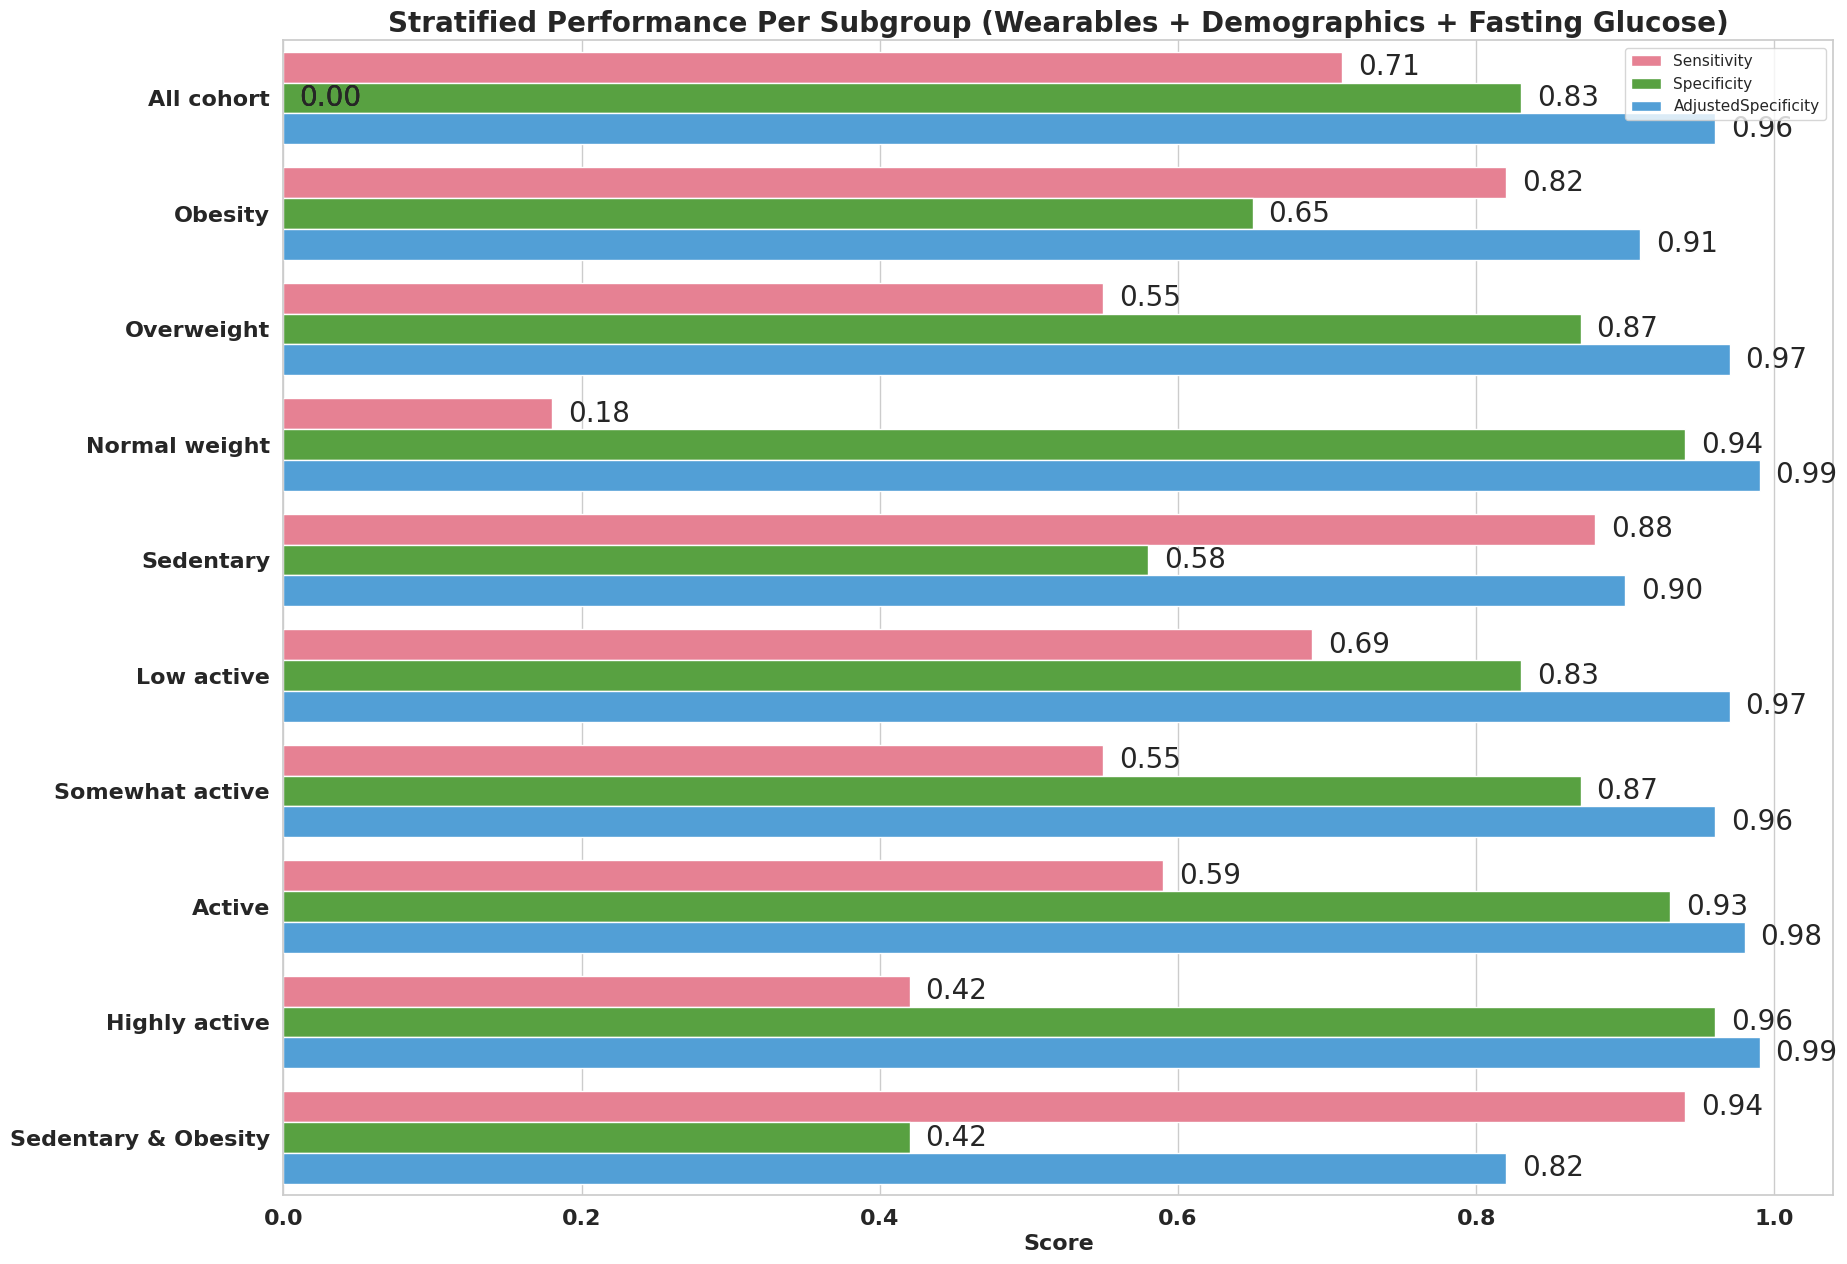

EXP_11
(1173, 4)
(1165, 159)
subgroup: All cohort Sensitivity: 0.76 Specificity: 0.84 AdjustedSpecificity: 0.971 tn: 727 fp: 138 fp_adjusted: 22
Dimension =  (1165, 163)


participant_id  predicted_values  true_values Experiment_ID  \
131            13699          3.346045         1.22        EXP_11   
152            13819          2.921984         0.72        EXP_11   
191            55870          2.952543         0.66        EXP_11   
328            56418          3.009351         0.77        EXP_11   
377            56883          3.488820         1.18        EXP_11   
384            56921          3.275285         1.35        EXP_11   
494            57609          3.029352         1.46        EXP_11   
497            57628          3.020782         1.17        EXP_11   
510            57672          3.234647         1.13        EXP_11   
536            57853          3.461545         1.34        EXP_11   
657            70306          3.980558         1.19        EXP_11   
666            70323          3.366820         1.21        EXP_11   
678            70355          3.664602         1.23        EXP_11   
793            70938          3.278019         1.15        EXP_11   
835            71323          3.108355         1.26        EXP_11   
937            72103          3.314164         1.00        EXP_11   
943            72123          4.663598         1.12        EXP_11   
951            72151          6.946205         1.07        EXP_11   
1057           72772          3.709178         1.42        EXP_11   
1063           72816          2.950277         1.22        EXP_11   
1066           72832          4.442048         1.28        EXP_11   
1089           73107          3.348786         1.45        EXP_11   

      RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
131             77.881720                   77.0            3.277604   
152             57.797980                   58.0            2.146795   
191             71.257143                   71.0            4.159565   
328             61.970297                   62.0            2.192050   
377             71.947368                   72.0            6.800652   
384             71.563636                   72.0            2.168800   
494             63.689320                   64.0            1.848027   
497             64.427350                   65.0            2.601803   
510             61.552381                   62.0            2.573256   
536             75.474747                   75.0            4.244658   
657             66.294118                   66.0            2.788393   
666             59.652174                   59.0            2.702234   
678             52.941606                   52.0            3.448770   
793             80.289157                   80.0            3.884796   
835             76.775510                   75.5            4.507613   
937             75.333333                   76.0            2.229817   
943             87.588889                   87.5            2.236790   
951             79.828571                   79.0            3.869788   
1057            77.415842                   77.0            2.563686   
1063            68.165217                   68.0            1.596560   
1066            73.170543                   73.0            2.623225   
1089            70.386667                   70.0            3.615379   

      HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
131             19.084679                18.7695            6.289622  ...   
152             16.404041                16.1420            4.429918  ...   
191             62.205130                63.7720           15.867430  ...   
328             29.781350                30.0265            6.525426  ...   
377             46.354786                36.1585           47.186600  ...   
384             17.900327                18.0995            3.762211  ...   
494             80.528835                80.7250           10.486620  ...   
497             54.463519                52.7555           14.056547  ...   
510             46.233162                49.0370           14.473240

subgroup: Obesity Sensitivity: 0.863 Specificity: 0.676 AdjustedSpecificity: 0.934 tn: 171 fp: 82 fp_adjusted: 12
Dimension =  (458, 163)


participant_id  predicted_values  true_values Experiment_ID  \
131            13699          3.346045         1.22        EXP_11   
191            55870          2.952543         0.66        EXP_11   
328            56418          3.009351         0.77        EXP_11   
384            56921          3.275285         1.35        EXP_11   
497            57628          3.020782         1.17        EXP_11   
536            57853          3.461545         1.34        EXP_11   
678            70355          3.664602         1.23        EXP_11   
951            72151          6.946205         1.07        EXP_11   
1057           72772          3.709178         1.42        EXP_11   
1063           72816          2.950277         1.22        EXP_11   
1066           72832          4.442048         1.28        EXP_11   
1089           73107          3.348786         1.45        EXP_11   

      RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
131             77.881720                   77.0            3.277604   
191             71.257143                   71.0            4.159565   
328             61.970297                   62.0            2.192050   
384             71.563636                   72.0            2.168800   
497             64.427350                   65.0            2.601803   
536             75.474747                   75.0            4.244658   
678             52.941606                   52.0            3.448770   
951             79.828571                   79.0            3.869788   
1057            77.415842                   77.0            2.563686   
1063            68.165217                   68.0            1.596560   
1066            73.170543                   73.0            2.623225   
1089            70.386667                   70.0            3.615379   

      HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
131             19.084679                18.7695            6.289622  ...   
191             62.205130                63.7720           15.867430  ...   
328             29.781350                30.0265            6.525426  ...   
384             17.900327                18.0995            3.762211  ...   
497             54.463519                52.7555           14.056547  ...   
536             34.240717                34.9030           10.327120  ...   
678             34.864829                34.6030            7.471314  ...   
951             23.468922                27.0155           11.959427  ...   
1057            19.213984                18.5970            4.285859  ...   
1063            29.555606                28.7260            9.637907  ...   
1066            12.802034                12.6280            2.826280  ...   
1089            36.990241                37.0445           11.965214  ...   

      ascvd_risk  ascvd_risk_category  optimal_ascvd_risk      apri  \
131          NaN                 None                 NaN  0.094271   
191          NaN                 None                 NaN  0.158290   
328          NaN                 None                 NaN  0.204082   
384          NaN                 None                 NaN  0.267417   
497          NaN                 None                 NaN  0.091185   
536          NaN                 None                 NaN  0.239144   
678          NaN                 None                 NaN  0.714286   
951          NaN                 None                 NaN  0.551378   
1057         NaN                 None                 NaN  0.147917   
1063         NaN                 None                 NaN  0.185387   
1066         NaN                 None                 NaN  0.170213   
1089         NaN                 None                 NaN  0.178571   

      hypertension_binary  Diabetes_Status  homa_ir_class_true  \
131                     0    Normoglycemic                   0   
191                     0    Normoglycemic                   0   
328                     1    Normoglycemic     

subgroup: Overweight Sensitivity: 0.63 Specificity: 0.875 AdjustedSpecificity: 0.978 tn: 267 fp: 38 fp_adjusted: 6
Dimension =  (378, 163)


participant_id  predicted_values  true_values Experiment_ID  \
152           13819          2.921984         0.72        EXP_11   
510           57672          3.234647         1.13        EXP_11   
793           70938          3.278019         1.15        EXP_11   
835           71323          3.108355         1.26        EXP_11   
937           72103          3.314164         1.00        EXP_11   
943           72123          4.663598         1.12        EXP_11   

     RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
152            57.797980                   58.0            2.146795   
510            61.552381                   62.0            2.573256   
793            80.289157                   80.0            3.884796   
835            76.775510                   75.5            4.507613   
937            75.333333                   76.0            2.229817   
943            87.588889                   87.5            2.236790   

     HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
152            16.404041                16.1420            4.429918  ...   
510            46.233162                49.0370           14.473240  ...   
793            27.444590                23.9840           14.531359  ...   
835            18.873694                19.4565            4.145776  ...   
937            15.605337                15.0920            3.413675  ...   
943            12.009691                12.1110            4.779979  ...   

     ascvd_risk  ascvd_risk_category  optimal_ascvd_risk      apri  \
152         NaN                 None                 NaN  0.242692   
510         NaN                 None                 NaN  0.209314   
793         NaN                 None                 NaN  0.456554   
835         NaN                 None                 NaN  0.136054   
937         NaN                 None                 NaN  0.211640   
943         NaN                 None                 NaN  0.228137   

     hypertension_binary  Diabetes_Status  homa_ir_class_true  \
152                    1    Normoglycemic                   0   
510                    0    Normoglycemic                   0   
793                    0    Normoglycemic                   0   
835                    0    Normoglycemic                   0   
937                    0    Normoglycemic                   0   
943                    0    Normoglycemic                   0   

     homa_ir_class_predicted   bmi_class  physical_activity_class_steps  
152                        1  Overweight                     Low active  
510                        1  Overweight                Somewhat active  
793                        1  Overweight                     Low active  
835                        1  Overweight                Somewhat active  
937                        1  Overweight                Somewhat active  
943                        1  Overweight                Somewhat active  

[6 rows x 163 columns]

subgroup: Normal weight Sensitivity: 0.227 Specificity: 0.939 AdjustedSpecificity: 0.986 tn: 279 fp: 18 fp_adjusted: 4
Dimension =  (319, 163)


participant_id  predicted_values  true_values Experiment_ID  \
377           56883          3.488820         1.18        EXP_11   
494           57609          3.029352         1.46        EXP_11   
657           70306          3.980558         1.19        EXP_11   
666           70323          3.366820         1.21        EXP_11   

     RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
377            71.947368                   72.0            6.800652   
494            63.689320                   64.0            1.848027   
657            66.294118                   66.0            2.788393   
666            59.652174                   59.0            2.702234   

     HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
377            46.354786                36.1585           47.186600  ...   
494            80.528835                80.7250           10.486620  ...   
657            29.771059                30.0390           10.385523  ...   
666            36.528487                36.7570            6.097105  ...   

     ascvd_risk  ascvd_risk_category  optimal_ascvd_risk      apri  \
377         NaN                 None                 NaN  0.502092   
494         NaN                 None                 NaN  0.128968   
657         NaN                 None                 NaN  0.510204   
666         NaN                 None                 NaN  0.156318   

     hypertension_binary  Diabetes_Status  homa_ir_class_true  \
377                    0    Normoglycemic                   0   
494                    0    Normoglycemic                   0   
657                    1    Normoglycemic                   0   
666                    1      Prediabetic                   0   

     homa_ir_class_predicted      bmi_class  physical_activity_class_steps  
377                        1  Normal weight                     Low active  
494                        1  Normal weight                Somewhat active  
657                        1  Normal weight                     Low active  
666                        1  Normal weight                      Sedentary  

[4 rows x 163 columns]

subgroup: Sedentary Sensitivity: 0.885 Specificity: 0.703 AdjustedSpecificity: 0.968 tn: 90 fp: 38 fp_adjusted: 3
Dimension =  (232, 163)


participant_id  predicted_values  true_values Experiment_ID  \
131            13699          3.346045         1.22        EXP_11   
666            70323          3.366820         1.21        EXP_11   
1089           73107          3.348786         1.45        EXP_11   

      RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
131             77.881720                   77.0            3.277604   
666             59.652174                   59.0            2.702234   
1089            70.386667                   70.0            3.615379   

      HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
131             19.084679                18.7695            6.289622  ...   
666             36.528487                36.7570            6.097105  ...   
1089            36.990241                37.0445           11.965214  ...   

      ascvd_risk  ascvd_risk_category  optimal_ascvd_risk      apri  \
131          NaN                 None                 NaN  0.094271   
666          NaN                 None                 NaN  0.156318   
1089         NaN                 None                 NaN  0.178571   

      hypertension_binary  Diabetes_Status  homa_ir_class_true  \
131                     0    Normoglycemic                   0   
666                     1      Prediabetic                   0   
1089                    0    Normoglycemic                   0   

      homa_ir_class_predicted      bmi_class  physical_activity_class_steps  
131                         1        Obesity                      Sedentary  
666                         1  Normal weight                      Sedentary  
1089                        1        Obesity                      Sedentary  

[3 rows x 163 columns]

subgroup: Low active Sensitivity: 0.762 Specificity: 0.829 AdjustedSpecificity: 0.958 tn: 228 fp: 47 fp_adjusted: 10
Dimension =  (376, 163)


participant_id  predicted_values  true_values Experiment_ID  \
152            13819          2.921984         0.72        EXP_11   
191            55870          2.952543         0.66        EXP_11   
328            56418          3.009351         0.77        EXP_11   
377            56883          3.488820         1.18        EXP_11   
384            56921          3.275285         1.35        EXP_11   
497            57628          3.020782         1.17        EXP_11   
536            57853          3.461545         1.34        EXP_11   
657            70306          3.980558         1.19        EXP_11   
793            70938          3.278019         1.15        EXP_11   
1057           72772          3.709178         1.42        EXP_11   

      RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
152             57.797980                   58.0            2.146795   
191             71.257143                   71.0            4.159565   
328             61.970297                   62.0            2.192050   
377             71.947368                   72.0            6.800652   
384             71.563636                   72.0            2.168800   
497             64.427350                   65.0            2.601803   
536             75.474747                   75.0            4.244658   
657             66.294118                   66.0            2.788393   
793             80.289157                   80.0            3.884796   
1057            77.415842                   77.0            2.563686   

      HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
152             16.404041                16.1420            4.429918  ...   
191             62.205130                63.7720           15.867430  ...   
328             29.781350                30.0265            6.525426  ...   
377             46.354786                36.1585           47.186600  ...   
384             17.900327                18.0995            3.762211  ...   
497             54.463519                52.7555           14.056547  ...   
536             34.240717                34.9030           10.327120  ...   
657             29.771059                30.0390           10.385523  ...   
793             27.444590                23.9840           14.531359  ...   
1057            19.213984                18.5970            4.285859  ...   

      ascvd_risk  ascvd_risk_category  optimal_ascvd_risk      apri  \
152          NaN                 None                 NaN  0.242692   
191          NaN                 None                 NaN  0.158290   
328          NaN                 None                 NaN  0.204082   
377          NaN                 None                 NaN  0.502092   
384          NaN                 None                 NaN  0.267417   
497          NaN                 None                 NaN  0.091185   
536          NaN                 None                 NaN  0.239144   
657          NaN                 None                 NaN  0.510204   
793          NaN                 None                 NaN  0.456554   
1057         NaN                 None                 NaN  0.147917   

      hypertension_binary  Diabetes_Status  homa_ir_class_true  \
152                     1    Normoglycemic                   0   
191                     0    Normoglycemic                   0   
328                     1    Normoglycemic                   0   
377                     0    Normoglycemic                   0   
384                     1    Normoglycemic                   0   
497                     0      Prediabetic                   0   
536                     0    Normoglycemic                   0   
657                     1    Normoglycemic                   0   
793                     0    Normoglycemic                   0   
1057                    0    Normoglycemic                   0   

      homa_ir_class_predicted      bmi_class  physical_activity_class_steps  
152               

subgroup: Somewhat active Sensitivity: 0.636 Specificity: 0.85 AdjustedSpecificity: 0.963 tn: 210 fp: 37 fp_adjusted: 8
Dimension =  (313, 163)


participant_id  predicted_values  true_values Experiment_ID  \
494            57609          3.029352         1.46        EXP_11   
510            57672          3.234647         1.13        EXP_11   
678            70355          3.664602         1.23        EXP_11   
835            71323          3.108355         1.26        EXP_11   
937            72103          3.314164         1.00        EXP_11   
943            72123          4.663598         1.12        EXP_11   
951            72151          6.946205         1.07        EXP_11   
1063           72816          2.950277         1.22        EXP_11   

      RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
494             63.689320                   64.0            1.848027   
510             61.552381                   62.0            2.573256   
678             52.941606                   52.0            3.448770   
835             76.775510                   75.5            4.507613   
937             75.333333                   76.0            2.229817   
943             87.588889                   87.5            2.236790   
951             79.828571                   79.0            3.869788   
1063            68.165217                   68.0            1.596560   

      HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
494             80.528835                80.7250           10.486620  ...   
510             46.233162                49.0370           14.473240  ...   
678             34.864829                34.6030            7.471314  ...   
835             18.873694                19.4565            4.145776  ...   
937             15.605337                15.0920            3.413675  ...   
943             12.009691                12.1110            4.779979  ...   
951             23.468922                27.0155           11.959427  ...   
1063            29.555606                28.7260            9.637907  ...   

      ascvd_risk  ascvd_risk_category  optimal_ascvd_risk      apri  \
494          NaN                 None                 NaN  0.128968   
510          NaN                 None                 NaN  0.209314   
678          NaN                 None                 NaN  0.714286   
835          NaN                 None                 NaN  0.136054   
937          NaN                 None                 NaN  0.211640   
943          NaN                 None                 NaN  0.228137   
951          NaN                 None                 NaN  0.551378   
1063         NaN                 None                 NaN  0.185387   

      hypertension_binary  Diabetes_Status  homa_ir_class_true  \
494                     0    Normoglycemic                   0   
510                     0    Normoglycemic                   0   
678                     1    Normoglycemic                   0   
835                     0    Normoglycemic                   0   
937                     0    Normoglycemic                   0   
943                     0    Normoglycemic                   0   
951                     0    Normoglycemic                   0   
1063                    0    Normoglycemic                   0   

      homa_ir_class_predicted      bmi_class  physical_activity_class_steps  
494                         1  Normal weight                Somewhat active  
510                         1     Overweight                Somewhat active  
678                         1        Obesity                Somewhat active  
835                         1     Overweight                Somewhat active  
937                         1     Overweight                Somewhat active  
943                         1     Overweight                Somewhat active  
951                         1        Obesity                Somewhat active  
1063                        1        Obesity                Somewhat active  

[8 rows x 163 columns]

subgroup: Active Sensitivity: 0.588 Specificity: 0.898 AdjustedSpecificity: 0.991 tn: 114 fp: 13 fp_adjusted: 1
Dimension =  (144, 163)


participant_id  predicted_values  true_values Experiment_ID  \
1066           72832          4.442048         1.28        EXP_11   

      RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
1066            73.170543                   73.0            2.623225   

      HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
1066            12.802034                 12.628             2.82628  ...   

      ascvd_risk  ascvd_risk_category  optimal_ascvd_risk      apri  \
1066         NaN                 None                 NaN  0.170213   

      hypertension_binary  Diabetes_Status  homa_ir_class_true  \
1066                    0         Diabetic                   0   

      homa_ir_class_predicted  bmi_class  physical_activity_class_steps  
1066                        1    Obesity                         Active  

[1 rows x 163 columns]

subgroup: Highly active Sensitivity: 0.583 Specificity: 0.966 AdjustedSpecificity: 1.0 tn: 85 fp: 3 fp_adjusted: 0
Dimension =  (100, 163)


Empty DataFrame
Columns: [participant_id, predicted_values, true_values, Experiment_ID, RHR_FreeLiving_mean, RHR_FreeLiving_median, RHR_FreeLiving_std, HRV_FreeLiving_mean, HRV_FreeLiving_median, HRV_FreeLiving_std, STEPS_Daily_mean, STEPS_Daily_median, STEPS_Daily_std, SLEEP_Duration_mean, SLEEP_Duration_median, SLEEP_Duration_std, total cholesterol, hdl, triglycerides, ldl, chol/hdl, non hdl, glucose, bun, creatinine, egfr, sodium, potassium, chloride, co2, calcium, total protein, albumin, globulin, albumin/globulin, total bilirubin, alp, ast, alt, hba1c, insulin, crp, white_blood_cell, red_blood_cell, hb, hematocrit, mcv, mch, mchc, rdw, platelet, mpv, absolute_neutrophils, absolute_lymphocytes, absolute_monocytes, absolute_eosinophils, absolute_basophils, neutrophils, lymphocytes, monocytes, eosinophils, basophils, ggt, total testosterone, time, bun/creatinine, HEMOGLOBIN A1c, ALT, collection_hour_UTC, hdl_reported, a1c_date, a1c_reported, age, anxiety_or_depression_date, blood_pressure_date, cardiovascular_disease_date, cholesterol_date, contraceptives, diabetes_date, diabetes_medications, diabetes_type, diastolic_bp, employment_status, fasting_glucose_date, glucose_reported, sex, height, high_cholesterol_date, highest_education, household_income, hypertension_date, kidney_condition_date, marital_status, medications, menstruation, other_diagnosed_conditions, ethnicity, regular_periods, respiratory_condition_date, systolic_bp, ...]
Index: []

[0 rows x 163 columns]

subgroup: Sedentary & Obesity Sensitivity: 0.928 Specificity: 0.578 AdjustedSpecificity: 0.949 tn: 37 fp: 27 fp_adjusted: 2
Dimension =  (147, 163)


participant_id  predicted_values  true_values Experiment_ID  \
131            13699          3.346045         1.22        EXP_11   
1089           73107          3.348786         1.45        EXP_11   

      RHR_FreeLiving_mean  RHR_FreeLiving_median  RHR_FreeLiving_std  \
131             77.881720                   77.0            3.277604   
1089            70.386667                   70.0            3.615379   

      HRV_FreeLiving_mean  HRV_FreeLiving_median  HRV_FreeLiving_std  ...  \
131             19.084679                18.7695            6.289622  ...   
1089            36.990241                37.0445           11.965214  ...   

      ascvd_risk  ascvd_risk_category  optimal_ascvd_risk      apri  \
131          NaN                 None                 NaN  0.094271   
1089         NaN                 None                 NaN  0.178571   

      hypertension_binary  Diabetes_Status  homa_ir_class_true  \
131                     0    Normoglycemic                   0   
1089                    0    Normoglycemic                   0   

      homa_ir_class_predicted  bmi_class  physical_activity_class_steps  
131                         1    Obesity                      Sedentary  
1089                        1    Obesity                      Sedentary  

[2 rows x 163 columns]

Subgroup  Sensitivity  Specificity  AdjustedSpecificity
0           All cohort         0.76         0.84                 0.97
1              Obesity         0.86         0.68                 0.93
2           Overweight         0.63         0.88                 0.98
3        Normal weight         0.23         0.94                 0.99
4            Sedentary         0.88         0.70                 0.97
5           Low active         0.76         0.83                 0.96
6      Somewhat active         0.64         0.85                 0.96
7               Active         0.59         0.90                 0.99
8        Highly active         0.58         0.97                 1.00
9  Sedentary & Obesity         0.93         0.58                 0.95

Subgroup               Metric  Score
0            All cohort          Sensitivity   0.76
1               Obesity          Sensitivity   0.86
2            Overweight          Sensitivity   0.63
3         Normal weight          Sensitivity   0.23
4             Sedentary          Sensitivity   0.88
5            Low active          Sensitivity   0.76
6       Somewhat active          Sensitivity   0.64
7                Active          Sensitivity   0.59
8         Highly active          Sensitivity   0.58
9   Sedentary & Obesity          Sensitivity   0.93
10           All cohort          Specificity   0.84
11              Obesity          Specificity   0.68
12           Overweight          Specificity   0.88
13        Normal weight          Specificity   0.94
14            Sedentary          Specificity   0.70
15           Low active          Specificity   0.83
16      Somewhat active          Specificity   0.85
17               Active          Specificity   0.90
18        Highly active          Specificity   0.97
19  Sedentary & Obesity          Specificity   0.58
20           All cohort  AdjustedSpecificity   0.97
21              Obesity  AdjustedSpecificity   0.93
22           Overweight  AdjustedSpecificity   0.98
23        Normal weight  AdjustedSpecificity   0.99
24            Sedentary  AdjustedSpecificity   0.97
25           Low active  AdjustedSpecificity   0.96
26      Somewhat active  AdjustedSpecificity   0.96
27               Active  AdjustedSpecificity   0.99
28        Highly active  AdjustedSpecificity   1.00
29  Sedentary & Obesity  AdjustedSpecificity   0.95

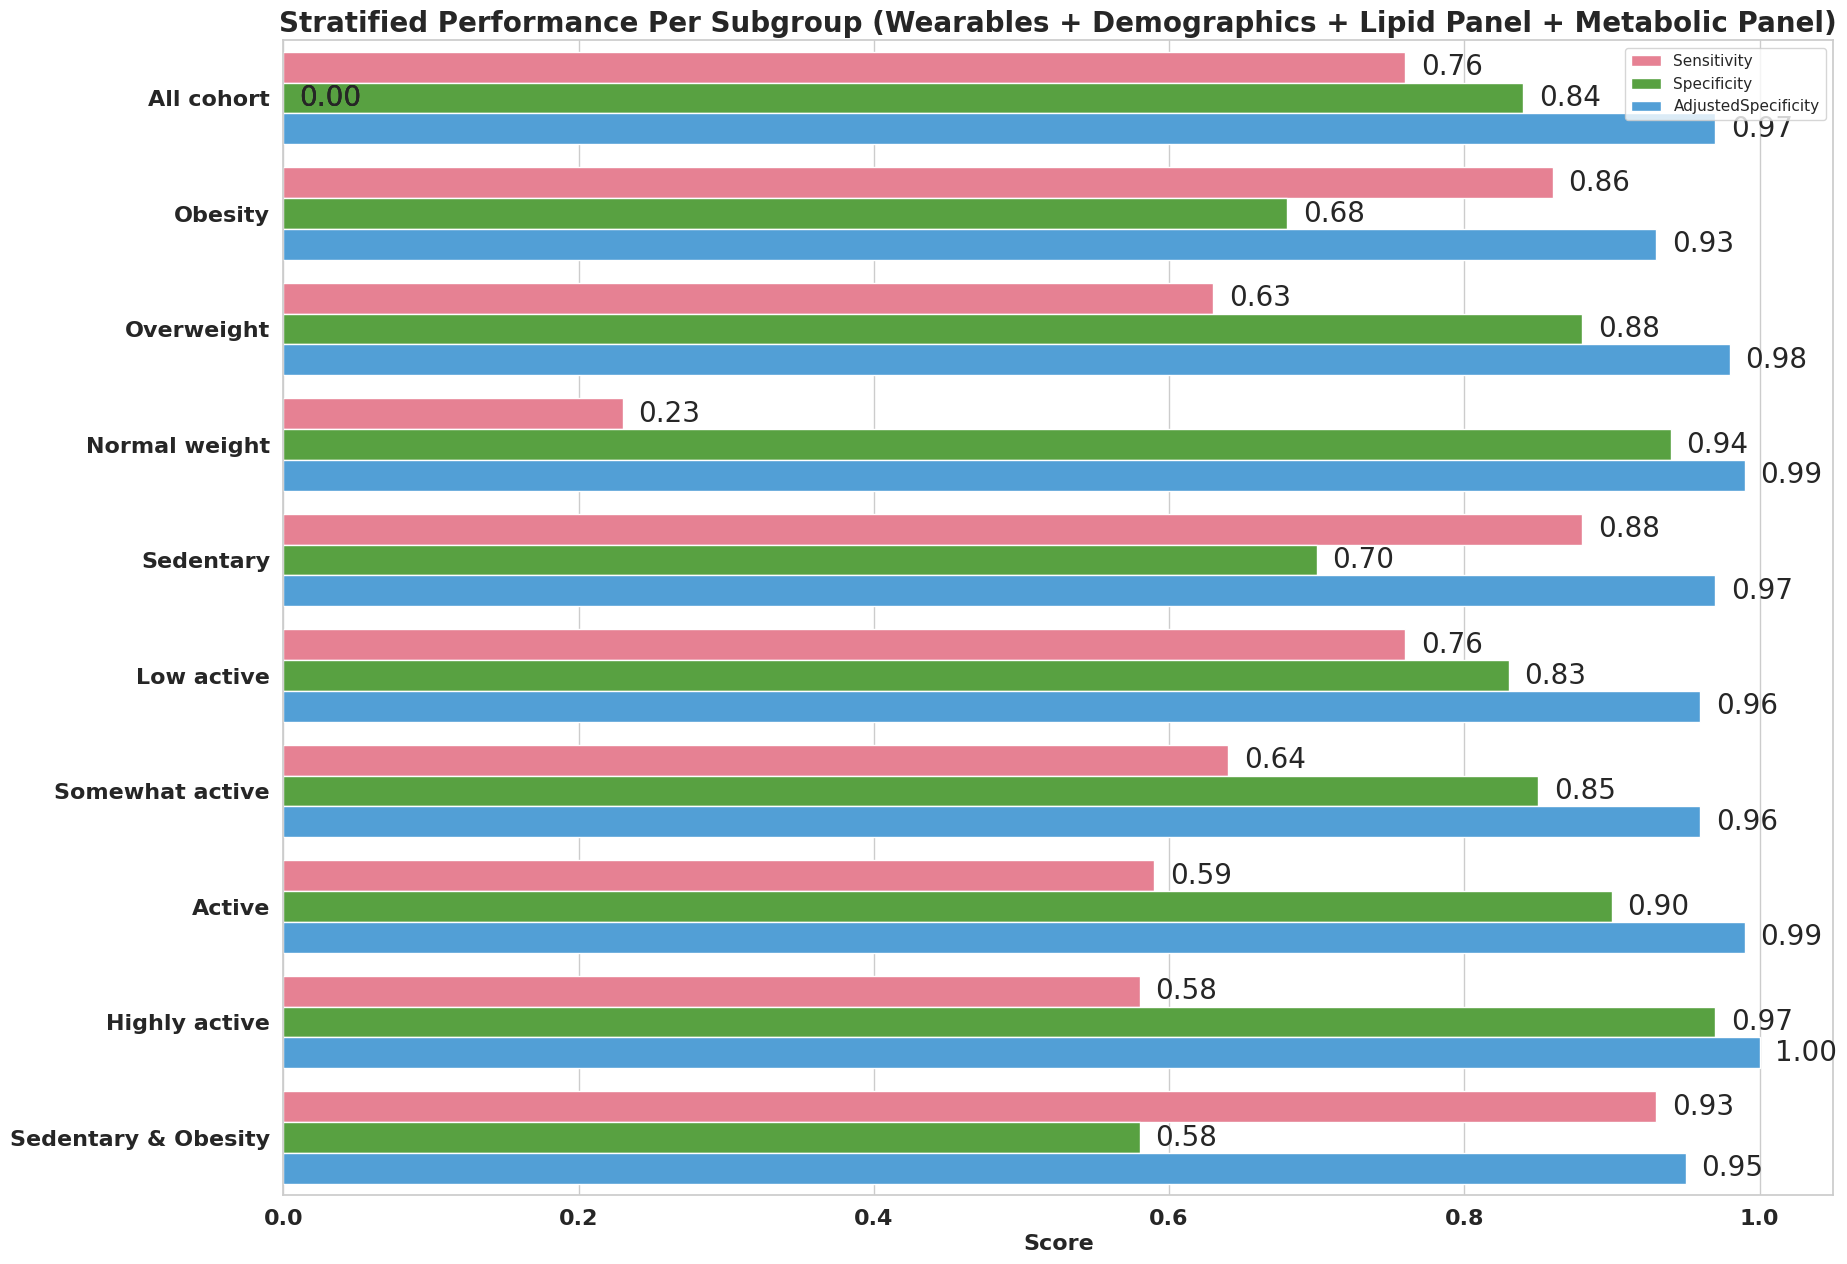

In [ ]:
#@title Perform Startification analysis for all experiments

experiments = {"EXP_1": "Wearables + Demographics",
               "EXP_4": "Demographics",
               "EXP_10": "Wearables + Demographics + Fasting Glucose",
               "EXP_11": "Wearables + Demographics + Lipid Panel + Metabolic Panel"}
for exp in experiments:
  print(exp)

  # Concatenate all dataframes in the dictionary
  homa_ir_prediction = dfs[exp]
  # homa_ir_prediction = pd.concat(dfs.values(), ignore_index=True).reset_index(drop=True)
  print(homa_ir_prediction.shape)

  # Merge with labels, scores, and digital biomarkers
  homa_ir_prediction_score_labels = homa_ir_prediction.merge(labels_and_scores_digital_biomarkers_cleaned, on='participant_id')
  print(homa_ir_prediction_score_labels.shape)
  homa_ir_prediction_score_labels.head()
  # homa_ir_prediction_score_labels


  # Apply Categorize based on HOMA-IR
  homa_ir_prediction_score_labels['homa_ir_class_true'] = homa_ir_prediction_score_labels['true_values'].apply(categorize_homa_ir)
  homa_ir_prediction_score_labels['homa_ir_class_predicted'] = homa_ir_prediction_score_labels['predicted_values'].apply(categorize_homa_ir)

  # Apply the function to the BMI column to create a new column
  homa_ir_prediction_score_labels['bmi_class'] = homa_ir_prediction_score_labels['bmi'].apply(categorize_bmi)

  # Apply the function to the Step_Count column to create a new column
  homa_ir_prediction_score_labels['physical_activity_class_steps'] = homa_ir_prediction_score_labels['STEPS_Daily_mean'].apply(categorize_activity)

  stratified_perf_df = pd.DataFrame()
  # print("All cohort")
  subgroup_perf = calculate_performance(homa_ir_prediction_score_labels, subgroup="All cohort")
  stratified_perf_df = pd.concat([stratified_perf_df, subgroup_perf], ignore_index=True)

  # print("\n Obese")
  subgroup_perf = calculate_performance(homa_ir_prediction_score_labels[homa_ir_prediction_score_labels["bmi_class"] == "Obesity"], subgroup="Obesity")
  stratified_perf_df = pd.concat([stratified_perf_df, subgroup_perf], ignore_index=True)

  # print("\n Overweight")
  subgroup_perf = calculate_performance(homa_ir_prediction_score_labels[homa_ir_prediction_score_labels["bmi_class"] == "Overweight"], subgroup="Overweight")
  stratified_perf_df = pd.concat([stratified_perf_df, subgroup_perf], ignore_index=True)

  # print("\n Normal weight")
  subgroup_perf = calculate_performance(homa_ir_prediction_score_labels[homa_ir_prediction_score_labels["bmi_class"] == "Normal weight"], subgroup="Normal weight")
  stratified_perf_df = pd.concat([stratified_perf_df, subgroup_perf], ignore_index=True)


  # print("\n Sedentary")
  subgroup_perf = calculate_performance(homa_ir_prediction_score_labels[homa_ir_prediction_score_labels["physical_activity_class_steps"] == "Sedentary"], subgroup="Sedentary")
  stratified_perf_df = pd.concat([stratified_perf_df, subgroup_perf], ignore_index=True)

  # print("\n Low active")
  subgroup_perf = calculate_performance(homa_ir_prediction_score_labels[homa_ir_prediction_score_labels["physical_activity_class_steps"] == "Low active"], subgroup="Low active")
  stratified_perf_df = pd.concat([stratified_perf_df, subgroup_perf], ignore_index=True)


  # print("\n Somewhat active")
  subgroup_perf = calculate_performance(homa_ir_prediction_score_labels[homa_ir_prediction_score_labels["physical_activity_class_steps"] == "Somewhat active"], subgroup="Somewhat active")
  stratified_perf_df = pd.concat([stratified_perf_df, subgroup_perf], ignore_index=True)


  # print("\n Active")
  subgroup_perf = calculate_performance(homa_ir_prediction_score_labels[homa_ir_prediction_score_labels["physical_activity_class_steps"] == "Active"],  subgroup="Active")
  stratified_perf_df = pd.concat([stratified_perf_df, subgroup_perf], ignore_index=True)

  # print("\n Highly active")
  subgroup_perf = calculate_performance(homa_ir_prediction_score_labels[homa_ir_prediction_score_labels["physical_activity_class_steps"] == "Highly active"], subgroup="Highly active")
  stratified_perf_df = pd.concat([stratified_perf_df, subgroup_perf], ignore_index=True)



  ## Do joint group
  # print("\n Sedentary & Obese")
  subgroup_perf = calculate_performance(homa_ir_prediction_score_labels[
      (homa_ir_prediction_score_labels["physical_activity_class_steps"] == "Sedentary")
      &
      (homa_ir_prediction_score_labels["bmi_class"] == "Obesity")
      ], subgroup="Sedentary & Obesity")
  stratified_perf_df = pd.concat([stratified_perf_df, subgroup_perf], ignore_index=True)

  display(stratified_perf_df)

  # Melt the DataFrame to a long format
  df_melted = stratified_perf_df.melt(id_vars='Subgroup', value_vars=['Sensitivity', 'Specificity', 'AdjustedSpecificity'],
                      var_name='Metric', value_name='Score')

  display(df_melted)

  # Set the style of the visualization
  sns.set(style="whitegrid")

  # Create a figure and axis
  fig, ax = plt.subplots(figsize=(20, 15))

  # Define a custom color palette
  palette = sns.color_palette("husl", n_colors=df_melted['Metric'].nunique())


  # Create a bar plot
  bar_plot = sns.barplot(x='Score', y='Subgroup', hue='Metric', data=df_melted, ax=ax, palette=palette)


  # Add values to each bar
  for p in bar_plot.patches:
      bar_plot.annotate(format(p.get_width(), '.2f'),
                        (p.get_width() + 0.02, p.get_y() + p.get_height() / 2),
                        ha='left', va='center',
                        xytext=(-10, 0), textcoords='offset points', fontsize=20)

  # Adjust legend title
  plt.legend(title='')


  plt.title('Stratified Performance Per Subgroup (' + experiments[exp] + ')', fontsize=20, weight='bold')
  plt.xlabel('Score', fontsize=16, weight='bold')
  plt.ylabel('', fontsize=16, weight='bold')



  # Customize the ticks on x and y axis
  plt.xticks(fontsize=16, weight='bold')
  plt.yticks(fontsize=16, weight='bold')
  plt.show()


In [ ]:
#@title Calculate # of ppl per class
homa_ir_prediction_score_labels["Diabetes_Status"].value_counts()

Diabetes_Status
Normoglycemic    972
Prediabetic      159
Diabetic          34
Name: count, dtype: int64

<Figure size 600x800 with 0 Axes>

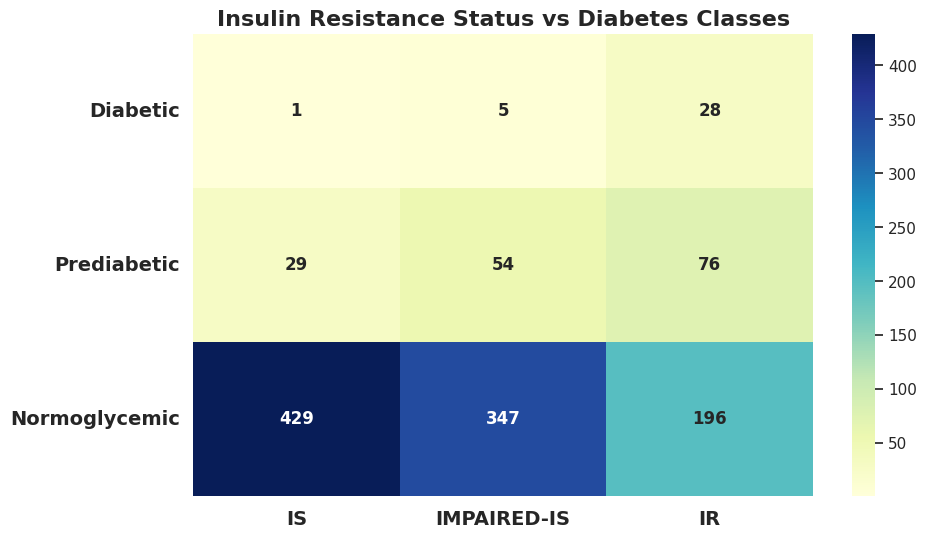

<Figure size 600x800 with 0 Axes>

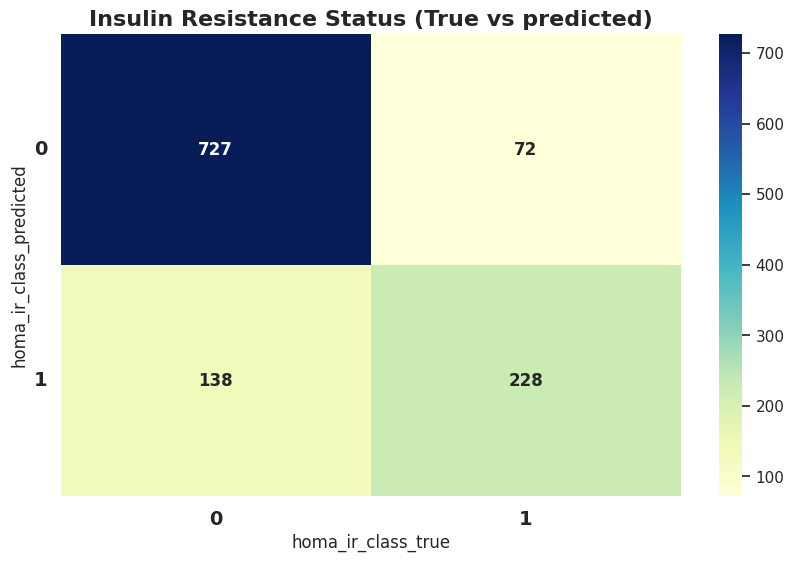

<Figure size 600x800 with 0 Axes>

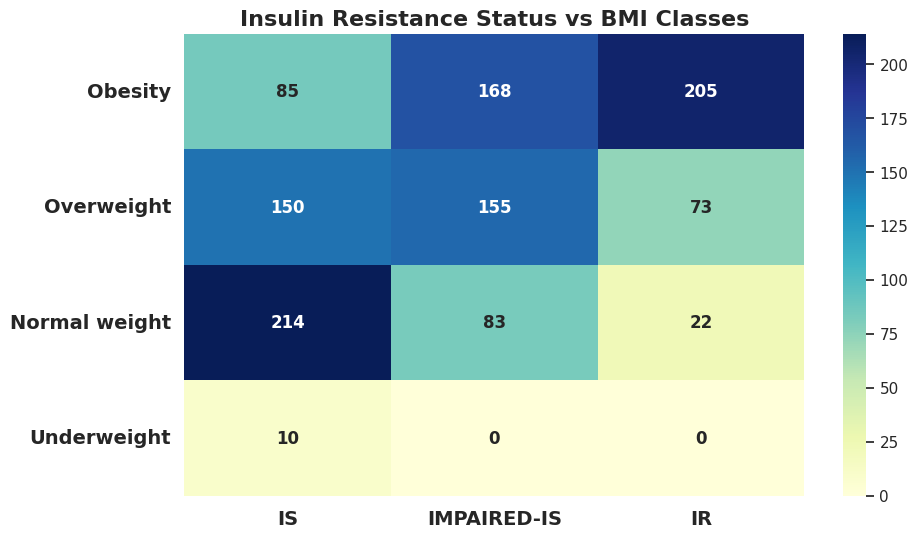

<Figure size 600x800 with 0 Axes>

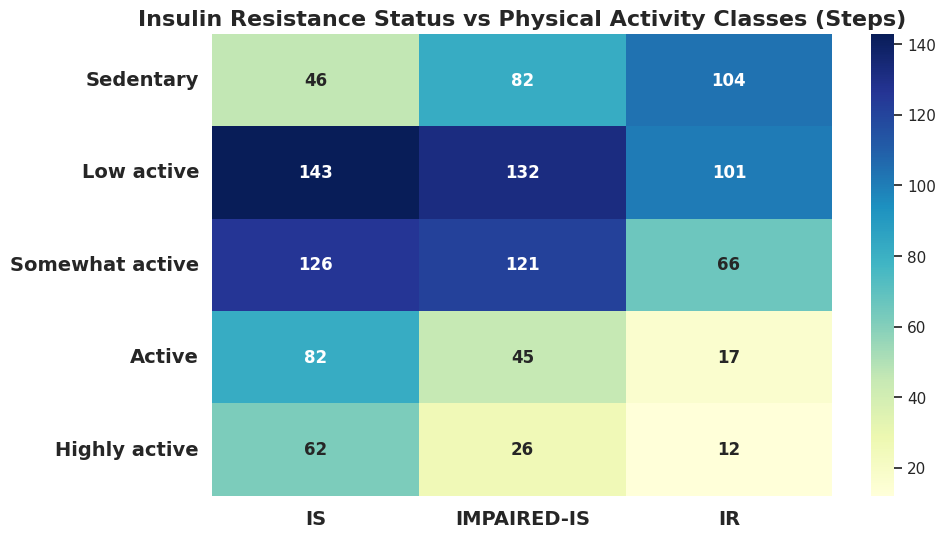

<Figure size 600x800 with 0 Axes>

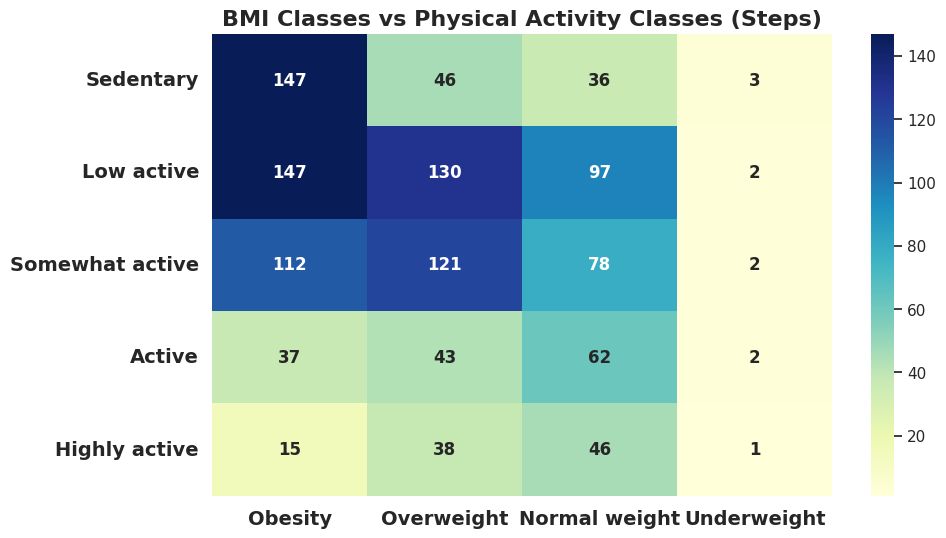

In [ ]:
#@title Create a crosstab for Diabetes vs IR-status
plt.figure(figsize=(6, 8))
crosstab = pd.crosstab(homa_ir_prediction_score_labels['Diabetes_Status'],
                       homa_ir_prediction_score_labels['homa_ir_status']
)

# Reorder the crosstab
desired_row_order = ['Diabetic', 'Prediabetic', 'Normoglycemic']
desired_column_order = ['IS', 'IMPAIRED-IS', 'IR']
crosstab = crosstab.reindex(index=desired_row_order, columns=desired_column_order)

# Plot a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(crosstab, annot=True, fmt='d',cmap='YlGnBu', annot_kws={"size": 12, "weight": 'bold'})
plt.title('Insulin Resistance Status vs Diabetes Classes', fontsize=16, fontweight='bold')
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold',rotation=0)
plt.show()

## Plot IR numbers
plt.figure(figsize=(6, 8))
crosstab = pd.crosstab(homa_ir_prediction_score_labels['homa_ir_class_predicted'],
                       homa_ir_prediction_score_labels['homa_ir_class_true']
)

# Reorder the crosstab
desired_row_order = [0, 1]
desired_column_order = [0, 1]
crosstab = crosstab.reindex(index=desired_row_order, columns=desired_column_order)

# Plot a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(crosstab, annot=True, fmt='d',cmap='YlGnBu', annot_kws={"size": 12, "weight": 'bold'})
plt.title('Insulin Resistance Status (True vs predicted)', fontsize=16, fontweight='bold')
plt.xlabel('homa_ir_class_true')
plt.ylabel('homa_ir_class_predicted')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold',rotation=0)
plt.show()



# Create a crosstab for BMI vs IR-status
plt.figure(figsize=(6, 8))
crosstab = pd.crosstab(homa_ir_prediction_score_labels['bmi_class'],
                       homa_ir_prediction_score_labels['homa_ir_status']
)

# Reorder the crosstab
desired_row_order = ['Obesity', 'Overweight', 'Normal weight', 'Underweight']
desired_column_order = ['IS', 'IMPAIRED-IS', 'IR']
crosstab = crosstab.reindex(index=desired_row_order, columns=desired_column_order)

# Plot a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(crosstab, annot=True, fmt='d',cmap='YlGnBu', annot_kws={"size": 12, "weight": 'bold'})
plt.title('Insulin Resistance Status vs BMI Classes', fontsize=16, fontweight='bold')
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold',rotation=0)
plt.show()



# Create a crosstab for Physical ctivity (steps) vs IR-status
plt.figure(figsize=(6, 8))
crosstab = pd.crosstab(homa_ir_prediction_score_labels['physical_activity_class_steps'],
                       homa_ir_prediction_score_labels['homa_ir_status']
)

# Reorder the crosstab
desired_row_order = ['Sedentary', 'Low active', 'Somewhat active', 'Active', 'Highly active']
desired_column_order = ['IS', 'IMPAIRED-IS', 'IR']
crosstab = crosstab.reindex(index=desired_row_order, columns=desired_column_order)

# Plot a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(crosstab, annot=True, fmt='d',cmap='YlGnBu', annot_kws={"size": 12, "weight": 'bold'})
plt.title('Insulin Resistance Status vs Physical Activity Classes (Steps)', fontsize=16, fontweight='bold')
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold',rotation=0)
plt.show()


## Plot for Physical activity and Obesity
# Create a crosstab for Physical ctivity (AZM) vs IR-status
plt.figure(figsize=(6, 8))
crosstab = pd.crosstab(homa_ir_prediction_score_labels['physical_activity_class_steps'],
                       homa_ir_prediction_score_labels['bmi_class']
)

# Reorder the crosstab
desired_row_order = ['Sedentary', 'Low active', 'Somewhat active', 'Active', 'Highly active']
desired_column_order = ['Obesity', 'Overweight', 'Normal weight', 'Underweight']
crosstab = crosstab.reindex(index=desired_row_order, columns=desired_column_order)

# Plot a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(crosstab, annot=True, fmt='d',cmap='YlGnBu', annot_kws={"size": 12, "weight": 'bold'})
plt.title('BMI Classes vs Physical Activity Classes (Steps)', fontsize=16, fontweight='bold')
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold',rotation=0)
plt.show()
